In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
from sklearn.preprocessing import MinMaxScaler
# from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

import warnings
import pickle
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 
import seaborn as sns

#Regression
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.api import OLS, add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

#Decomposition
from sklearn.decomposition import PCA

In [ ]:
all_sheets = pd.read_excel("Integrated_Data_BAM.xlsx", sheet_name=None, index_col=0)

"""Iterate through all sheets
for sheet_name, df in all_sheets.items():
    print(f"Sheet Name: {sheet_name}")
    print(df.head())"""

'Iterate through all sheets\nfor sheet_name, df in all_sheets.items():\n    print(f"Sheet Name: {sheet_name}")\n    print(df.head())'

In [4]:
# All names of Dataframes by Sheet name

all_sheets.keys()

dict_keys(['unemployment_rate', 'extra_unemployment_rate', 'gov_total_expense_revenue', 'money_supply', 'bonds', 'cpi', 'economic_growth', 'import_export', 'uk_home_retail', 'seasonal_retail_sales', 'uk_building', 'mortage', 'uk_retail_price', 'uk_affordability_index', 'construction_cost_prices_sales', 'mortage_interest_rate', 'company_revenue', 'operating_expenses'])

In [5]:
all_sheets['extra_unemployment_rate']

Unemployment Rate Unemployment (Thousands)     Female     Male
Date                                                                   
Dec 2024                --                       --         --       --
Nov 2024               4.4                     1568        4.2      4.7
Oct 2024               4.3                     1508          4      4.6
Sep 2024               4.3                     1509        4.1      4.5
Aug 2024               4.1                     1435          4      4.2
...                    ...                      ...        ...      ...
Sep 2018               4.1                     1382          4      4.2
Aug 2018                 4                     1368          4      4.1
Jul 2018                 4                     1363          4        4
Jun 2018                 4                     1367          4      4.1
May 2018               4.2                     1413        4.1      4.2

[80 rows x 4 columns]

Clean data for columns that have all null values

In [6]:
# Drop unnamed columns, using this to clean data as tables such as Extra Unemployment Rate have been converted weirdly, giving extra null columns where there aren't any
def drop_unnamed_columns(df):
    return df.loc[:, ~df.columns.str.contains('^Unnamed')]

cleaned_columns = {name: drop_unnamed_columns(df) for name, df in all_sheets.items()}

cleaned_columns['extra_unemployment_rate']

Unemployment Rate Unemployment (Thousands)     Female     Male
Date                                                                   
Dec 2024                --                       --         --       --
Nov 2024               4.4                     1568        4.2      4.7
Oct 2024               4.3                     1508          4      4.6
Sep 2024               4.3                     1509        4.1      4.5
Aug 2024               4.1                     1435          4      4.2
...                    ...                      ...        ...      ...
Sep 2018               4.1                     1382          4      4.2
Aug 2018                 4                     1368          4      4.1
Jul 2018                 4                     1363          4        4
Jun 2018                 4                     1367          4      4.1
May 2018               4.2                     1413        4.1      4.2

[80 rows x 4 columns]

Dropping fully null rows

In [7]:
cleaned_data = {}

for sheet_name, df in cleaned_columns.items():
    print(f"\n📄 Cleaning Sheet: {sheet_name}")

    try:
        # 🚀 Drop rows where all values are null
        df_cleaned = df.dropna(how="all")

        # Store the cleaned DataFrame
        cleaned_data[sheet_name] = df_cleaned

        # Print number of rows dropped
        rows_dropped = len(df) - len(df_cleaned)
        print(f"✅ Dropped {rows_dropped} fully null rows from {sheet_name}")

    except Exception as e:
        print(f"❌ Error cleaning {sheet_name}: {e}")


📄 Cleaning Sheet: unemployment_rate
✅ Dropped 0 fully null rows from unemployment_rate

📄 Cleaning Sheet: extra_unemployment_rate
✅ Dropped 0 fully null rows from extra_unemployment_rate

📄 Cleaning Sheet: gov_total_expense_revenue
✅ Dropped 0 fully null rows from gov_total_expense_revenue

📄 Cleaning Sheet: money_supply
✅ Dropped 0 fully null rows from money_supply

📄 Cleaning Sheet: bonds
✅ Dropped 0 fully null rows from bonds

📄 Cleaning Sheet: cpi
✅ Dropped 0 fully null rows from cpi

📄 Cleaning Sheet: economic_growth
✅ Dropped 0 fully null rows from economic_growth

📄 Cleaning Sheet: import_export
✅ Dropped 0 fully null rows from import_export

📄 Cleaning Sheet: uk_home_retail
✅ Dropped 0 fully null rows from uk_home_retail

📄 Cleaning Sheet: seasonal_retail_sales
✅ Dropped 0 fully null rows from seasonal_retail_sales

📄 Cleaning Sheet: uk_building
✅ Dropped 0 fully null rows from uk_building

📄 Cleaning Sheet: mortage
✅ Dropped 0 fully null rows from mortage

📄 Cleaning Sheet: u

Checking Null Values for Each Sheet

In [8]:
for sheet_name, df in cleaned_columns.items():
    # Check for missing values per column
    missing_values = df.isnull().sum()

    # Display results
    print(f"\nSheet: {sheet_name}")
    print("Missing Values Per Column:")
    print(missing_values)

    # Check if there are any null values
    total_missing = missing_values.sum()
    if total_missing == 0:
        print("✅ No missing values in this sheet.")
    else:
        print(f"⚠️Total missing values in this sheet: {total_missing}")


Sheet: unemployment_rate
Missing Values Per Column:
Unenployment Rate     0
Population           10
dtype: int64
⚠️Total missing values in this sheet: 10

Sheet: extra_unemployment_rate
Missing Values Per Column:
Unemployment Rate           0
Unemployment (Thousands)    0
    Female                  0
    Male                    0
dtype: int64
✅ No missing values in this sheet.

Sheet: gov_total_expense_revenue
Missing Values Per Column:
Expense               0
Revenue               0
Surplus or Deficit    0
dtype: int64
✅ No missing values in this sheet.

Sheet: money_supply
Missing Values Per Column:
M1                    0
M2                    0
M2 YOY Growth Rate    0
M3                    0
M3 YOY Growth Rate    0
M4                    0
M4 YOY Growth Rate    0
dtype: int64
✅ No missing values in this sheet.

Sheet: bonds
Missing Values Per Column:
5 Year     0
10 Year    0
20 Year    0
dtype: int64
✅ No missing values in this sheet.

Sheet: cpi
Missing Values Per Column:
CPI   

In [9]:
# Function to drop columns with more than 35% missing data with error handling
def drop_columns(df, threshold = 0.35):
    # Calculate the percentage of missing values in each column
    missing_percentage = df.isnull().mean()

    # Identify columns where the percentage of missing values exceeds the threshold
    columns_to_drop = missing_percentage[missing_percentage > threshold].index

    # If ALL columns exceed the threshold, drop only the worst ones and keep at least one column
    if len(columns_to_drop) == len(df.columns):
        print(f"Warning: All columns in the DataFrame exceed the {threshold*100}% missing data threshold.")
        # Keep the column with the least missing data
        column_to_keep = missing_percentage.idxmin()
        columns_to_drop = columns_to_drop.drop(column_to_keep)

    # Drop the identified columns
    return df.drop(columns=columns_to_drop)

cleaned_df = {name: drop_columns(df) for name, df in cleaned_columns.items()}

In [10]:
# Comparison for new dataset
for sheet_name, df in cleaned_df.items():
    print(f"Sheet: {sheet_name}")
    print(f"Columns: {df.columns}")
    print(f"Shape: {df.shape}")
    print(df.head())
    print("\n")

Sheet: unemployment_rate
Columns: Index(['Unenployment Rate', 'Population'], dtype='object')
Shape: (178, 2)
         Unenployment Rate  Population
YYMM                                  
2024/10                4.3         NaN
2024/09                4.3         NaN
2024/08                4.1         NaN
2024/07                4.2         NaN
2024/06                4.2         NaN


Sheet: extra_unemployment_rate
Columns: Index(['Unemployment Rate', 'Unemployment (Thousands)', '    Female',
       '    Male'],
      dtype='object')
Shape: (80, 4)
         Unemployment Rate Unemployment (Thousands)     Female     Male
Date                                                                   
Dec 2024                --                       --         --       --
Nov 2024               4.4                     1568        4.2      4.7
Oct 2024               4.3                     1508          4      4.6
Sep 2024               4.3                     1509        4.1      4.5
Aug 2024         

              M1       M2  M2 YOY Growth Rate       M3  M3 YOY Growth Rate  \
YYMM                                                                         
2024/11  2221455  3067494                2.43  3579952                2.68   
2024/10  2217494  3062782                2.43  3567812                2.34   
2024/09  2205040  3044830                0.09  3549183                0.11   
2024/08  2180414  3024072               -0.56  3516038               -1.29   
2024/07  2206676  3040913               -0.03  3544273                0.22   

              M4  M4 YOY Growth Rate  
YYMM                                  
2024/11  3077109                2.99  
2024/10  3078011                3.01  
2024/09  3083178                3.38  
2024/08  3065166                1.40  
2024/07  3067715                1.83  


Sheet: bonds
Columns: Index(['5 Year', '10 Year', '20 Year'], dtype='object')
Shape: (180, 3)
         5 Year  10 Year  20 Year
YYMM                             
2024/12    4.12 

In [11]:
# Comparison for initial dataset
for sheet_name, df in all_sheets.items():
    print(f"Sheet: {sheet_name}")
    print(f"Columns: {df.columns}")
    print(f"Shape: {df.shape}")
    print(df.head())
    print("\n")

Sheet: unemployment_rate
Columns: Index(['Unenployment Rate', 'Population'], dtype='object')
Shape: (178, 2)
         Unenployment Rate  Population
YYMM                                  
2024/10                4.3         NaN
2024/09                4.3         NaN
2024/08                4.1         NaN
2024/07                4.2         NaN
2024/06                4.2         NaN


Sheet: extra_unemployment_rate
Columns: Index(['Unemployment Rate', 'Unemployment (Thousands)', '    Female',
       '    Male'],
      dtype='object')
Shape: (80, 4)
         Unemployment Rate Unemployment (Thousands)     Female     Male
Date                                                                   
Dec 2024                --                       --         --       --
Nov 2024               4.4                     1568        4.2      4.7
Oct 2024               4.3                     1508          4      4.6
Sep 2024               4.3                     1509        4.1      4.5
Aug 2024         

Aggregated Data for Tables in YYYY/MM Format

In [12]:
# Dictionary to store aggregated annual data
annual_data = {}

for sheet_name, df in cleaned_df.items():
    print(f"\n📄 Processing Sheet: {sheet_name}")

    try:
        # Convert index to string & remove decimal points if read as float
        df.index = df.index.astype(str).str.split(".").str[0]

        # Debug: Show first 5 index values
        print(f"First 5 index values:\n{df.index[:5].tolist()}")

        # Check if all index values match YYYY/MM format
        if not all(re.fullmatch(r"\d{4}/\d{2}", idx) for idx in df.index):
            print(f"⚠️ Skipping {sheet_name}: Index not in 'YYYY/MM' format.")
            continue

        # Extract the year (first 4 characters)
        df["year"] = df.index.str[:4]

        # Group by year and compute the mean for all numeric columns
        annual_dfs = df.groupby("year").mean(numeric_only=True)

        # Store result
        annual_data[sheet_name] = annual_dfs

        # Print the result
        print(annual_dfs.head())

    except Exception as e:
        print(f"⚠️ Error processing {sheet_name}: {e}")


📄 Processing Sheet: unemployment_rate
First 5 index values:
['2024/10', '2024/09', '2024/08', '2024/07', '2024/06']
      Unenployment Rate  Population
year                               
2010           7.875000       62.76
2011           8.058333       63.29
2012           8.016667       63.71
2013           7.633333       64.11
2014           6.300000       64.60

📄 Processing Sheet: extra_unemployment_rate
First 5 index values:
['Dec 2024', 'Nov 2024', 'Oct 2024', 'Sep 2024', 'Aug 2024']
⚠️ Skipping extra_unemployment_rate: Index not in 'YYYY/MM' format.

📄 Processing Sheet: gov_total_expense_revenue
First 5 index values:
['2023/12', '2022/12', '2021/12', '2020/12', '2019/12']
      Expense  Revenue  Surplus or Deficit
year                                      
2010   719.49   570.64             -148.85
2011   723.41   600.04             -123.37
2012   746.45   618.00             -128.45
2013   745.41   649.54              -95.87
2014   767.12   663.27             -103.85

📄 Proces

Now to get all date formats converted to aggregate data

In [13]:
# Dictionary to store aggregated annual data
annual_data = {}

# Function to convert "Dec 2024" to "YYYY/MM"
def convert_month_year(date_str):
    try:
        dt = pd.to_datetime(date_str, format="%b %Y")  # Convert "Dec 2024"
        return dt.strftime("%Y/%m")  # Convert to "YYYY/MM"
    except ValueError:
        return None  # Return None if conversion fails

# Function to convert "Q2 2024" to "YYYY/MM" (start of the quarter)
def convert_quarter_year(date_str):
    match = re.fullmatch(r"Q([1-4]) (\d{4})", date_str)
    if match:
        quarter, year = match.groups()
        month_map = {"1": "01", "2": "04", "3": "07", "4": "10"}  # Q1 → 01, Q2 → 04, etc.
        return f"{year}/{month_map[quarter]}"
    return None  # Return None if conversion fails

for sheet_name, df in cleaned_df.items():
    print(f"\n📄 Processing Sheet: {sheet_name}")

    try:
        # Convert index to string and clean up formatting
        df.index = df.index.astype(str).str.strip().str.split(".").str[0]

        # Debugging: Print first 5 index values
        print(f"🔍 First 5 index values in {sheet_name}: {df.index[:5].tolist()}")

        # Convert different date formats
        converted_index = []
        for idx in df.index:
            original_idx = idx  # Store original value for debugging

            if re.fullmatch(r"\d{4}/\d{2}", idx):  # Already in YYYY/MM format
                converted_index.append(idx)
            elif re.fullmatch(r"[A-Za-z]{3} \d{4}", idx):  # "Dec 2024" format
                converted_value = convert_month_year(idx)
                converted_index.append(converted_value)
                print(f"✅ Converted '{original_idx}' → '{converted_value}'")
            elif re.fullmatch(r"Q[1-4] \d{4}", idx):  # "Q2 2024" format
                converted_value = convert_quarter_year(idx)
                converted_index.append(converted_value)
                print(f"✅ Converted '{original_idx}' → '{converted_value}'")
            else:
                print(f"⚠️ Skipping '{idx}' in {sheet_name}: Invalid format")
                converted_index.append(None)

        # Extract year and group data
        df["year"] = df.index.str[:4]  # Extract year
        annual_dfs = df.groupby("year").mean(numeric_only=True)

        # Store result
        annual_data[sheet_name] = annual_dfs

        # Print the result
        print(f"📊 Aggregated Data for {sheet_name}:")
        print(annual_dfs.head())

    except Exception as e:
        print(f"❌ Error processing {sheet_name}: {e}")


📄 Processing Sheet: unemployment_rate
🔍 First 5 index values in unemployment_rate: ['2024/10', '2024/09', '2024/08', '2024/07', '2024/06']
📊 Aggregated Data for unemployment_rate:
      Unenployment Rate  Population
year                               
2010           7.875000       62.76
2011           8.058333       63.29
2012           8.016667       63.71
2013           7.633333       64.11
2014           6.300000       64.60

📄 Processing Sheet: extra_unemployment_rate
🔍 First 5 index values in extra_unemployment_rate: ['Dec 2024', 'Nov 2024', 'Oct 2024', 'Sep 2024', 'Aug 2024']
✅ Converted 'Dec 2024' → '2024/12'
✅ Converted 'Nov 2024' → '2024/11'
✅ Converted 'Oct 2024' → '2024/10'
✅ Converted 'Sep 2024' → '2024/09'
✅ Converted 'Aug 2024' → '2024/08'
✅ Converted 'Jul 2024' → '2024/07'
✅ Converted 'Jun 2024' → '2024/06'
✅ Converted 'May 2024' → '2024/05'
✅ Converted 'Apr 2024' → '2024/04'
✅ Converted 'Mar 2024' → '2024/03'
✅ Converted 'Feb 2024' → '2024/02'
✅ Converted 'Jan 2024' → 

# EDA and Features for each sheet
## Unemployment Rate

In [ ]:
# Reading the data from the excel file for the specific sheet

df_unemployment_rate = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="unemployment_rate", index_col=0)

df_unemployment_rate.reset_index(inplace=True)

df_unemployment_rate

YYMM  Unenployment Rate  Population
0    2024/10                4.3         NaN
1    2024/09                4.3         NaN
2    2024/08                4.1         NaN
3    2024/07                4.2         NaN
4    2024/06                4.2         NaN
..       ...                ...         ...
173  2010/05                7.9       62.76
174  2010/04                8.0       62.76
175  2010/03                8.0       62.76
176  2010/02                7.9       62.76
177  2010/01                7.7       62.76

[178 rows x 3 columns]

In [15]:
df_unemployment_rate.fillna(68.12, inplace=True)

In [16]:
# Date Features 

df_unemployment_rate['YYMM'] = pd.to_datetime(df_unemployment_rate['YYMM'], errors='coerce')
    
# Extracting time-based features
df_unemployment_rate['Year'] = df_unemployment_rate['YYMM'].dt.year
df_unemployment_rate['Month'] = df_unemployment_rate['YYMM'].dt.month


yearly_data_ur = df_unemployment_rate.groupby('Year').agg({
    'Unenployment Rate': 'mean',  # Average unemployment rate
    'Population': 'mean'          # Average population (could be sum if appropriate)
}).reset_index()

yearly_data_ur

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\3264213875.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_unemployment_rate['YYMM'] = pd.to_datetime(df_unemployment_rate['YYMM'], errors='coerce')


Year  Unenployment Rate  Population
0   2010           7.875000       62.76
1   2011           8.058333       63.29
2   2012           8.016667       63.71
3   2013           7.633333       64.11
4   2014           6.300000       64.60
5   2015           5.416667       65.11
6   2016           4.925000       65.65
7   2017           4.416667       66.04
8   2018           4.108333       66.44
9   2019           3.850000       66.80
10  2020           4.491667       67.08
11  2021           4.633333       67.28
12  2022           3.800000       67.79
13  2023           4.050000       68.12
14  2024           4.250000       68.12

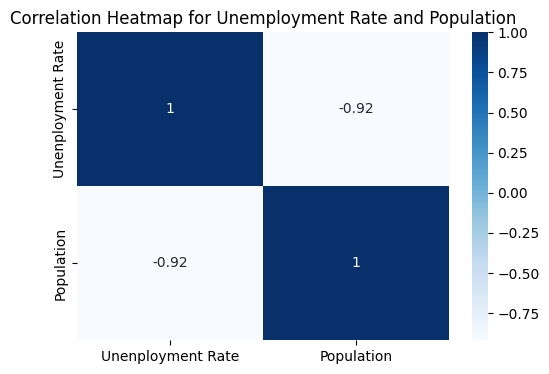

In [151]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_unemployment_rate[['Unenployment Rate', 'Population']].corr(), annot=True, cmap='Blues')
plt.title('Correlation Heatmap for Unemployment Rate and Population')
plt.show()

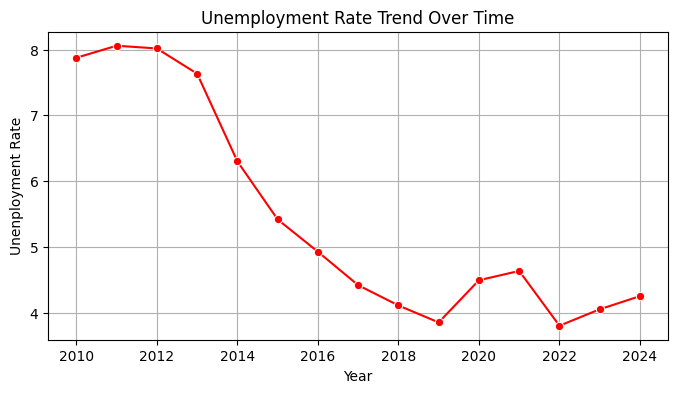

In [18]:
# Using MEAN to plot the graph

plt.figure(figsize=(8, 4)) 
sns.lineplot(data=yearly_data_ur, x='Year', y='Unenployment Rate', marker='o', color='red')
plt.title('Unemployment Rate Trend Over Time')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

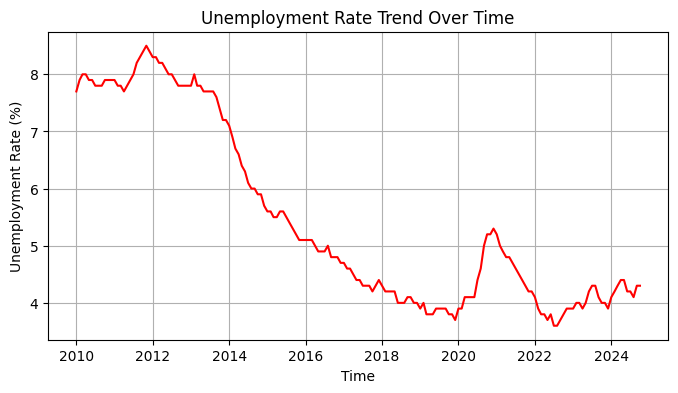

In [19]:
plt.figure(figsize=(8, 4)) 
sns.lineplot(data=df_unemployment_rate, x='YYMM', y='Unenployment Rate', color='red')
plt.xlabel('Time')
plt.ylabel('Unemployment Rate (%)')
plt.title('Unemployment Rate Trend Over Time')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

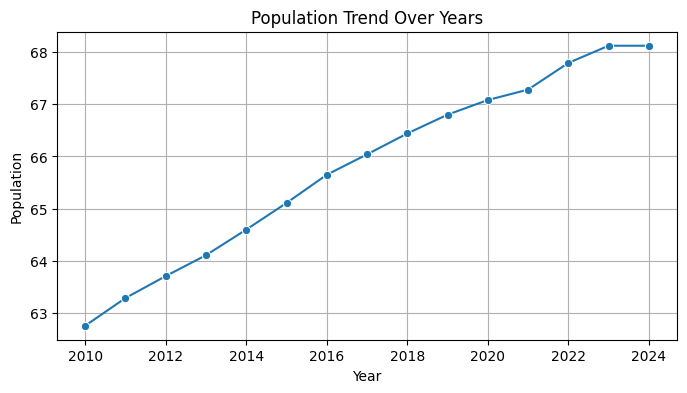

In [20]:
plt.figure(figsize=(8, 4)) 
sns.lineplot(data=yearly_data_ur, x='Year', y='Population', marker='o')
plt.title('Population Trend Over Years')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

## Extra Unemployment Rate 

In [21]:
df_extra_unemployment_rate = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="extra_unemployment_rate", index_col=0)
df_extra_unemployment_rate.reset_index(inplace=True)
df_extra_unemployment_rate

Date Unemployment Rate Unemployment (Thousands)     Female     Male
0   Dec 2024                --                       --         --       --
1   Nov 2024               4.4                     1568        4.2      4.7
2   Oct 2024               4.3                     1508          4      4.6
3   Sep 2024               4.3                     1509        4.1      4.5
4   Aug 2024               4.1                     1435          4      4.2
..       ...               ...                      ...        ...      ...
75  Sep 2018               4.1                     1382          4      4.2
76  Aug 2018                 4                     1368          4      4.1
77  Jul 2018                 4                     1363          4        4
78  Jun 2018                 4                     1367          4      4.1
79  May 2018               4.2                     1413        4.1      4.2

[80 rows x 5 columns]

In [22]:
# Replacing "--" with NaN values
df_extra_unemployment_rate['Unemployment Rate'].replace('--', np.nan, inplace=True)
df_extra_unemployment_rate['Unemployment (Thousands)'].replace('--', np.nan, inplace=True)
df_extra_unemployment_rate['    Female'].replace('--', np.nan, inplace=True)
df_extra_unemployment_rate['    Male'].replace('--', np.nan, inplace=True)
df_extra_unemployment_rate

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\3607231568.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_extra_unemployment_rate['Unemployment Rate'].replace('--', np.nan, inplace=True)
C:\Users\neera\AppData\Local\Temp\ipykernel_15812\3607231568.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting',

Date  Unemployment Rate  Unemployment (Thousands)      Female  \
0   Dec 2024                NaN                       NaN         NaN   
1   Nov 2024                4.4                    1568.0         4.2   
2   Oct 2024                4.3                    1508.0         4.0   
3   Sep 2024                4.3                    1509.0         4.1   
4   Aug 2024                4.1                    1435.0         4.0   
..       ...                ...                       ...         ...   
75  Sep 2018                4.1                    1382.0         4.0   
76  Aug 2018                4.0                    1368.0         4.0   
77  Jul 2018                4.0                    1363.0         4.0   
78  Jun 2018                4.0                    1367.0         4.0   
79  May 2018                4.2                    1413.0         4.1   

        Male  
0        NaN  
1        4.7  
2        4.6  
3        4.5  
4        4.2  
..       ...  
75       4.2  
76       4.1  
77       4.0  
78       4.1  
79       4.2  

[80 rows x 5 columns]

In [23]:
df_extra_unemployment_rate['Date'] = pd.to_datetime(df_extra_unemployment_rate['Date'], errors='coerce')
    
# Extracting time-based features
df_extra_unemployment_rate['Year'] = df_extra_unemployment_rate['Date'].dt.year
df_extra_unemployment_rate['Month'] = df_extra_unemployment_rate['Date'].dt.month
df_extra_unemployment_rate

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\2078001518.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_extra_unemployment_rate['Date'] = pd.to_datetime(df_extra_unemployment_rate['Date'], errors='coerce')


Date  Unemployment Rate  Unemployment (Thousands)      Female  \
0  2024-12-01                NaN                       NaN         NaN   
1  2024-11-01                4.4                    1568.0         4.2   
2  2024-10-01                4.3                    1508.0         4.0   
3  2024-09-01                4.3                    1509.0         4.1   
4  2024-08-01                4.1                    1435.0         4.0   
..        ...                ...                       ...         ...   
75 2018-09-01                4.1                    1382.0         4.0   
76 2018-08-01                4.0                    1368.0         4.0   
77 2018-07-01                4.0                    1363.0         4.0   
78 2018-06-01                4.0                    1367.0         4.0   
79 2018-05-01                4.2                    1413.0         4.1   

        Male  Year  Month  
0        NaN  2024     12  
1        4.7  2024     11  
2        4.6  2024     10  
3        4.5  2024      9  
4        4.2  2024      8  
..       ...   ...    ...  
75       4.2  2018      9  
76       4.1  2018      8  
77       4.0  2018      7  
78       4.1  2018      6  
79       4.2  2018      5  

[80 rows x 7 columns]

In [24]:
# Filling missing values with the mean of the respective year

df_extra_unemployment_rate.update(df_extra_unemployment_rate.groupby('Year').transform(lambda x: x.fillna(x.mean())))

df_extra_unemployment_rate = df_extra_unemployment_rate.round(1)

df_extra_unemployment_rate

Date  Unemployment Rate  Unemployment (Thousands)      Female  \
0  2024-12-01                4.3                    1492.4         4.0   
1  2024-11-01                4.4                    1568.0         4.2   
2  2024-10-01                4.3                    1508.0         4.0   
3  2024-09-01                4.3                    1509.0         4.1   
4  2024-08-01                4.1                    1435.0         4.0   
..        ...                ...                       ...         ...   
75 2018-09-01                4.1                    1382.0         4.0   
76 2018-08-01                4.0                    1368.0         4.0   
77 2018-07-01                4.0                    1363.0         4.0   
78 2018-06-01                4.0                    1367.0         4.0   
79 2018-05-01                4.2                    1413.0         4.1   

        Male  Year  Month  
0        4.5  2024     12  
1        4.7  2024     11  
2        4.6  2024     10  
3        4.5  2024      9  
4        4.2  2024      8  
..       ...   ...    ...  
75       4.2  2018      9  
76       4.1  2018      8  
77       4.0  2018      7  
78       4.1  2018      6  
79       4.2  2018      5  

[80 rows x 7 columns]

In [25]:
# Grouping by year and computing the mean of all numeric columns

yearly_data_eur = df_extra_unemployment_rate.groupby('Year').agg({
    'Unemployment Rate': 'mean',
    'Unemployment (Thousands)' : 'mean',
    '    Female': 'mean',
    '    Male' : 'mean'
}).reset_index()

yearly_data_eur

Year  Unemployment Rate  Unemployment (Thousands)      Female      Male
0  2018           4.050000               1377.000000    4.000000  4.137500
1  2019           3.850000               1317.750000    3.666667  4.025000
2  2020           4.491667               1533.500000    4.216667  4.758333
3  2021           4.633333               1579.000000    4.433333  4.816667
4  2022           3.800000               1305.000000    3.658333  3.933333
5  2023           4.050000               1404.416667    3.741667  4.341667
6  2024           4.266667               1492.366667    3.991667  4.508333

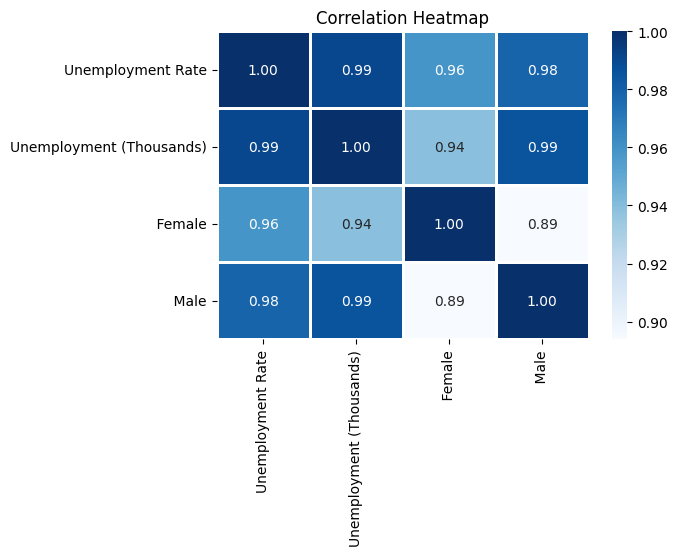

In [152]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_extra_unemployment_rate[['Unemployment Rate', 'Unemployment (Thousands)', '    Female', '    Male']].corr(), 
            annot=True, cmap='Blues', fmt=".2f", linewidths=1)
plt.title('Correlation Heatmap')
plt.show()

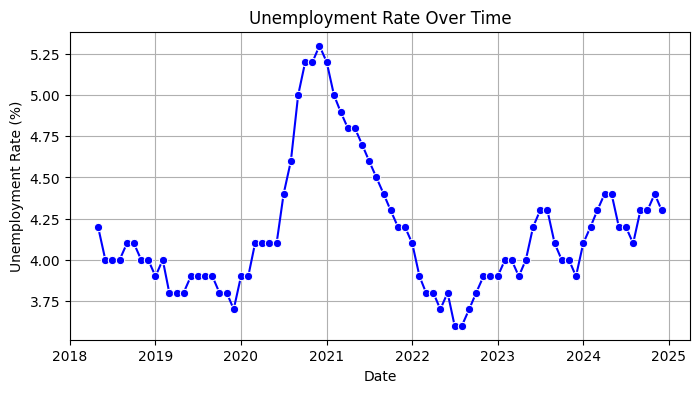

In [27]:
# Line Plot for Unemployment Rate over Time
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_extra_unemployment_rate, x='Date', y='Unemployment Rate', marker='o', color='blue')
plt.title('Unemployment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

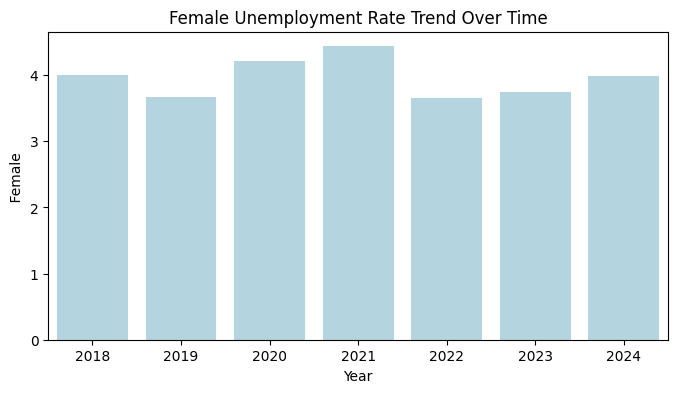

In [28]:
plt.figure(figsize=(8, 4)) 
sns.barplot(data=yearly_data_eur, x='Year', y='    Female', color='lightblue')
plt.title('Female Unemployment Rate Trend Over Time')
plt.xticks(rotation=0)
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\44637864.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=yearly_data_eur, x='Year', y='    Male', palette='viridis')


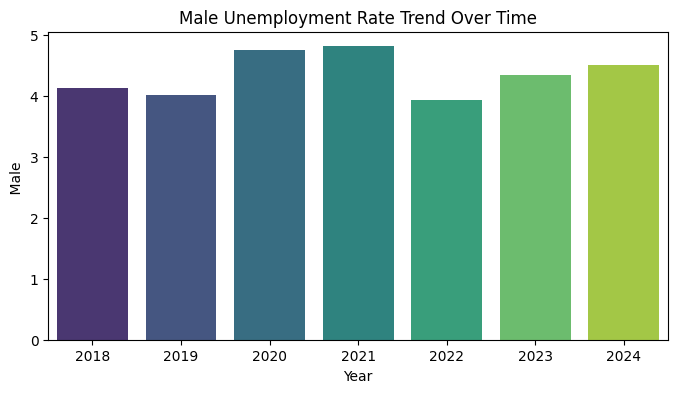

In [29]:
plt.figure(figsize=(8, 4)) 
sns.barplot(data=yearly_data_eur, x='Year', y='    Male', palette='viridis')
plt.title('Male Unemployment Rate Trend Over Time')
plt.xticks(rotation=0)
plt.show()

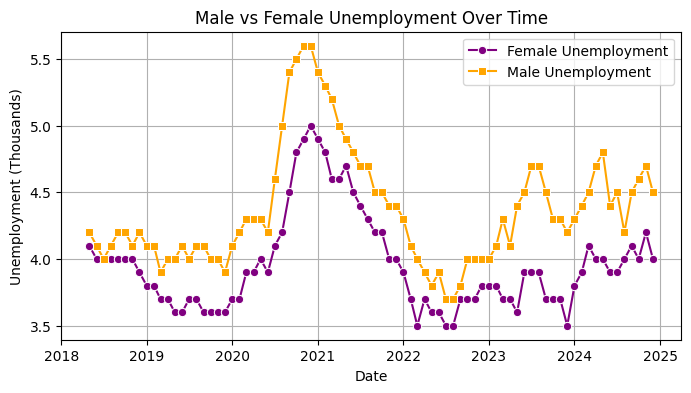

In [30]:
# Line Plot for Male and Female Unemployment Over Time
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_extra_unemployment_rate, x='Date', y='    Female', label='Female Unemployment', marker='o', color='purple')
sns.lineplot(data=df_extra_unemployment_rate, x='Date', y='    Male', label='Male Unemployment', marker='s', color='orange')
plt.title('Male vs Female Unemployment Over Time')
plt.xlabel('Date')
plt.ylabel('Unemployment (Thousands)')
plt.legend()
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

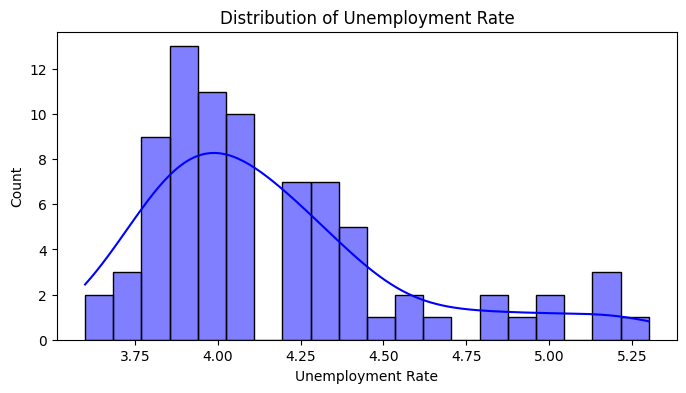

In [31]:
# Distribution Analysis for Unemployment Rates
plt.figure(figsize=(8, 4))
sns.histplot(df_extra_unemployment_rate['Unemployment Rate'], bins=20, kde=True, color='blue')
plt.title('Distribution of Unemployment Rate')
plt.show()

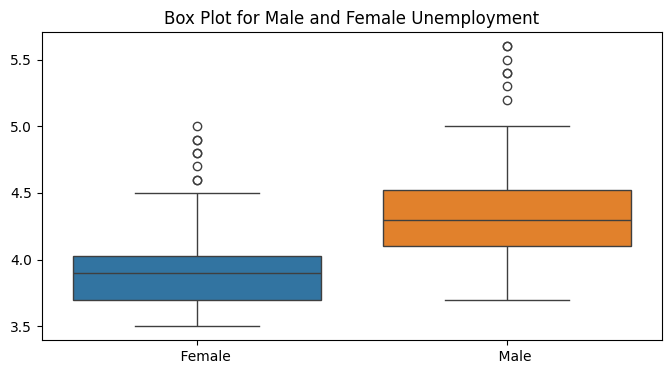

In [32]:
# Box Plot for Unemployment Rates by Gender
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_extra_unemployment_rate[['    Female', '    Male']])
plt.title('Box Plot for Male and Female Unemployment')
plt.show()

## Gov Total Expense and Revenue

In [33]:
df_gov_total_expense_revenue = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="gov_total_expense_revenue")
df_gov_total_expense_revenue

YYMM  Expense  Revenue  Surplus or Deficit
0   2023/12  1201.48  1039.26             -162.22
1   2022/12  1113.20   994.39             -118.82
2   2021/12  1048.01   868.38             -179.63
3   2020/12  1050.83   774.33             -276.50
4   2019/12   865.30   809.86              -55.43
5   2018/12   836.65   787.72              -48.93
6   2017/12   815.44   763.28              -52.16
7   2016/12   789.37   722.88              -66.49
8   2015/12   774.76   686.19              -88.57
9   2014/12   767.12   663.27             -103.85
10  2013/12   745.41   649.54              -95.87
11  2012/12   746.45   618.00             -128.45
12  2011/12   723.41   600.04             -123.37
13  2010/12   719.49   570.64             -148.85

In [34]:
df_gov_total_expense_revenue['YYMM'] = pd.to_datetime(df_gov_total_expense_revenue['YYMM'], errors='coerce')
    
# Extracting time-based features
df_gov_total_expense_revenue['Year'] = df_gov_total_expense_revenue['YYMM'].dt.year
df_gov_total_expense_revenue['Month'] = df_gov_total_expense_revenue['YYMM'].dt.month

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\3957846477.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_gov_total_expense_revenue['YYMM'] = pd.to_datetime(df_gov_total_expense_revenue['YYMM'], errors='coerce')


In [35]:
df_gov_total_expense_revenue.columns.tolist()

['YYMM', 'Expense', 'Revenue', 'Surplus or Deficit', 'Year', 'Month']

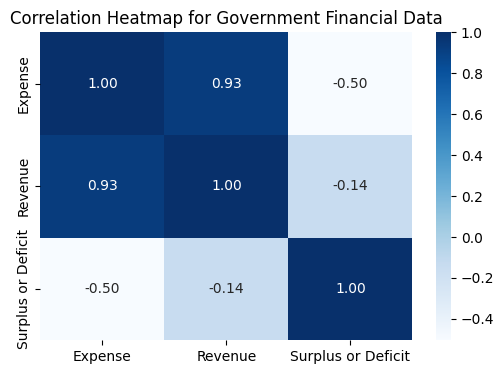

In [36]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_gov_total_expense_revenue[['Expense', 'Revenue', 'Surplus or Deficit']].corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap for Government Financial Data')
plt.show()

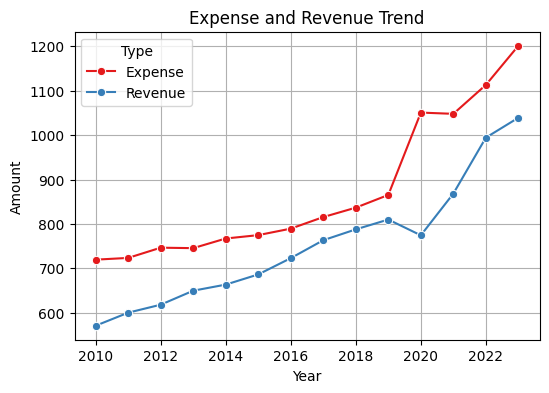

In [37]:
df_melted = df_gov_total_expense_revenue.melt(id_vars='Year', value_vars=['Expense', 'Revenue'], var_name='Type', value_name='Amount')

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_melted, x='Year', y='Amount', hue='Type', marker='o', palette='Set1')
plt.title('Expense and Revenue Trend')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\1423108405.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_gov_total_expense_revenue, x='Year', y='Surplus or Deficit', palette='viridis')


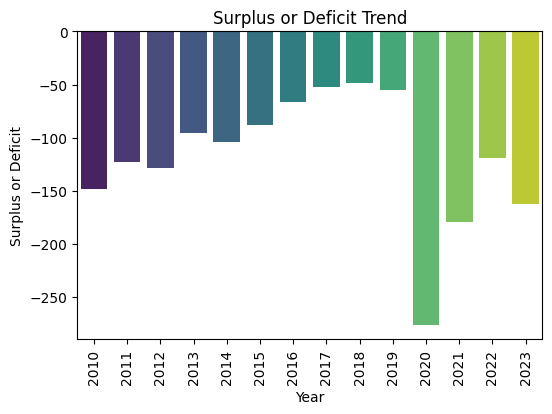

In [38]:
plt.figure(figsize=(6, 4)) 
sns.barplot(data=df_gov_total_expense_revenue, x='Year', y='Surplus or Deficit', palette='viridis')
plt.title('Surplus or Deficit Trend')
plt.xticks(rotation=90)
plt.show()

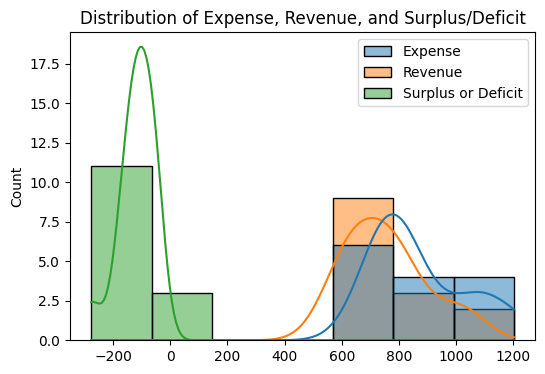

In [39]:
# Distribution Analysis for Expense, Revenue, and Surplus/Deficit
plt.figure(figsize=(6, 4))
sns.histplot(df_gov_total_expense_revenue[['Expense', 'Revenue', 'Surplus or Deficit']], kde=True)
plt.title('Distribution of Expense, Revenue, and Surplus/Deficit')
plt.show()

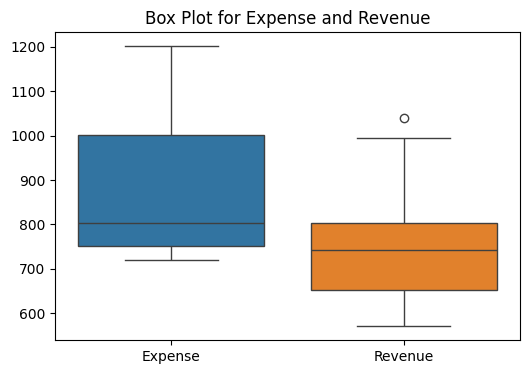

In [40]:
# Box Plot to Detect Outliers for Expense and Revenue
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_gov_total_expense_revenue[['Expense', 'Revenue']])
plt.title('Box Plot for Expense and Revenue')
plt.show()

## Money Supply

In [41]:
df_money_supply = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="money_supply")
df_money_supply

YYMM       M1       M2  M2 YOY Growth Rate       M3  \
0    2024/11  2221455  3067494                2.43  3579952   
1    2024/10  2217494  3062782                2.43  3567812   
2    2024/09  2205040  3044830                0.09  3549183   
3    2024/08  2180414  3024072               -0.56  3516038   
4    2024/07  2206676  3040913               -0.03  3544273   
..       ...      ...      ...                 ...      ...   
174  2010/05  1103837  2090772               14.79  2376535   
175  2010/04  1096565  2075497               13.51  2375347   
176  2010/03  1099100  2103920               13.60  2405333   
177  2010/02  1101923  2120458               15.29  2417478   
178  2010/01  1086545  2092450               13.25  2389183   

     M3 YOY Growth Rate       M4  M4 YOY Growth Rate  
0                  2.68  3077109                2.99  
1                  2.34  3078011                3.01  
2                  0.11  3083178                3.38  
3                 -1.29  3065166                1.40  
4                  0.22  3067715                1.83  
..                  ...      ...                 ...  
174               10.94  2203283               10.94  
175               10.03  2209190               11.71  
176               10.25  2225231               11.00  
177               10.42  2218107               11.33  
178                9.49  2211359               12.33  

[179 rows x 8 columns]

In [42]:
df_money_supply['YYMM'] = pd.to_datetime(df_money_supply['YYMM'], errors='coerce')
    
# Extracting time-based features
df_money_supply['Year'] = df_money_supply['YYMM'].dt.year
df_money_supply['Month'] = df_money_supply['YYMM'].dt.month

yearly_data_ms = df_money_supply.groupby('Year').agg({
    'M1': 'mean',
    'M2': 'mean',
    'M2 YOY Growth Rate' : 'mean',
    'M3' : 'mean',
    'M3 YOY Growth Rate' : 'mean',
    'M4' : 'mean',
    'M4 YOY Growth Rate' : 'mean' 
}).reset_index()

yearly_data_ms

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\1801806560.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_money_supply['YYMM'] = pd.to_datetime(df_money_supply['YYMM'], errors='coerce')


Year            M1            M2  M2 YOY Growth Rate            M3  \
0   2010  1.094754e+06  2.090328e+06           12.900833  2.373002e+06   
1   2011  1.085666e+06  2.075125e+06           -0.724167  2.327860e+06   
2   2012  1.109667e+06  2.029024e+06           -2.215833  2.293525e+06   
3   2013  1.220775e+06  2.086061e+06            2.815000  2.388605e+06   
4   2014  1.327533e+06  2.076217e+06           -0.464167  2.374797e+06   
5   2015  1.419636e+06  2.100046e+06            1.155833  2.371346e+06   
6   2016  1.565770e+06  2.231382e+06            6.245000  2.533586e+06   
7   2017  1.667741e+06  2.316798e+06            3.856667  2.745213e+06   
8   2018  1.739046e+06  2.378319e+06            2.657500  2.840074e+06   
9   2019  1.779016e+06  2.419655e+06            1.744167  2.874400e+06   
10  2020  2.028589e+06  2.672186e+06           10.425000  3.135244e+06   
11  2021  2.282330e+06  2.897420e+06            8.537500  3.380522e+06   
12  2022  2.436531e+06  3.067437e+06            5.870833  3.577824e+06   
13  2023  2.292685e+06  3.045092e+06           -0.673333  3.549272e+06   
14  2024  2.211520e+06  3.037753e+06           -0.306364  3.542127e+06   

    M3 YOY Growth Rate            M4  M4 YOY Growth Rate  
0             8.890833  2.194181e+06            9.597500  
1            -1.899167  2.140971e+06           -2.425833  
2            -1.459167  2.078094e+06           -2.920833  
3             4.150833  2.110935e+06            1.585833  
4            -0.569167  2.110913e+06            0.006667  
5            -0.135833  2.107498e+06           -0.154167  
6             6.832500  2.188942e+06            3.861667  
7             8.414167  2.319215e+06            5.974167  
8             3.469167  2.380850e+06            2.674167  
9             1.219167  2.449094e+06            2.863333  
10            9.068333  2.710230e+06           10.639167  
11            7.881667  2.917012e+06            7.712500  
12            5.855000  3.047171e+06            4.477500  
13           -0.757500  3.023616e+06           -0.753333  
14           -0.231818  3.052832e+06            0.921818

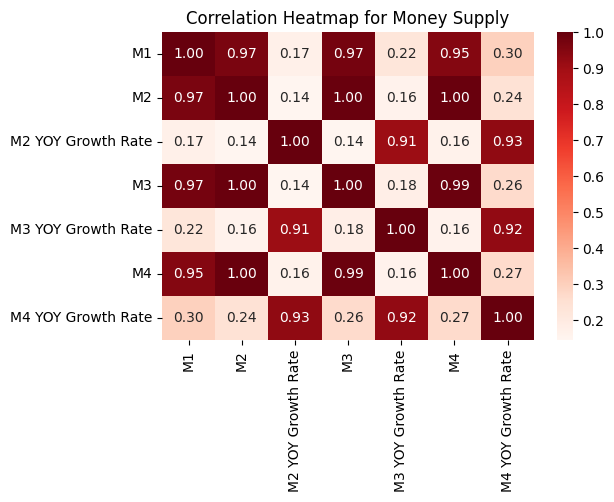

In [43]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_money_supply[['M1', 'M2', 'M2 YOY Growth Rate', 'M3', 'M3 YOY Growth Rate', 'M4', 'M4 YOY Growth Rate']].corr(), annot=True, cmap='Reds', fmt=".2f")
plt.title('Correlation Heatmap for Money Supply')
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\2978392772.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_melted_ms, x='Year', y='Amount', hue='Type', marker='o', palette='Set1', ci=None)


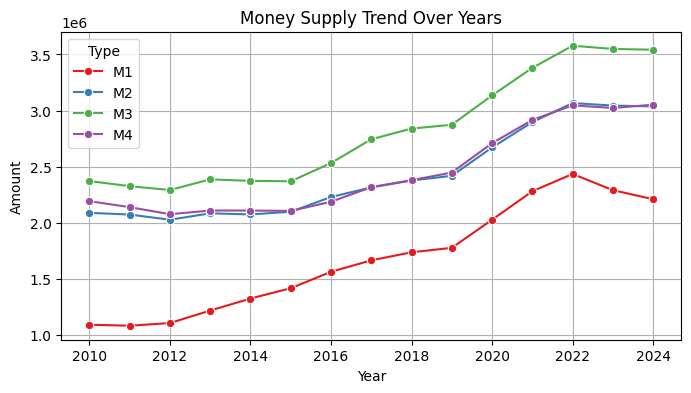

In [153]:
df_melted_ms = df_money_supply.melt(id_vars='Year', value_vars=['M1', 'M2', 'M3', 'M4'], var_name='Type', value_name='Amount')

plt.figure(figsize=(8, 4))
sns.lineplot(data=df_melted_ms, x='Year', y='Amount', hue='Type', marker='o', palette='Set1', ci=None)
plt.title('Money Supply Trend Over Years')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\1756143325.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_melted_ms, x='Year', y='Amount', hue='Type', marker='o', palette='Set1', ci=None)


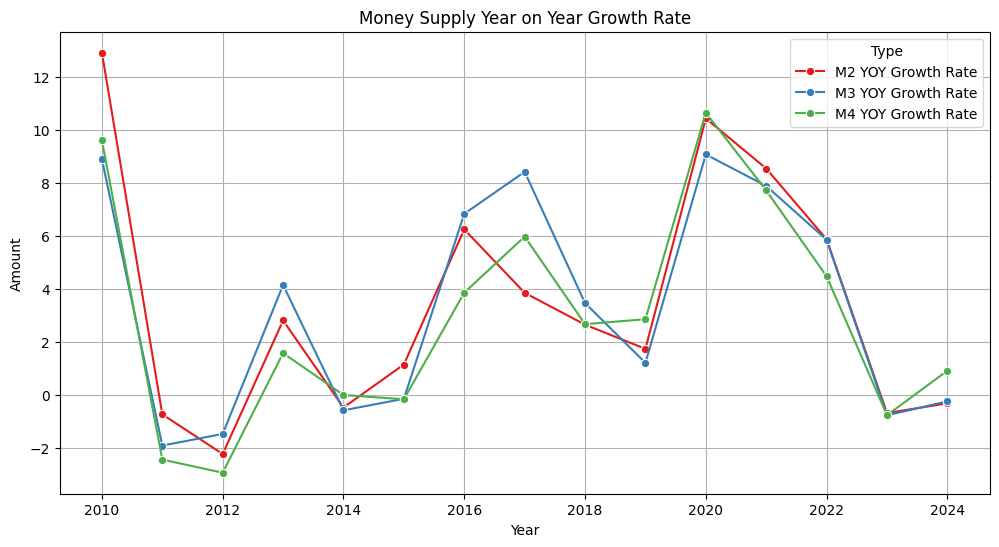

In [ ]:
# Using the Mean data to plot the graph

df_melted_ms = df_money_supply.melt(id_vars='Year', value_vars=['M2 YOY Growth Rate', 'M3 YOY Growth Rate', 'M4 YOY Growth Rate'], var_name='Type', value_name='Amount')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted_ms, x='Year', y='Amount', hue='Type', marker='o', palette='Set1', ci=None)
plt.title('Money Supply Year on Year Growth Rate')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\3409759506.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_melted_ms, x='YYMM', y='Amount', hue='Type', palette='Set1', ci=None)


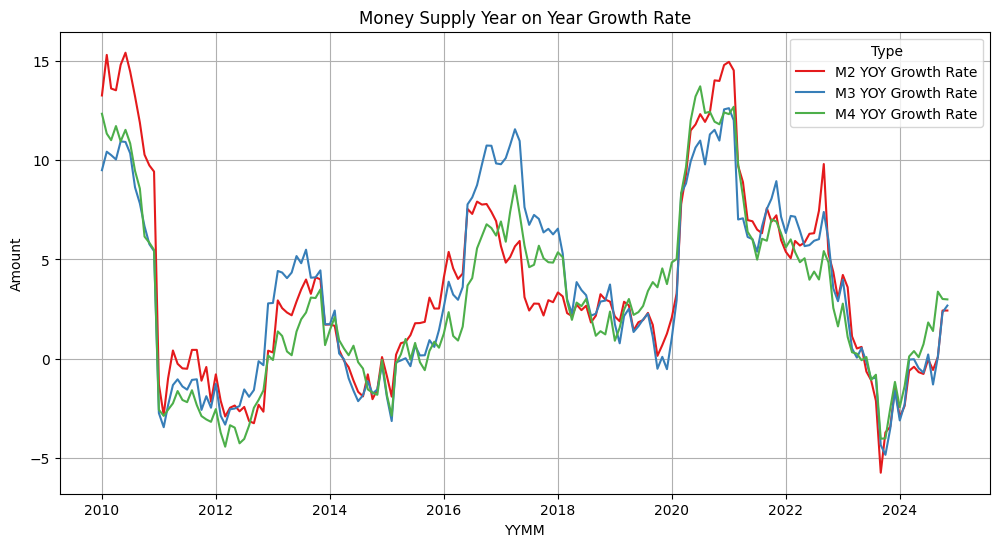

In [ ]:
# Using the normal data to plot the graph

df_melted_ms = df_money_supply.melt(id_vars='YYMM', value_vars=['M2 YOY Growth Rate', 'M3 YOY Growth Rate', 'M4 YOY Growth Rate'], var_name='Type', value_name='Amount')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted_ms, x='YYMM', y='Amount', hue='Type', palette='Set1', ci=None)
plt.title('Money Supply Year on Year Growth Rate')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

## Bonds

In [47]:
df_bonds = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="bonds")
df_bonds

YYMM  5 Year  10 Year  20 Year
0    2024/12    4.12     4.41     4.65
1    2024/11    4.15     4.42     4.65
2    2024/10    3.90     4.20     4.47
3    2024/09    3.65     3.91     4.19
4    2024/08    3.72     3.94     4.21
..       ...     ...      ...      ...
175  2010/05    2.50     3.77     4.32
176  2010/04    2.83     4.09     4.56
177  2010/03    2.82     4.08     4.57
178  2010/02    2.90     4.07     4.52
179  2010/01    2.97     4.03     4.42

[180 rows x 4 columns]

In [48]:
df_bonds.columns.tolist()

['YYMM', '5 Year', '10 Year', '20 Year']

In [49]:
df_bonds['YYMM'] = pd.to_datetime(df_bonds['YYMM'], errors='coerce')
    
# Extracting time-based features
df_bonds['Year'] = df_bonds['YYMM'].dt.year
df_bonds['Month'] = df_bonds['YYMM'].dt.month

yearly_data_bonds = df_bonds.groupby('Year').agg({
    '5 Year': 'mean',
    '10 Year': 'mean',
    '20 Year' : 'mean'
}).reset_index()

yearly_data_bonds

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\3590160992.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_bonds['YYMM'] = pd.to_datetime(df_bonds['YYMM'], errors='coerce')


Year    5 Year   10 Year   20 Year
0   2010  2.373333  3.612500  4.250000
1   2011  1.945833  3.120833  3.841667
2   2012  0.854167  1.906667  2.871667
3   2013  1.245833  2.445833  3.267500
4   2014  1.721667  2.610833  3.165833
5   2015  1.238333  1.901667  2.406667
6   2016  0.632500  1.304167  1.915833
7   2017  0.575833  1.235000  1.821667
8   2018  1.021667  1.459167  1.835000
9   2019  0.617500  0.936667  1.313333
10  2020  0.085833  0.373333  0.739167
11  2021  0.390833  0.787500  1.143333
12  2022  2.228333  2.449167  2.623333
13  2023  3.991667  4.058333  4.195000
14  2024  3.940833  4.141667  4.380833

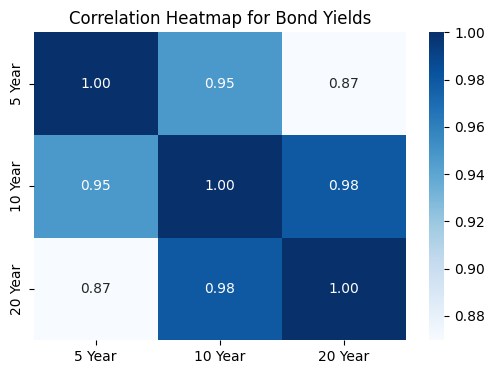

In [50]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_bonds[['5 Year', '10 Year', '20 Year']].corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap for Bond Yields')
plt.show()

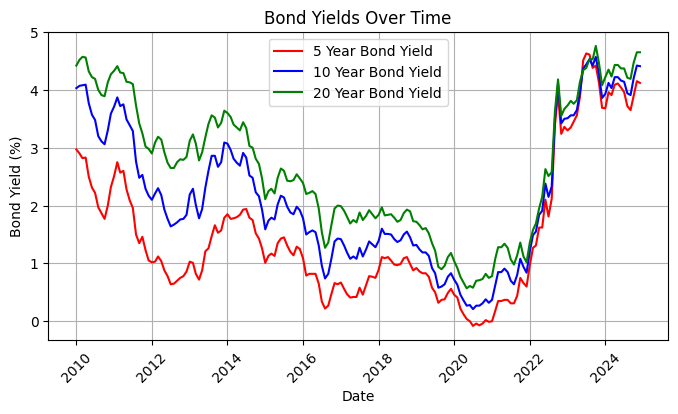

In [51]:
# Line Plot for Bond Yields Over Time without the mean
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_bonds, x='YYMM', y='5 Year', label='5 Year Bond Yield', color='red')
sns.lineplot(data=df_bonds, x='YYMM', y='10 Year', label='10 Year Bond Yield', color='blue')
sns.lineplot(data=df_bonds, x='YYMM', y='20 Year', label='20 Year Bond Yield', color='green')
plt.title('Bond Yields Over Time')
plt.xlabel('Date')
plt.ylabel('Bond Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\4280660115.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_melted_bds, x='Year', y='Amount', hue='Type', marker='o', palette='Set1', ci=None)


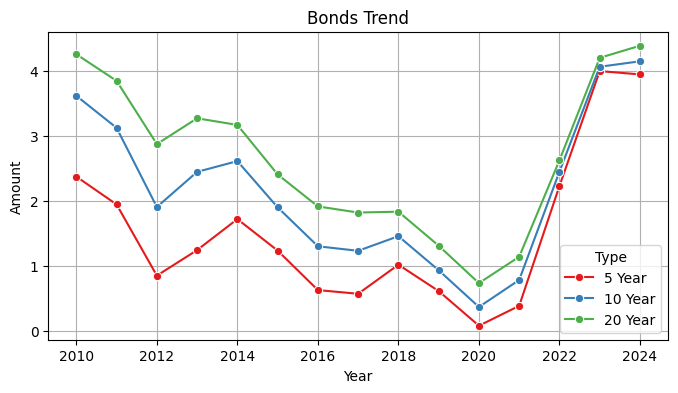

In [52]:
# Line Plot for Bond Yields Over Time with the mean

df_melted_bds = df_bonds.melt(id_vars='Year', value_vars=['5 Year', '10 Year', '20 Year'], var_name='Type', value_name='Amount')

plt.figure(figsize=(8, 4))
sns.lineplot(data=df_melted_bds, x='Year', y='Amount', hue='Type', marker='o', palette='Set1', ci=None) 
plt.title('Bonds Trend')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

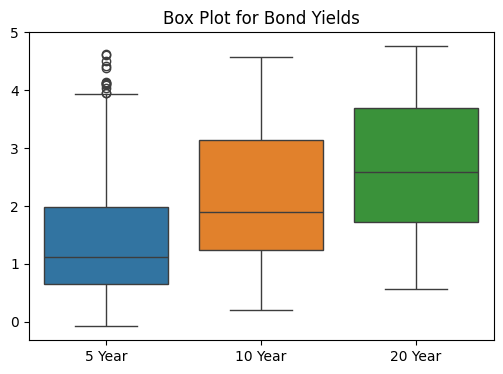

In [53]:
# Box Plot to Detect Outliers for Bond Yields
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_bonds[['5 Year', '10 Year', '20 Year']])
plt.title('Box Plot for Bond Yields')
plt.show()

## Consumer Price Index (CPI)

In [54]:
df_cpi = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="cpi")
df_cpi

YYMM    CPI  CPI Annual Growth Rate
0    2024/11  134.6                     3.5
1    2024/10  134.3                     3.1
2    2024/09  133.5                     2.6
3    2024/08  133.4                     3.1
4    2024/07  132.9                     3.0
..       ...    ...                     ...
174  2010/05   89.4                     3.5
175  2010/04   89.2                     3.7
176  2010/03   88.7                     3.4
177  2010/02   88.2                     3.0
178  2010/01   87.8                     3.4

[179 rows x 3 columns]

In [55]:
df_cpi['YYMM'] = pd.to_datetime(df_cpi['YYMM'], errors='coerce')
    
# Extracting time-based features
df_cpi['Year'] = df_cpi['YYMM'].dt.year
df_cpi['Month'] = df_cpi['YYMM'].dt.month

yearly_data_cpi = df_cpi.groupby('Year').agg({
    'CPI': 'mean',
    'CPI Annual Growth Rate': 'mean'
}).reset_index()

yearly_data_cpi

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\1896428585.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cpi['YYMM'] = pd.to_datetime(df_cpi['YYMM'], errors='coerce')


Year         CPI  CPI Annual Growth Rate
0   2010   89.433333                3.291667
1   2011   93.425000                4.466667
2   2012   96.041667                2.808333
3   2013   98.508333                2.558333
4   2014   99.958333                1.458333
5   2015  100.008333                0.050000
6   2016  100.941667                0.933333
7   2017  103.583333                2.625000
8   2018  105.958333                2.283333
9   2019  107.800000                1.741667
10  2020  108.866667                0.983333
11  2021  111.608333                2.500000
12  2022  120.450000                7.900000
13  2023  128.633333                6.841667
14  2024  132.636364                3.245455

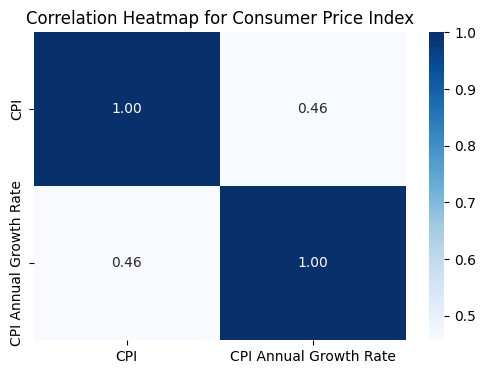

In [154]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_cpi[['CPI', 'CPI Annual Growth Rate']].corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap for Consumer Price Index')
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\2521605879.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cpi, x='Year', y='CPI', palette='viridis')


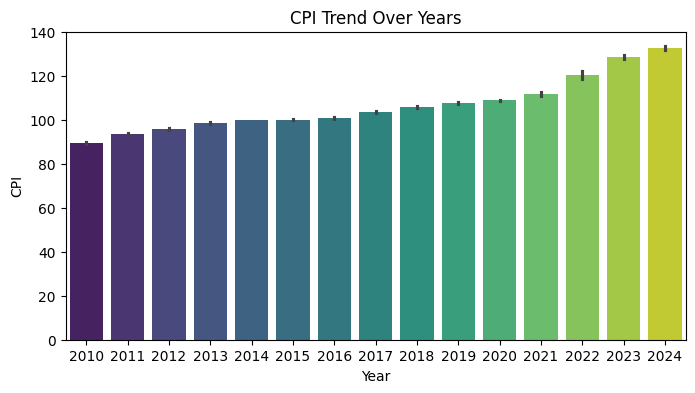

In [57]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df_cpi, x='Year', y='CPI', palette='viridis')
plt.title('CPI Trend Over Years')
plt.xticks(rotation=0)
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\490504946.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cpi, x='Year', y='CPI Annual Growth Rate', palette='viridis')


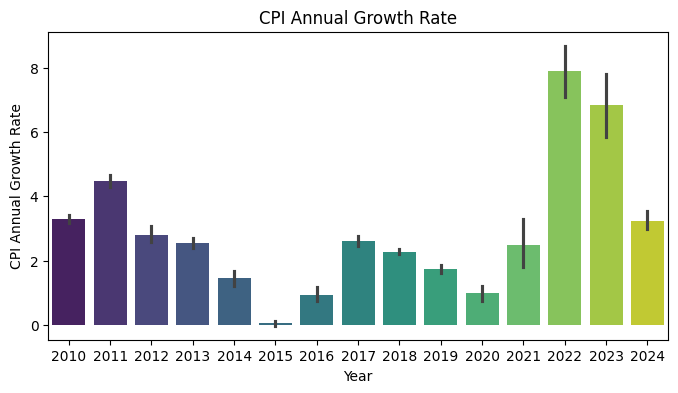

In [58]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df_cpi, x='Year', y='CPI Annual Growth Rate', palette='viridis')
plt.title('CPI Annual Growth Rate')
plt.xticks(rotation=0)
plt.show()

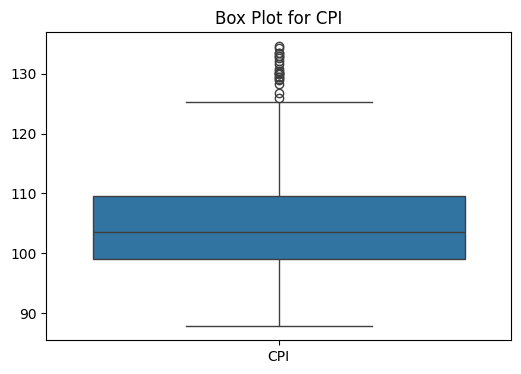

In [150]:
# Box Plot to Detect Outliers for CPI
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_cpi[['CPI']])
plt.title('Box Plot for CPI')
plt.show()

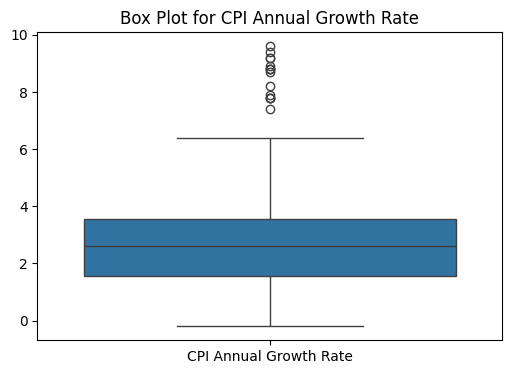

In [149]:
# Box Plot to Detect Outliers for CPI
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_cpi[['CPI Annual Growth Rate']])
plt.title('Box Plot for CPI Annual Growth Rate')
plt.show()

## Economic Growth

In [61]:
df_economic_growth = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="economic_growth")
df_economic_growth

YYMM  GBP to USD Exchange Rate  Economic Growth Rate
0    2025/01                    1.2362                   NaN
1    2024/12                    1.2514                   NaN
2    2024/11                    1.2736                   NaN
3    2024/10                    1.2898                   NaN
4    2024/09                    1.3374                   0.9
..       ...                       ...                   ...
176  2010/05                    1.4541                   2.4
177  2010/04                    1.5300                   2.4
178  2010/03                    1.5172                   1.0
179  2010/02                    1.5249                   1.0
180  2010/01                    1.5982                   1.0

[181 rows x 3 columns]

In [62]:
df_economic_growth['YYMM'] = pd.to_datetime(df_economic_growth['YYMM'], errors='coerce')
    
# Extracting time-based features
df_economic_growth['Year'] = df_economic_growth['YYMM'].dt.year
df_economic_growth['Month'] = df_economic_growth['YYMM'].dt.month
# df_economic_growth

# Filling missing values with the mean of the respective year

df_economic_growth.update(df_economic_growth.groupby('Year').transform(lambda x: x.fillna(x.mean())))

df_economic_growth = df_economic_growth.round(1)

df_economic_growth.fillna(0.6, inplace=True) # Filling the remaining missing values of 2025 with the value of 2024

df_economic_growth

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\2628242235.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_economic_growth['YYMM'] = pd.to_datetime(df_economic_growth['YYMM'], errors='coerce')


YYMM  GBP to USD Exchange Rate  Economic Growth Rate  Year  Month
0   2025-01-01                       1.2                   0.6  2025      1
1   2024-12-01                       1.3                   0.6  2024     12
2   2024-11-01                       1.3                   0.6  2024     11
3   2024-10-01                       1.3                   0.6  2024     10
4   2024-09-01                       1.3                   0.9  2024      9
..         ...                       ...                   ...   ...    ...
176 2010-05-01                       1.5                   2.4  2010      5
177 2010-04-01                       1.5                   2.4  2010      4
178 2010-03-01                       1.5                   1.0  2010      3
179 2010-02-01                       1.5                   1.0  2010      2
180 2010-01-01                       1.6                   1.0  2010      1

[181 rows x 5 columns]

In [63]:
yearly_data_eg = df_economic_growth.groupby('Year').agg({
    'GBP to USD Exchange Rate': 'mean',
    'Economic Growth Rate': 'mean'
}).reset_index()

yearly_data_eg.round(3)

Year  GBP to USD Exchange Rate  Economic Growth Rate
0   2010                     1.550                 2.250
1   2011                     1.608                 1.125
2   2012                     1.592                 1.500
3   2013                     1.567                 1.800
4   2014                     1.658                 3.200
5   2015                     1.517                 2.225
6   2016                     1.333                 1.925
7   2017                     1.308                 2.650
8   2018                     1.333                 1.425
9   2019                     1.275                 1.625
10  2020                     1.283               -10.300
11  2021                     1.383                 9.475
12  2022                     1.225                 5.000
13  2023                     1.250                 0.375
14  2024                     1.292                 0.625
15  2025                     1.200                 0.600

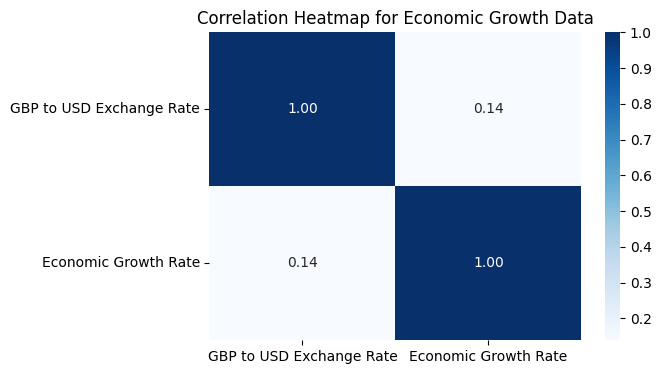

In [64]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_economic_growth[['GBP to USD Exchange Rate', 'Economic Growth Rate']].corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap for Economic Growth Data')
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\1073908789.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_economic_growth, x='Year', y='Economic Growth Rate', marker='o', palette='Set1',ci=None)
C:\Users\neera\AppData\Local\Temp\ipykernel_15812\1073908789.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_economic_growth, x='Year', y='Economic Growth Rate', marker='o', palette='Set1',ci=None)


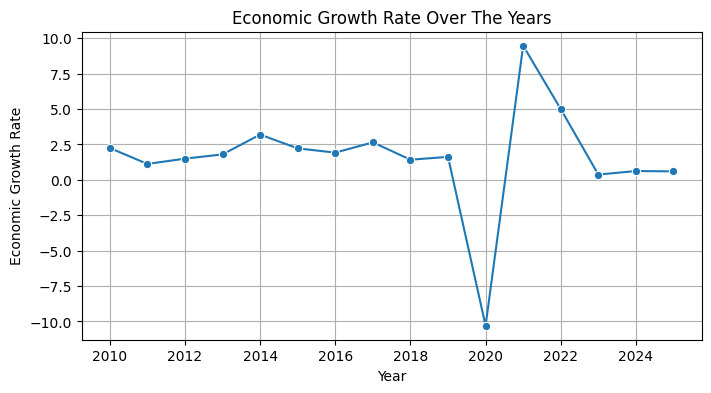

In [65]:
# df_melted_eg = df_economic_growth.melt(id_vars='Year', value_vars=['GBP to USD Exchange Rate', 'Economic Growth Rate'], var_name='Type', value_name='Amount')

plt.figure(figsize=(8, 4))
sns.lineplot(data=df_economic_growth, x='Year', y='Economic Growth Rate', marker='o', palette='Set1',ci=None)
plt.title('Economic Growth Rate Over The Years')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\1373195823.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_economic_growth, x='Year', y='GBP to USD Exchange Rate', marker='o', ci=None)


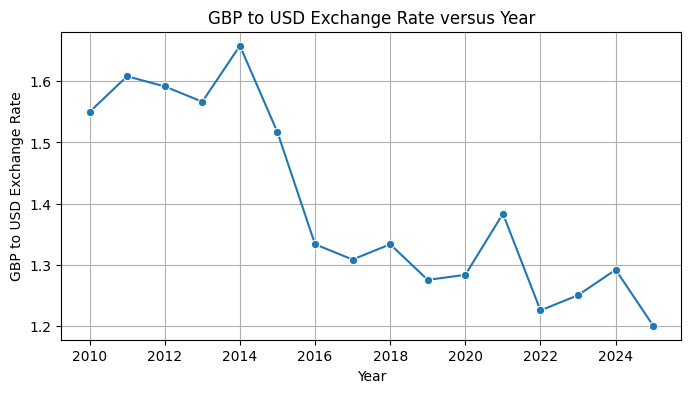

In [66]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_economic_growth, x='Year', y='GBP to USD Exchange Rate', marker='o', ci=None)
plt.title('GBP to USD Exchange Rate versus Year')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

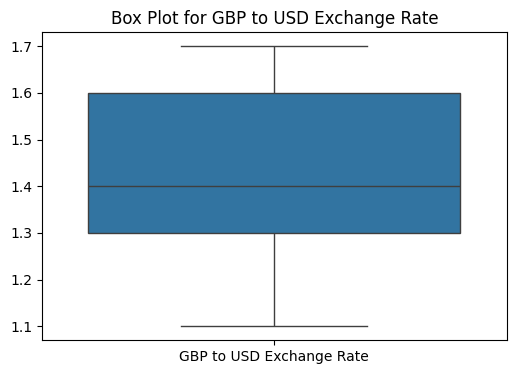

In [157]:
# Box Plot to Detect Outliers for Economic Growth Rate
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_economic_growth[['GBP to USD Exchange Rate']])
plt.title('Box Plot for GBP to USD Exchange Rate')
plt.show()

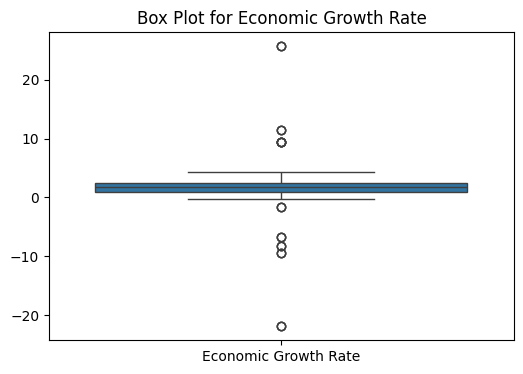

In [156]:
# Box Plot to Detect Outliers for Economic Growth Rate
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_economic_growth[['Economic Growth Rate']])
plt.title('Box Plot for Economic Growth Rate')
plt.show()

## Import And Export

In [68]:
df_import_export = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="import_export")
df_import_export

YYMM  Import  Export
0    2024/10   47397   28428
1    2024/09   44781   28460
2    2024/08   47776   32564
3    2024/07   47732   29051
4    2024/06   51143   31854
..       ...     ...     ...
173  2010/05   29586   21658
174  2010/04   29378   21942
175  2010/03   29824   21572
176  2010/02   27422   21749
177  2010/01   27752   19618

[178 rows x 3 columns]

In [69]:
df_import_export['YYMM'] = pd.to_datetime(df_import_export['YYMM'], errors='coerce')
    
# Extracting time-based features
df_import_export['Year'] = df_import_export['YYMM'].dt.year
df_import_export['Month'] = df_import_export['YYMM'].dt.month

yearly_data_ie = df_import_export.groupby('Year').agg({
    'Import': 'mean',
    'Export': 'mean'
}).reset_index()

yearly_data_ie.round()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\1427408382.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_import_export['YYMM'] = pd.to_datetime(df_import_export['YYMM'], errors='coerce')


Year   Import   Export
0   2010  30442.0  22158.0
1   2011  33882.0  25214.0
2   2012  34253.0  24869.0
3   2013  35391.0  24978.0
4   2014  35025.0  24098.0
5   2015  33852.0  23409.0
6   2016  36561.0  24950.0
7   2017  39979.0  28327.0
8   2018  41274.0  29500.0
9   2019  42767.0  30684.0
10  2020  36813.0  26146.0
11  2021  41195.0  27678.0
12  2022  53388.0  36177.0
13  2023  48433.0  32793.0
14  2024  47504.0  30401.0

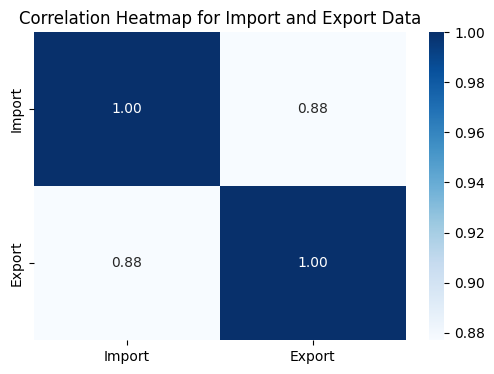

In [70]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_import_export[['Import', 'Export']].corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap for Import and Export Data')
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\511492863.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_melted_ie, x='Year', y='Amount', hue='Type', marker='o', ci=None)


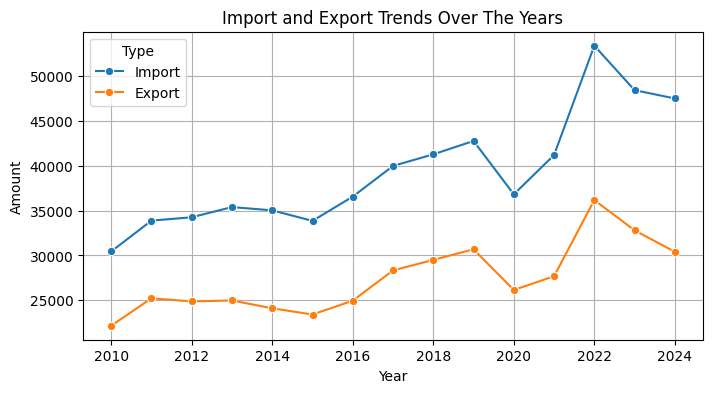

In [71]:
df_melted_ie = df_import_export.melt(id_vars='Year', value_vars=['Import', 'Export'], var_name='Type', value_name='Amount')

plt.figure(figsize=(8, 4))
sns.lineplot(data=df_melted_ie, x='Year', y='Amount', hue='Type', marker='o', ci=None)
plt.title('Import and Export Trends Over The Years') 
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\136535988.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_melted_ie, x='YYMM', y='Amount', hue='Type', ci=None)


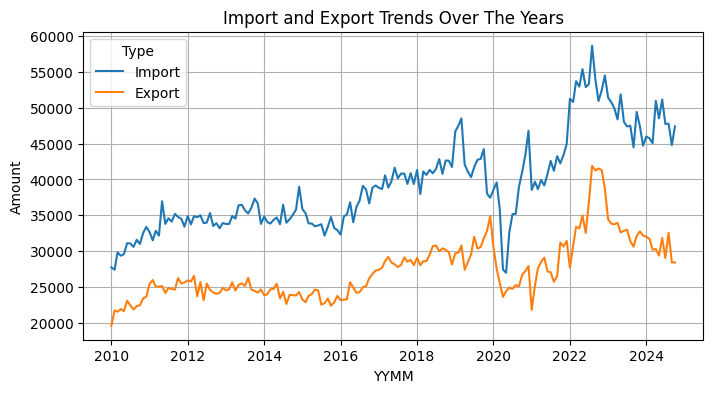

In [72]:
df_melted_ie = df_import_export.melt(id_vars='YYMM', value_vars=['Import', 'Export'], var_name='Type', value_name='Amount')

plt.figure(figsize=(8, 4))
sns.lineplot(data=df_melted_ie, x='YYMM', y='Amount', hue='Type', ci=None)
plt.title('Import and Export Trends Over The Years') 
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

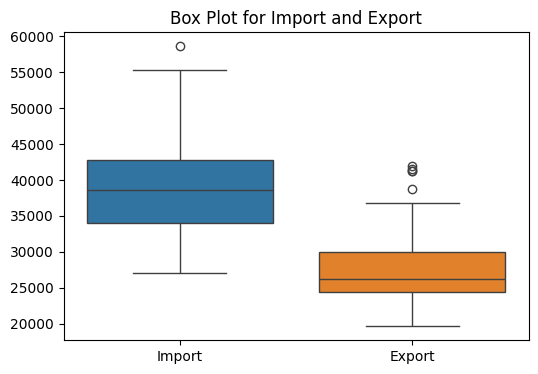

In [73]:
# Box Plot to Detect Outliers for Import and Export
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_import_export[['Import', 'Export']])
plt.title('Box Plot for Import and Export')
plt.show()

## UK Home Retail

In [74]:
df_uk_home_retail = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="uk_home_retail")
df_uk_home_retail

Date  UK Home Sales      United Kingdom      Great Britain  \
0   Sep 2024            NaN               49713              47722   
1   Aug 2024            NaN               59319              57328   
2   Jul 2024            NaN               61319              59328   
3   Jun 2024            NaN               55893              54088   
4   May 2024            NaN               62193              60388   
..       ...            ...                 ...                ...   
75  Jun 2018            NaN               96025              93958   
76  May 2018            NaN               81591              79524   
77  Jul 2018            NaN               89227              87036   
78  Jun 2018            NaN               96025              93958   
79  May 2018            NaN               81591              79524   

        England      Scotland      Northern Ireland      East Midlands  \
0         37258          8360                  1991               3335   
1         44874          9879                  1991               4042   
2         47862          8728                  1991               4248   
3         43022          8599                  1805               3793   
4         48601          9115                  1805               4379   
..          ...           ...                   ...                ...   
75        79056         10558                  2067               7605   
76        67590          8135                  2067               6536   
77        73910          8899                  2191               6802   
78        79056         10558                  2067               7605   
79        67590          8135                  2067               6536   

        London      North East England  ...              Northern Ireland  \
0         4228                    1766  ...                            --   
1         5433                    2210  ...                            --   
2         5953                    2303  ...                            --   
3         5085                    2206  ...                            --   
4         5705                    2583  ...                            --   
..         ...                     ...  ...                           ...   
75        8135                    4050  ...                           NaN   
76        6980                    3301  ...                           NaN   
77        8303                    3460  ...                           NaN   
78        8135                    4050  ...                           NaN   
79        6980                    3301  ...                           NaN   

                North West England              Scotland  \
0                               --                    --   
1                               --                    --   
2                               --                    --   
3                               --                    --   
4                               --                    --   
..                             ...                   ...   
75                             NaN                   NaN   
76                             NaN                   NaN   
77                             NaN                   NaN   
78                             NaN                   NaN   
79                             NaN                   NaN   

                South West England              Wales  \
0                               --                 --   
1                               --                 --   
2                               --                 --   
3                               --                 --   
4                               --                 --   
..                             ...                ...   
75                             NaN                NaN   
76                             NaN                NaN   
77                             NaN                NaN   
78                             NaN                NaN   
79   

In [75]:
df_uk_home_retail.columns

Index(['Date', 'UK Home Sales', '    United Kingdom', '    Great Britain',
       '    England', '    Scotland', '    Northern Ireland',
       '    East Midlands', '    London', '    North East England',
       ...
       '            Northern Ireland', '            North West England',
       '            Scotland', '            South West England',
       '            Wales', '            West Midlands',
       '            Yorkshire and Humberside', '            Northern',
       '            Outer South East', '            Outer Metropolitan Area'],
      dtype='object', length=475)

In [158]:
df_uk_home_retail['Date'] = pd.to_datetime(df_uk_home_retail['Date'], errors='coerce')
    
# Extracting time-based features
df_uk_home_retail['Year'] = df_uk_home_retail['Date'].dt.year
df_uk_home_retail['Month'] = df_uk_home_retail['Date'].dt.month

yearly_data_uhr = df_uk_home_retail.groupby('Year').agg({
    '    United Kingdom' : 'mean',
    '    Great Britain' : 'mean',
    '    England' : 'mean',
    '    Scotland' : 'mean',
    '    Northern Ireland' : 'mean',
}).reset_index()

yearly_data_uhr.round()

Year      United Kingdom      Great Britain      England      Scotland  \
0  2018             90437.0            88273.0      74794.0        9185.0   
1  2019             82552.0            80474.0      67994.0        8571.0   
2  2020             69342.0            67573.0      57180.0        7411.0   
3  2021            104459.0           101897.0      87794.0        9502.0   
4  2022             87135.0            85027.0      72432.0        8633.0   
5  2023             64806.0            63004.0      52445.0        7650.0   
6  2024             56304.0            54504.0      44082.0        7989.0   

       Northern Ireland  
0                2164.0  
1                2078.0  
2                1770.0  
3                2562.0  
4                2108.0  
5                1802.0  
6                1800.0

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\4259021286.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_uk_home_retail, x='Year', y='    United Kingdom', palette='viridis')


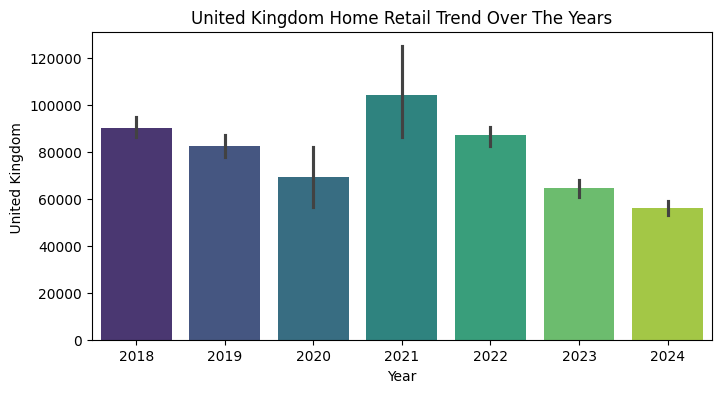

In [77]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df_uk_home_retail, x='Year', y='    United Kingdom', palette='viridis')
plt.title('United Kingdom Home Retail Trend Over The Years') 
plt.xticks(rotation=0)
plt.show()

## Seasonal Retail Sales

In [78]:
df_seasonal_retail_sales = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="seasonal_retail_sales")
df_seasonal_retail_sales

YYMM  Retail Sale Volume Index  Revenue  Unnamed: 3
0    2024/11                      98.4      NaN         NaN
1    2024/10                      98.2      NaN         NaN
2    2024/09                      98.9      NaN         NaN
3    2024/08                      99.1      NaN         NaN
4    2024/07                      98.2      NaN         NaN
..       ...                       ...      ...         ...
174  2010/05                      83.6   570.64         NaN
175  2010/04                      83.4   570.64         NaN
176  2010/03                      83.0   570.64         NaN
177  2010/02                      83.4   570.64         NaN
178  2010/01                      80.9   570.64         NaN

[179 rows x 4 columns]

In [79]:
df_seasonal_retail_sales.drop(columns='Unnamed: 3', inplace=True) # dropping the 3rd column as it has no name and no data

In [80]:
# Convert 'Date' to datetime and extract year and month
df_seasonal_retail_sales['YYMM'] = pd.to_datetime(df_seasonal_retail_sales['YYMM'], errors='coerce')
df_seasonal_retail_sales['Year'] = df_seasonal_retail_sales['YYMM'].dt.year
df_seasonal_retail_sales['Month'] = df_seasonal_retail_sales['YYMM'].dt.month

# Compute 2023 monthly averages
monthly_avg_2023 = df_seasonal_retail_sales[df_seasonal_retail_sales['Year'] == 2023].groupby('Month').mean()

# # Fill NaN values in 2024 with 2023 monthly averages
# for month, row_avg in monthly_avg_2023.iterrows():
#     mask = (df_seasonal_retail_sales['Year'] == 2024) & (df_seasonal_retail_sales['Month'] == month)
#     df_seasonal_retail_sales.loc[mask] = df_seasonal_retail_sales.loc[mask].fillna(row_avg)


# Fill NaN values in 2024 with corresponding monthly averages from 2023
df_seasonal_retail_sales.loc[df_seasonal_retail_sales['Year'] == 2024] = (
    df_seasonal_retail_sales[df_seasonal_retail_sales['Year'] == 2024]
    .apply(lambda row: row.fillna(monthly_avg_2023.loc[row['Month']]), axis=1)
)

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\1225602716.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_seasonal_retail_sales['YYMM'] = pd.to_datetime(df_seasonal_retail_sales['YYMM'], errors='coerce')
C:\Users\neera\AppData\Local\Temp\ipykernel_15812\1225602716.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2024 2024 2024 2024 2024 2024 2024 2024 2024 2024 2024]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_seasonal_retail_sales.loc[df_seasonal_retail_sales['Year'] == 2024] = (
C:\Users\neera\AppData\Local\Temp\ipykernel_15812\1225602716.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[11 10  9  8  7  6  5  4  3  2

In [81]:
yearly_data_srs = df_seasonal_retail_sales.groupby('Year').agg({
    'Retail Sale Volume Index' : 'mean',
    'Revenue' : 'mean',
}).reset_index()

yearly_data_srs.round(2)

Year  Retail Sale Volume Index  Revenue
0   2010                     82.93   570.64
1   2011                     82.29   600.04
2   2012                     82.54   618.00
3   2013                     83.37   649.54
4   2014                     86.27   663.27
5   2015                     89.95   686.19
6   2016                     94.24   722.88
7   2017                     95.74   763.28
8   2018                     97.80   787.72
9   2019                    100.90   809.86
10  2020                     99.32   774.33
11  2021                    104.16   868.38
12  2022                    100.06   994.39
13  2023                     97.18  1039.26
14  2024                     97.97  1039.26

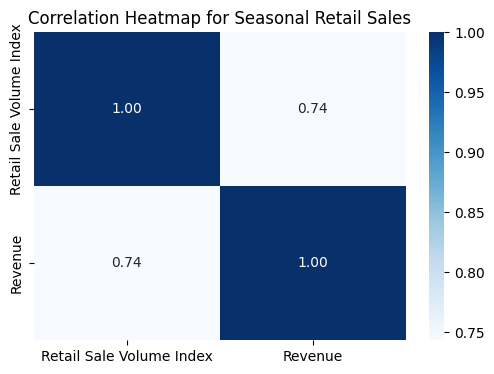

In [82]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_seasonal_retail_sales[['Retail Sale Volume Index', 'Revenue']].corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap for Seasonal Retail Sales')
plt.show()

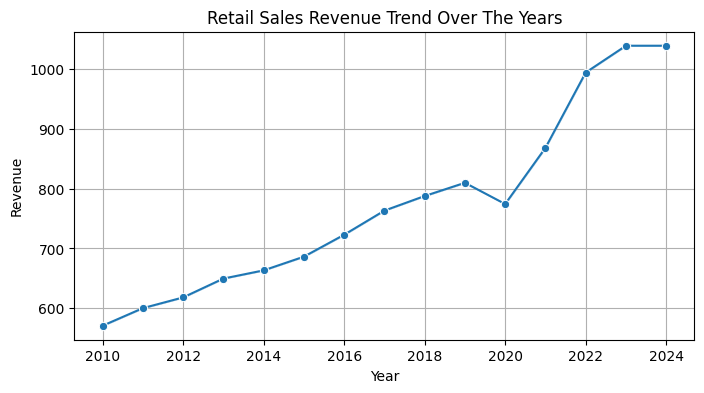

In [83]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_seasonal_retail_sales, x='Year', y='Revenue', marker='o')
plt.title('Retail Sales Revenue Trend Over The Years') 
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\154546203.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_seasonal_retail_sales, x='Year', y='Retail Sale Volume Index', palette='viridis')


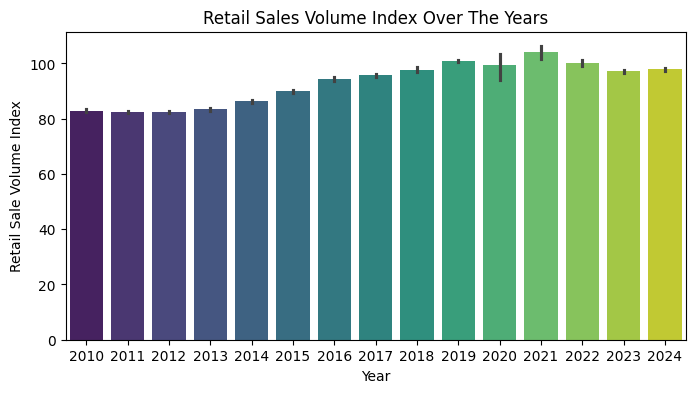

In [84]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df_seasonal_retail_sales, x='Year', y='Retail Sale Volume Index', palette='viridis')
plt.title('Retail Sales Volume Index Over The Years') 
plt.xticks(rotation=0)
plt.show()

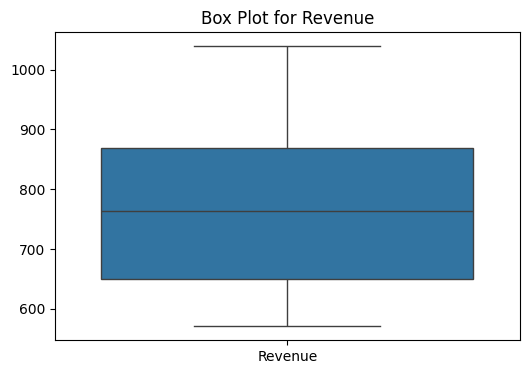

In [159]:
# Box Plot to Detect Outliers for Retail Sales Revenue
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_seasonal_retail_sales[['Revenue']])
plt.title('Box Plot for Revenue')
plt.show()

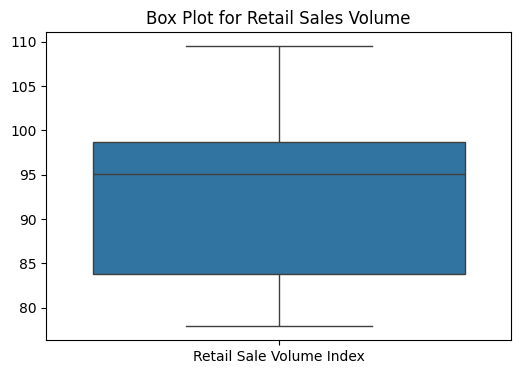

In [160]:
# Box Plot to Detect Outliers for Retail Sales Revenue
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_seasonal_retail_sales[['Retail Sale Volume Index']])
plt.title('Box Plot for Retail Sales Volume')
plt.show()

## UK Building

In [86]:
df_uk_building = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="uk_building")
df_uk_building

Date  Building (Housing) Starts  Building Completions  \
0   Q2 2024                      22990                 43030   
1   Q1 2024                      22580                 37620   
2   Q4 2023                      20270                 40120   
3   Q3 2023                      21210                 41640   
4   Q2 2023                      66060                 38930   
5   Q1 2023                      36820                 41330   
6   Q4 2022                      40040                 45660   
7   Q3 2022                      45850                 42330   
8   Q2 2022                      51990                 44990   
9   Q1 2022                      41230                 45340   
10  Q4 2021                      43540                 41000   
11  Q3 2021                      44990                 42900   
12  Q2 2021                      44280                 42570   
13  Q1 2021                      45360                 49430   
14  Q4 2020                      44070                 46070   
15  Q3 2020                      37870                 44340   
16  Q2 2020                      16630                 16120   
17  Q1 2020                      34190                 40420   
18  Q4 2019                      35290                 44420   
19  Q3 2019                      40530                 45510   
20  Q2 2019                      38040                 44580   
21  Q1 2019                      38840                 43330   
22  Q4 2018                      42430                 43530   
23  Q3 2018                      44690                 41410   
24  Q2 2018                      40070                 40790   
25  Q1 2018                      41440                 39130   
26  Q4 2017                      42990                 41270   
27  Q3 2017                      38930                 39970   
28  Q2 2017                      41280                 40360   
29  Q1 2017                      41280                 40480   
30  Q4 2016                      40360                 34470   
31  Q3 2016                      39910                 38860   
32  Q2 2016                      38420                 34740   
33  Q1 2016                      36460                 33740   
34  Q4 2015                      36950                 35420   
35  Q3 2015                      35580                 35040   
36  Q2 2015                      35010                 35720   
37  Q1 2015                      40790                 35780   
38  Q4 2014                      31110                 29690   
39  Q3 2014                      34650                 30340   
40  Q2 2014                      36320                 29150   
41  Q1 2014                      37980                 28430   

        Local Authorities  
0                     610  
1                    1090  
2                     760  
3                     620  
4                     390  
5                     590  
6                     810  
7                     290  
8                     280  
9                     240  
10                    500  
11                    270  
12                    290  
13                    530  
14                    620  
15                    350  
16                    110  
17                    190  
18                    310  
19                    850  
20                    500  
21                    530  
22                    600  
23                    700  
24                    730  
25                    650  
26                    600  
27                    360  
28                    410  
29                    380  
30                    430  
31                    420  
32                    610  
33                    650  
34                    470  
35                    350  
36                    440  
37                    400  
38                    320  
39                    350  
40                    290  
41                    220

In [87]:
# Extract year and quarter separately
df_uk_building[['Quarter', 'Year']] = df_uk_building['Date'].str.extract(r'(Q\d)\s*(\d{4})')

df_uk_building

Date  Building (Housing) Starts  Building Completions  \
0   Q2 2024                      22990                 43030   
1   Q1 2024                      22580                 37620   
2   Q4 2023                      20270                 40120   
3   Q3 2023                      21210                 41640   
4   Q2 2023                      66060                 38930   
5   Q1 2023                      36820                 41330   
6   Q4 2022                      40040                 45660   
7   Q3 2022                      45850                 42330   
8   Q2 2022                      51990                 44990   
9   Q1 2022                      41230                 45340   
10  Q4 2021                      43540                 41000   
11  Q3 2021                      44990                 42900   
12  Q2 2021                      44280                 42570   
13  Q1 2021                      45360                 49430   
14  Q4 2020                      44070                 46070   
15  Q3 2020                      37870                 44340   
16  Q2 2020                      16630                 16120   
17  Q1 2020                      34190                 40420   
18  Q4 2019                      35290                 44420   
19  Q3 2019                      40530                 45510   
20  Q2 2019                      38040                 44580   
21  Q1 2019                      38840                 43330   
22  Q4 2018                      42430                 43530   
23  Q3 2018                      44690                 41410   
24  Q2 2018                      40070                 40790   
25  Q1 2018                      41440                 39130   
26  Q4 2017                      42990                 41270   
27  Q3 2017                      38930                 39970   
28  Q2 2017                      41280                 40360   
29  Q1 2017                      41280                 40480   
30  Q4 2016                      40360                 34470   
31  Q3 2016                      39910                 38860   
32  Q2 2016                      38420                 34740   
33  Q1 2016                      36460                 33740   
34  Q4 2015                      36950                 35420   
35  Q3 2015                      35580                 35040   
36  Q2 2015                      35010                 35720   
37  Q1 2015                      40790                 35780   
38  Q4 2014                      31110                 29690   
39  Q3 2014                      34650                 30340   
40  Q2 2014                      36320                 29150   
41  Q1 2014                      37980                 28430   

        Local Authorities Quarter  Year  
0                     610      Q2  2024  
1                    1090      Q1  2024  
2                     760      Q4  2023  
3                     620      Q3  2023  
4                     390      Q2  2023  
5                     590      Q1  2023  
6                     810      Q4  2022  
7                     290      Q3  2022  
8                     280      Q2  2022  
9                     240      Q1  2022  
10                    500      Q4  2021  
11                    270      Q3  2021  
12                    290      Q2  2021  
13                    530      Q1  2021  
14                    620      Q4  2020  
15                    350      Q3  2020  
16                    110      Q2  2020  
17                    190      Q1  2020  
18                    310      Q4  2019  
19                    850      Q3  2019  
20                    500      Q2  2019  
21                    530      Q1  2019  
22                    600      Q4  2018  
23                    700      Q3  2018  
24                    730      Q2  2018  
25                    650      Q1  2018  
26                    600      Q4  2017  
27                    360      Q3  2017  
28                    410      Q2  2

In [89]:
yearly_data_ub = df_uk_building.groupby('Year').agg({
    'Building (Housing) Starts' : 'mean',
    'Building Completions' : 'mean',
    '    Local Authorities' : 'mean'
}).reset_index()

yearly_data_ub

Year  Building (Housing) Starts  Building Completions  \
0   2014                    35015.0               29402.5   
1   2015                    37082.5               35490.0   
2   2016                    38787.5               35452.5   
3   2017                    41120.0               40520.0   
4   2018                    42157.5               41215.0   
5   2019                    38175.0               44460.0   
6   2020                    33190.0               36737.5   
7   2021                    44542.5               43975.0   
8   2022                    44777.5               44580.0   
9   2023                    36090.0               40505.0   
10  2024                    22785.0               40325.0   

        Local Authorities  
0                   295.0  
1                   415.0  
2                   527.5  
3                   437.5  
4                   670.0  
5                   547.5  
6                   317.5  
7                   397.5  
8                   405.0  
9                   590.0  
10                  850.0

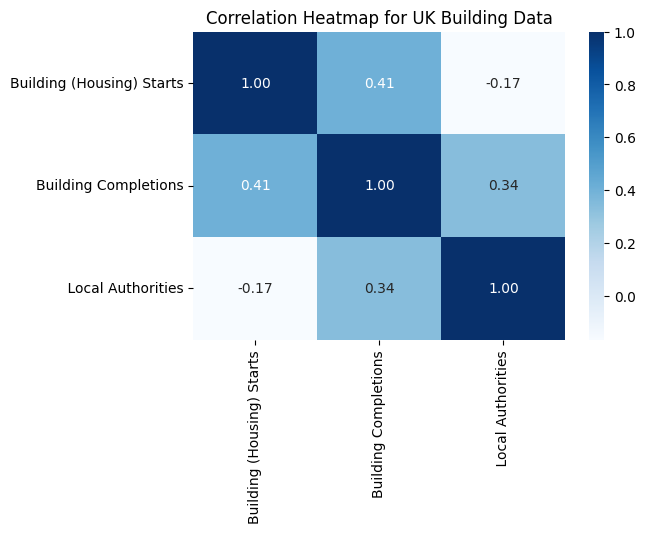

In [90]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_uk_building[['Building (Housing) Starts', 'Building Completions', '    Local Authorities']].corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap for UK Building Data')
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\4093968327.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_melted_ub, x='Year', y='Amount', hue='Type', marker='o', ci=None)


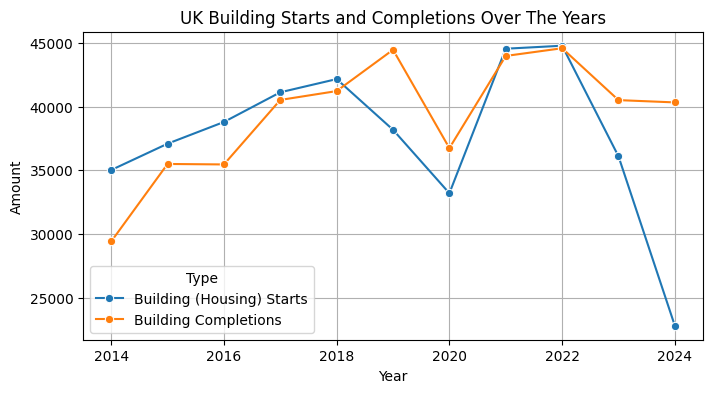

In [91]:
df_melted_ub = df_uk_building.melt(id_vars='Year', value_vars=['Building (Housing) Starts', 'Building Completions'], var_name='Type', value_name='Amount')
df_melted_ub['Year'] = pd.to_numeric(df_melted_ub['Year'])

plt.figure(figsize=(8, 4))
sns.lineplot(data=df_melted_ub, x='Year', y='Amount', hue='Type', marker='o', ci=None)
plt.title('UK Building Starts and Completions Over The Years')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

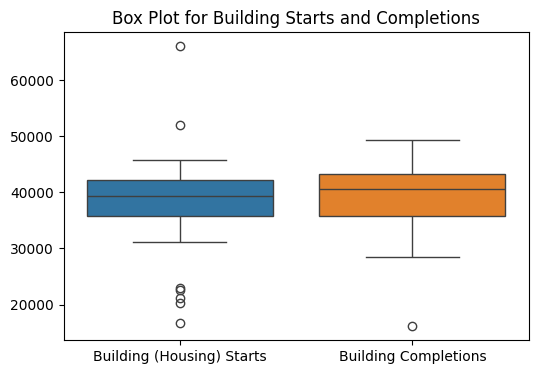

In [92]:
# Box Plot for Building Starts and Completions
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_uk_building[['Building (Housing) Starts', 'Building Completions']])
plt.title('Box Plot for Building Starts and Completions')
plt.show()

## Mortgage

In [93]:
df_mortage = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="mortage")
df_mortage

Date  All Lenders (GBP)  House Purchase  Remortgaging  \
0   Nov 2024              23049           16494          6728   
1   Oct 2024              23748           16753          6977   
2   Sep 2024              22679           15803          6677   
3   Aug 2024              21928           15451          5871   
4   Jul 2024              20997           14499          5166   
..       ...                ...             ...           ...   
74  Sep 2018              21640           12410          8778   
75  Aug 2018              22527           12505          9258   
76  Jul 2018              21432           12185          8138   
77  Jun 2018              22198           12319          8902   
78  May 2018              21989           12038          9249   

    Other Secured Lending  Monetary Financial Institutions  \
0                     637                            23017   
1                     700                            22914   
2                     696                            21088   
3                     612                            19808   
4                     579                            18729   
..                    ...                              ...   
74                    652                            20420   
75                    722                            20870   
76                    684                            19464   
77                    682                            20320   
78                    675                            20252   

    Other Specialist Lenders  
0                       1316  
1                       1299  
2                       1140  
3                       1163  
4                        955  
..                       ...  
74                      1417  
75                      1567  
76                      1492  
77                      1414  
78                      1371  

[79 rows x 7 columns]

In [94]:
df_mortage['Date'] = pd.to_datetime(df_mortage['Date'], errors='coerce')
    
# Extracting time-based features
df_mortage['Year'] = df_mortage['Date'].dt.year
df_mortage['Month'] = df_mortage['Date'].dt.month

df_mortage

yearly_data_m = df_mortage.groupby('Year').agg({
    'All Lenders (GBP)' : 'mean',
    'House Purchase' : 'mean',
    'Remortgaging' : 'mean',
    'Other Secured Lending' : 'mean',
    'Monetary Financial Institutions' : 'mean',
    'Other Specialist Lenders' : 'mean',
}).reset_index()

yearly_data_m.round()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\2101629735.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mortage['Date'] = pd.to_datetime(df_mortage['Date'], errors='coerce')


Year  All Lenders (GBP)  House Purchase  Remortgaging  \
0  2018            21659.0         12299.0        8760.0   
1  2019            22193.0         12725.0        8715.0   
2  2020            22117.0         14500.0        6941.0   
3  2021            25901.0         17113.0        7676.0   
4  2022            24921.0         14576.0        9489.0   
5  2023            17011.0         10544.0        5973.0   
6  2024            21727.0         14712.0        6380.0   

   Other Secured Lending  Monetary Financial Institutions  \
0                  686.0                          20273.0   
1                  712.0                          20820.0   
2                  668.0                          20515.0   
3                  915.0                          23966.0   
4                  901.0                          23331.0   
5                  533.0                          15909.0   
6                  629.0                          20428.0   

   Other Specialist Lenders  
0                    1452.0  
1                    1412.0  
2                    1455.0  
3                    1788.0  
4                    1432.0  
5                    1140.0  
6                    1297.0

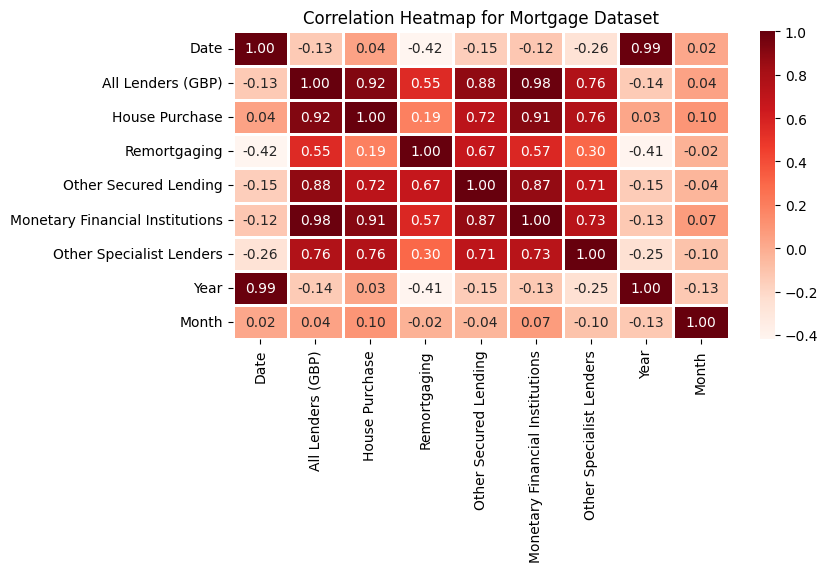

In [95]:
# Correlation Heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_mortage.corr(), annot=True, cmap='Reds', fmt=".2f", linewidths=1)
plt.title('Correlation Heatmap for Mortgage Dataset')
plt.show()

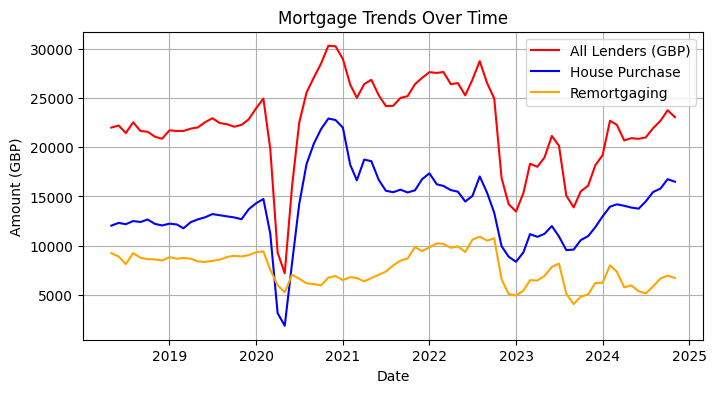

In [96]:
# Line Plot for Time-Series Analysis
plt.figure(figsize=(8, 4))
plt.plot(df_mortage['Date'], df_mortage['All Lenders (GBP)'], label='All Lenders (GBP)', color='red')
plt.plot(df_mortage['Date'], df_mortage['House Purchase'], label='House Purchase', color='blue')
plt.plot(df_mortage['Date'], df_mortage['Remortgaging'], label='Remortgaging', color='orange')
plt.xlabel('Date')
plt.ylabel('Amount (GBP)')
plt.title('Mortgage Trends Over Time')
plt.legend()
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\4245745169.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_melted_m, x='Year', y='Amount', hue='Type', marker='o', ci=None)


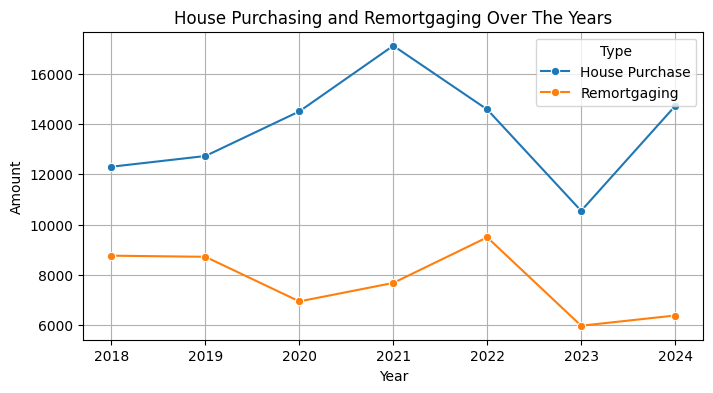

In [97]:
df_melted_m = df_mortage.melt(id_vars='Year', value_vars=['House Purchase', 'Remortgaging'], var_name='Type', value_name='Amount')

plt.figure(figsize=(8, 4))
sns.lineplot(data=df_melted_m, x='Year', y='Amount', hue='Type', marker='o', ci=None)
plt.title('House Purchasing and Remortgaging Over The Years')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

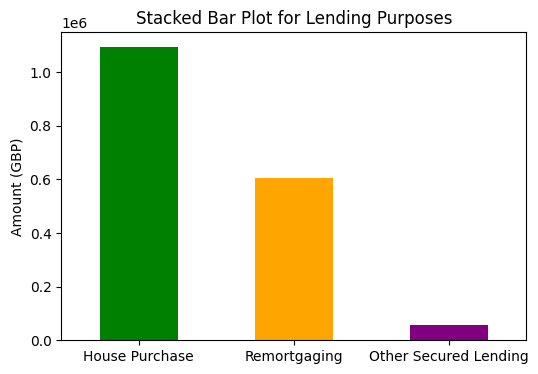

In [98]:
df_plot = df_mortage[['House Purchase', 'Remortgaging', 'Other Secured Lending']].sum()
df_plot.plot(kind='bar', stacked=True, figsize=(6, 4), color=['green', 'orange', 'purple'])
plt.title('Stacked Bar Plot for Lending Purposes')
plt.ylabel('Amount (GBP)')
plt.xticks(rotation=0)
plt.show()

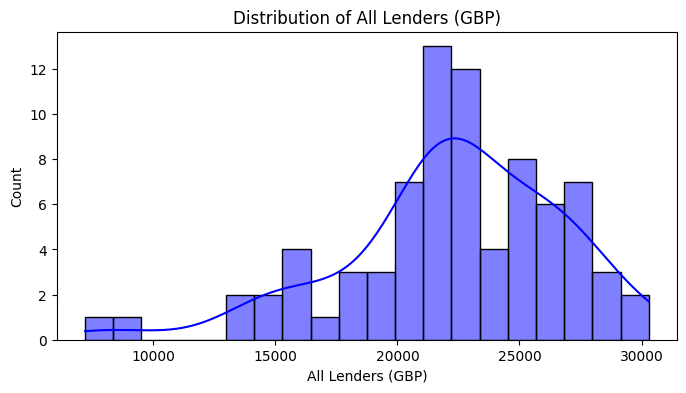

In [99]:
# Distribution Analysis
plt.figure(figsize=(8, 4))
sns.histplot(df_mortage['All Lenders (GBP)'], bins=20, kde=True, color='blue')
plt.title('Distribution of All Lenders (GBP)')
plt.show()

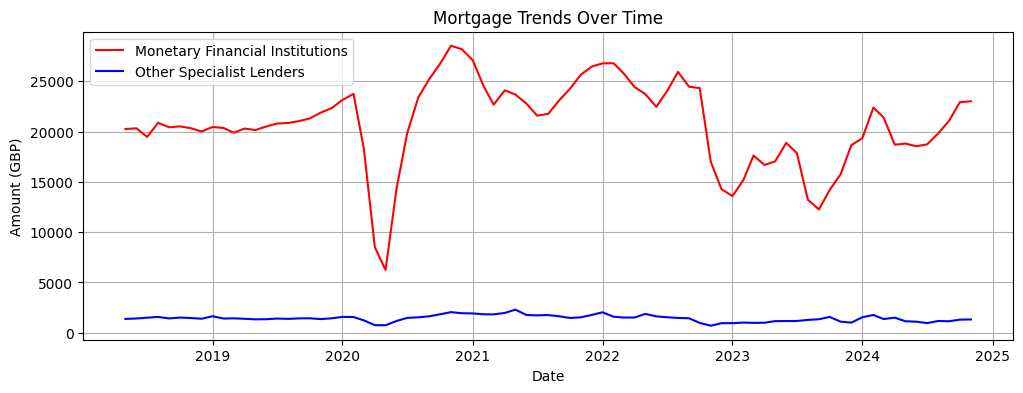

In [101]:
# Line Plot for Time-Series Analysis
plt.figure(figsize=(12, 4))
plt.plot(df_mortage['Date'], df_mortage['Monetary Financial Institutions'], label='Monetary Financial Institutions', color='red')
plt.plot(df_mortage['Date'], df_mortage['Other Specialist Lenders'], label='Other Specialist Lenders', color='blue')
# plt.plot(df_mortage['Date'], df_mortage['Remortgaging'], label='Remortgaging', color='orange')
plt.xlabel('Date')
plt.ylabel('Amount (GBP)')
plt.title('Mortgage Trends Over Time')
plt.legend(loc='upper left')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

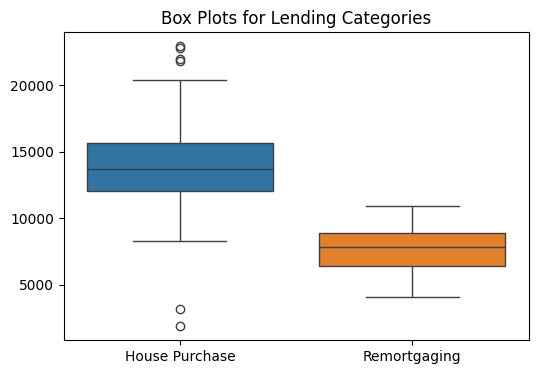

In [161]:
# Box Plots for Outlier Detection
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_mortage[['House Purchase', 'Remortgaging']])
plt.title('Box Plots for Lending Categories')
plt.show()

## UK Retail Price

In [103]:
df_uk_retail_price = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="uk_retail_price")
df_uk_retail_price

Date  Index of Private Housing Rental Prices     excluding London  \
0   Dec 2024                                     9.1                   --   
1   Nov 2024                                     9.1                   --   
2   Oct 2024                                     8.7                   --   
3   Sep 2024                                     8.4                   --   
4   Aug 2024                                     8.4                   --   
..       ...                                     ...                  ...   
75  Sep 2018                                     0.9                  1.5   
76  Aug 2018                                     0.8                  1.5   
77  Jul 2018                                     0.7                  1.5   
78  Jun 2018                                     0.7                  1.6   
79  May 2018                                     0.9                  1.6   

        England         excluding London          London          East  \
0           9.2                       --            11.5           8.4   
1           9.3                       --            11.6           8.4   
2           8.8                       --            10.4           8.0   
3           8.5                       --             9.8           7.9   
4           8.5                       --             9.6           7.6   
..          ...                      ...             ...           ...   
75          0.8                      1.6            -1.0           1.9   
76          0.7                      1.6            -1.3           2.0   
77          0.6                      1.6            -1.5           2.0   
78          0.6                      1.7            -1.6           2.1   
79          0.7                      1.7            -1.4           2.2   

            East Midlands          North East          South East England  \
0                     8.3                 8.9                         7.9   
1                     8.3                 8.4                         8.2   
2                     9.1                 7.7                         8.2   
3                     8.8                 7.3                         7.9   
4                     9.2                 6.7                         7.7   
..                    ...                 ...                         ...   
75                    4.2                 0.4                         1.2   
76                    3.2                 0.3                         1.2   
77                    3.5                 0.3                         1.3   
78                    3.7                 0.4                         1.3   
79                    3.6                 0.0                         1.3   

            North West          South West England          West Midlands  \
0                  9.6                         6.9                    8.7   
1                 10.0                         6.5                    8.7   
2                  9.7                         6.2                    8.7   
3                  9.3                         6.3                    8.8   
4                  9.2                         6.4                    9.2   
..                 ...                         ...                    ...   
75                 2.4                         1.8                    2.0   
76                 2.6                         2.0                    2.0   
77                 2.4                         2.0                    2.1   
78                 2.5                         2.1                    2.4   
79                 2.5                         2.3                    2.8   

            Yorkshire and Humberside      Scotland      Wales  
0                                5.4           6.9        8.5  
1                                5.7           6.5        8.0  
2                                5.9           6.6        7.9  
3                                6.3           7.2        8.3  
4                       

In [104]:
df_uk_retail_price['Date'] = pd.to_datetime(df_uk_retail_price['Date'], errors='coerce')
    
# Extracting time-based features
df_uk_retail_price['Year'] = df_uk_retail_price['Date'].dt.year
df_uk_retail_price['Month'] = df_uk_retail_price['Date'].dt.month

# df_uk_retail_price


C:\Users\neera\AppData\Local\Temp\ipykernel_15812\1050794956.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_uk_retail_price['Date'] = pd.to_datetime(df_uk_retail_price['Date'], errors='coerce')


In [105]:

yearly_data_urp = df_uk_retail_price.groupby('Year').agg({
    'Index of Private Housing Rental Prices' : 'mean',
    '    England' : 'mean',
    # '    excluding London' : 'mean',
    # '        excluding London' : 'mean'
}).reset_index()

yearly_data_urp

Year  Index of Private Housing Rental Prices      England
0  2018                                0.912500     0.800000
1  2019                                1.900000     1.850000
2  2020                                1.725000     1.675000
3  2021                                1.308333     1.250000
4  2022                                4.225000     4.175000
5  2023                                7.333333     7.150000
6  2024                                8.750000     8.766667

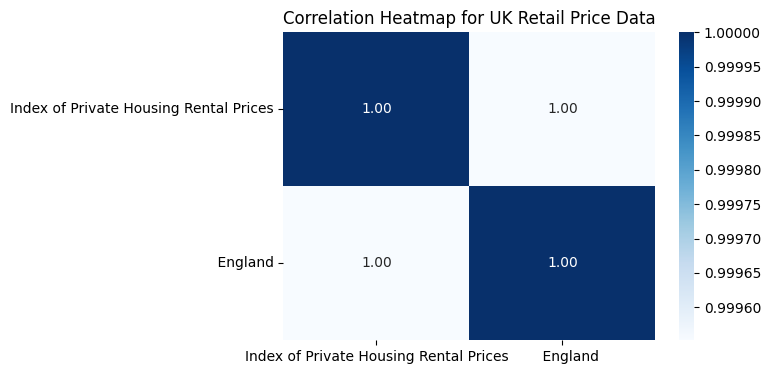

In [106]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_uk_retail_price[['Index of Private Housing Rental Prices', '    England']].corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap for UK Retail Price Data')
plt.show()

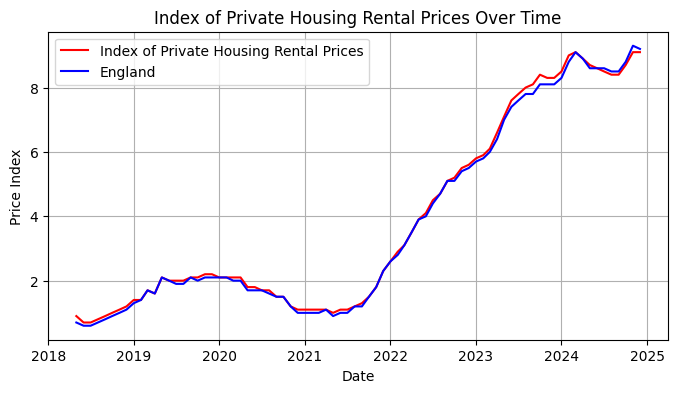

In [162]:
# Line Plot for Time-Series Analysis
plt.figure(figsize=(8, 4))
plt.plot(df_uk_retail_price['Date'], df_uk_retail_price['Index of Private Housing Rental Prices'], label='Index of Private Housing Rental Prices', color='red')
plt.plot(df_uk_retail_price['Date'], df_uk_retail_price['    England'], label='England', color='blue')
plt.title('Index of Private Housing Rental Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price Index')
plt.legend()
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


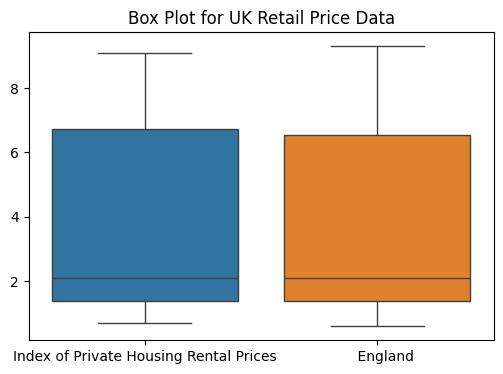

In [108]:
# Box Plot for Outlier Detection
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_uk_retail_price[['Index of Private Housing Rental Prices', '    England']])
plt.title('Box Plot for UK Retail Price Data')
plt.show()

In [109]:
df_uk_affordability_index = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="uk_affordability_index")
df_uk_affordability_index

Date              East Anglia              East Midlands  \
0   Q4 2020                     80.3                       90.4   
1   Q3 2020                     78.5                       86.7   
2   Q2 2020                     78.0                       85.9   
3   Q1 2020                     79.0                       88.6   
4   Q4 2019                     79.2                       86.2   
5   Q3 2019                     80.1                       87.6   
6   Q2 2019                     80.3                       87.3   
7   Q1 2019                     80.4                       88.7   
8   Q4 2018                     82.2                       88.5   
9   Q3 2018                     83.2                       90.3   
10  Q2 2018                     82.6                       88.2   
11  Q1 2018                     81.7                       88.4   
12  Q4 2017                     82.8                       87.6   
13  Q3 2017                     83.2                       89.0   
14  Q2 2017                     82.9                       87.9   
15  Q1 2017                     82.6                       87.4   
16  Q4 2016                     84.8                       87.7   
17  Q3 2016                     85.0                       89.6   
18  Q2 2016                     85.2                       89.6   
19  Q1 2016                     84.9                       89.3   
20  Q4 2015                     83.4                       89.0   
21  Q3 2015                     83.7                       91.4   
22  Q2 2015                     85.7                       93.1   
23  Q1 2015                     87.2                       95.7   
24  Q4 2014                     87.7                       96.3   
25  Q3 2014                     89.8                       98.5   
26  Q2 2014                     85.3                       96.4   
27  Q1 2014                     84.0                       93.2   

                London              Northern Ireland  \
0                 90.2                          76.1   
1                 88.4                          73.5   
2                 86.8                          72.0   
3                 86.4                          75.8   
4                 87.2                          73.0   
5                 88.5                          75.4   
6                 90.8                          75.0   
7                 90.8                          76.7   
8                 93.1                          75.7   
9                 94.4                          74.9   
10                94.5                          73.0   
11                97.2                          75.4   
12                96.6                          72.8   
13                98.0                          73.7   
14                99.7                          73.7   
15               101.8                          71.1   
16               101.7                          74.0   
17               106.1                          73.9   
18               107.1                          74.6   
19               105.8                          73.8   
20               107.7                          77.7   
21               105.6                          78.1   
22               104.1                          82.1   
23               102.8                          80.5   
24               104.0                          81.8   
25               102.5                          79.9   
26               101.8                          79.7   
27                91.8                          73.1   

                North West England              Scotland  \
0                             77.8                  56.0   
1                             75.4                  53.9   
2                             76.6                  54.2   
3                             77.1                  55.0   
4                             74.5                  55.6   
5                             76.6                  56.7   
6                 

In [110]:
# Extract year and quarter separately
df_uk_affordability_index[['Quarter', 'Year']] = df_uk_affordability_index['Date'].str.extract(r'(Q\d)\s*(\d{4})')

df_uk_affordability_index

Date              East Anglia              East Midlands  \
0   Q4 2020                     80.3                       90.4   
1   Q3 2020                     78.5                       86.7   
2   Q2 2020                     78.0                       85.9   
3   Q1 2020                     79.0                       88.6   
4   Q4 2019                     79.2                       86.2   
5   Q3 2019                     80.1                       87.6   
6   Q2 2019                     80.3                       87.3   
7   Q1 2019                     80.4                       88.7   
8   Q4 2018                     82.2                       88.5   
9   Q3 2018                     83.2                       90.3   
10  Q2 2018                     82.6                       88.2   
11  Q1 2018                     81.7                       88.4   
12  Q4 2017                     82.8                       87.6   
13  Q3 2017                     83.2                       89.0   
14  Q2 2017                     82.9                       87.9   
15  Q1 2017                     82.6                       87.4   
16  Q4 2016                     84.8                       87.7   
17  Q3 2016                     85.0                       89.6   
18  Q2 2016                     85.2                       89.6   
19  Q1 2016                     84.9                       89.3   
20  Q4 2015                     83.4                       89.0   
21  Q3 2015                     83.7                       91.4   
22  Q2 2015                     85.7                       93.1   
23  Q1 2015                     87.2                       95.7   
24  Q4 2014                     87.7                       96.3   
25  Q3 2014                     89.8                       98.5   
26  Q2 2014                     85.3                       96.4   
27  Q1 2014                     84.0                       93.2   

                London              Northern Ireland  \
0                 90.2                          76.1   
1                 88.4                          73.5   
2                 86.8                          72.0   
3                 86.4                          75.8   
4                 87.2                          73.0   
5                 88.5                          75.4   
6                 90.8                          75.0   
7                 90.8                          76.7   
8                 93.1                          75.7   
9                 94.4                          74.9   
10                94.5                          73.0   
11                97.2                          75.4   
12                96.6                          72.8   
13                98.0                          73.7   
14                99.7                          73.7   
15               101.8                          71.1   
16               101.7                          74.0   
17               106.1                          73.9   
18               107.1                          74.6   
19               105.8                          73.8   
20               107.7                          77.7   
21               105.6                          78.1   
22               104.1                          82.1   
23               102.8                          80.5   
24               104.0                          81.8   
25               102.5                          79.9   
26               101.8                          79.7   
27                91.8                          73.1   

                North West England              Scotland  \
0                             77.8                  56.0   
1                             75.4                  53.9   
2                             76.6                  54.2   
3                             77.1                  55.0   
4                             74.5                  55.6   
5                             76.6                  56.7   
6                 

In [112]:
yearly_data_uai = df_uk_affordability_index.groupby('Year').agg({
    '            East Midlands' : 'mean',
    '            West Midlands' : 'mean',
    '            London' : 'mean',
    '            North West England' : 'mean',
    '            South West England' : 'mean',
    '            Yorkshire and Humberside' : 'mean'

}).reset_index()

yearly_data_uai

Year              East Midlands              West Midlands  \
0  2014                     96.100                     97.350   
1  2015                     92.300                     94.075   
2  2016                     89.050                     90.700   
3  2017                     87.975                     89.300   
4  2018                     88.850                     89.300   
5  2019                     87.450                     89.675   
6  2020                     87.900                     88.875   

               London              North West England  \
0             100.025                          86.125   
1             105.050                          81.900   
2             105.175                          78.975   
3              99.025                          77.425   
4              94.800                          76.750   
5              89.325                          76.000   
6              87.950                          76.725   

               South West England              Yorkshire and Humberside  
0                          87.575                                72.850  
1                          85.900                                68.850  
2                          84.450                                66.225  
3                          83.050                                63.700  
4                          82.325                                63.125  
5                          80.700                                61.450  
6                          80.475                                61.700

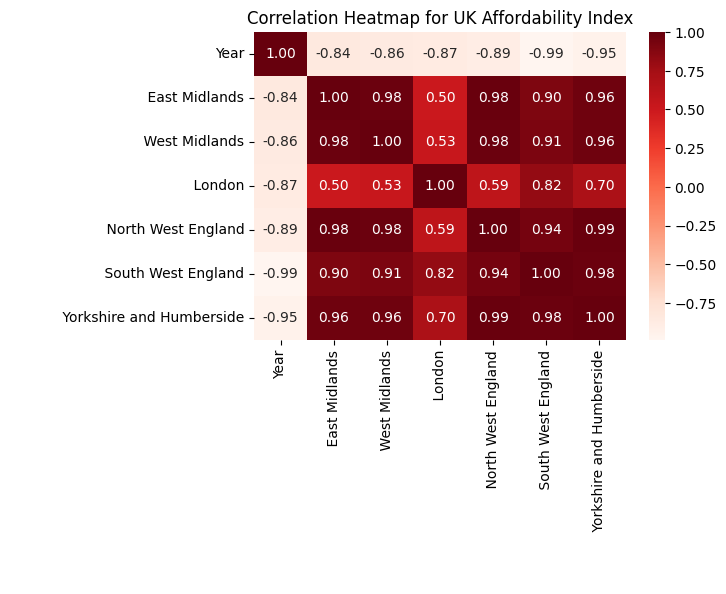

In [113]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(yearly_data_uai.corr(), annot=True, cmap='Reds', fmt=".2f")
plt.title('Correlation Heatmap for UK Affordability Index')
plt.show()

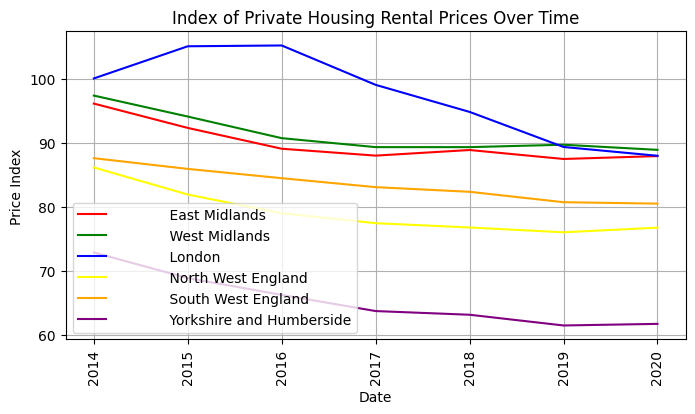

In [114]:
# df_uk_affordability_index['Date'] = pd.to_numeric(df_uk_affordability_index['Date'])

# Line Plot for Time-Series Analysis
plt.figure(figsize=(8, 4))
plt.plot(yearly_data_uai['Year'], yearly_data_uai['            East Midlands'], label='            East Midlands', color='red')
plt.plot(yearly_data_uai['Year'], yearly_data_uai['            West Midlands'], label='            West Midlands', color='green')
plt.plot(yearly_data_uai['Year'], yearly_data_uai['            London'], label='            London', color='blue')
plt.plot(yearly_data_uai['Year'], yearly_data_uai['            North West England'], label='            North West England', color='yellow')
plt.plot(yearly_data_uai['Year'], yearly_data_uai['            South West England'], label='            South West England', color='orange')
plt.plot(yearly_data_uai['Year'], yearly_data_uai['            Yorkshire and Humberside'], label='            Yorkshire and Humberside', color='purple')
plt.title('Index of Private Housing Rental Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price Index')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

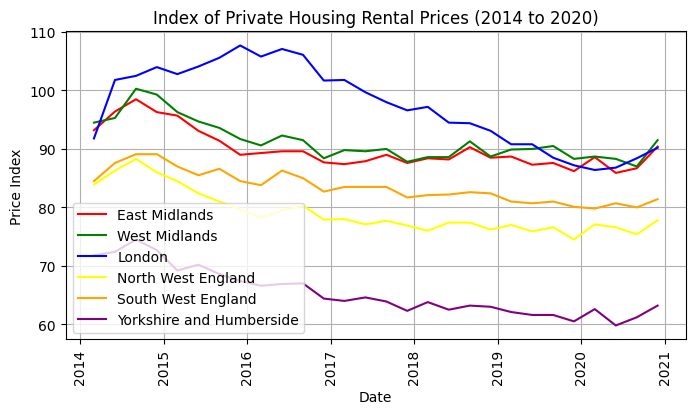

In [115]:
# Extract year and quarter from the Date column
df_uk_affordability_index[['Quarter', 'Year']] = df_uk_affordability_index['Date'].str.extract(r'(Q\d)\s+(\d{4})')

# Create a proper date format by converting the quarter to a month
quarter_to_month = {'Q1': '03', 'Q2': '06', 'Q3': '09', 'Q4': '12'}
df_uk_affordability_index['Month'] = df_uk_affordability_index['Quarter'].map(quarter_to_month)

# Combine Year and Month to create a datetime column
df_uk_affordability_index['Date'] = pd.to_datetime(df_uk_affordability_index['Year'] + '-' + df_uk_affordability_index['Month'])

# Filter the DataFrame between 2014 and 2020
filtered_df = df_uk_affordability_index[(df_uk_affordability_index['Date'].dt.year >= 2014) & 
                                        (df_uk_affordability_index['Date'].dt.year <= 2020)]

# Plot the filtered data
plt.figure(figsize=(8, 4))
plt.plot(filtered_df['Date'], filtered_df['            East Midlands'], label='East Midlands', color='red')
plt.plot(filtered_df['Date'], filtered_df['            West Midlands'], label='West Midlands', color='green')
plt.plot(filtered_df['Date'], filtered_df['            London'], label='London', color='blue')
plt.plot(filtered_df['Date'], filtered_df['            North West England'], label='North West England', color='yellow')
plt.plot(filtered_df['Date'], filtered_df['            South West England'], label='South West England', color='orange')
plt.plot(filtered_df['Date'], filtered_df['            Yorkshire and Humberside'], label='Yorkshire and Humberside', color='purple')
plt.title('Index of Private Housing Rental Prices (2014 to 2020)')
plt.xlabel('Date')
plt.ylabel('Price Index')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

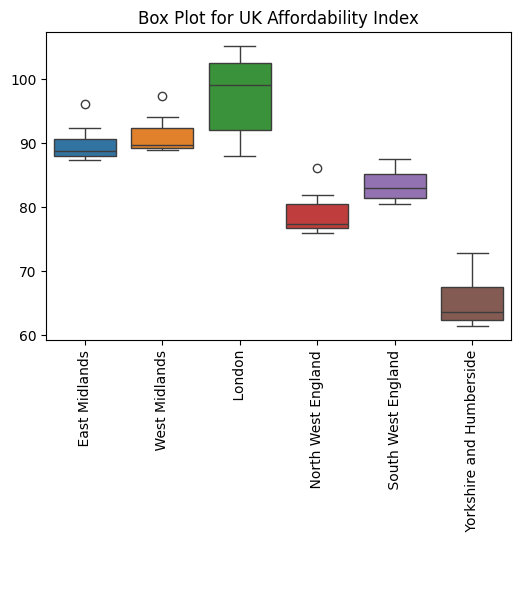

In [116]:
# Box Plot for Outlier Detection
plt.figure(figsize=(6, 4))
sns.boxplot(data=yearly_data_uai)
plt.title('Box Plot for UK Affordability Index')
plt.xticks(rotation=90)
plt.show()

In [117]:
df_construction_cost_prices_sales = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="construction_cost_prices_sales")
df_construction_cost_prices_sales

Date  Construction Output/Sales (GBP)  New Housing  \
0   Q3 2024                           9673.0       2154.0   
1   Q2 2024                          12395.0       3195.0   
2   Q1 2024                          10687.0       2732.0   
3   Q4 2023                           9126.0       2867.0   
4   Q3 2023                          10674.0       3345.0   
..      ...                              ...          ...   
74      NaN                              NaN          NaN   
75      NaN                              NaN          NaN   
76      NaN                              NaN          NaN   
77      NaN                              NaN          NaN   
78      NaN                              NaN          NaN   

    Public and Housing Associations  Private Housing  Other New Work  \
0                             264.0           1890.0          7519.0   
1                             444.0           2751.0          9201.0   
2                             215.0           2517.0          7954.0   
3                             469.0           2398.0          6258.0   
4                             465.0           2880.0          7329.0   
..                              ...              ...             ...   
74                              NaN              NaN             NaN   
75                              NaN              NaN             NaN   
76                              NaN              NaN             NaN   
77                              NaN              NaN             NaN   
78                              NaN              NaN             NaN   

    Infrastructure  Other Public Work Excluding Infrastructure  \
0           2132.0                                      1365.0   
1           2115.0                                      1897.0   
2           1670.0                                      1785.0   
3           1632.0                                      1225.0   
4           1572.0                                      1475.0   
..             ...                                         ...   
74             NaN                                         NaN   
75             NaN                                         NaN   
76             NaN                                         NaN   
77             NaN                                         NaN   
78             NaN                                         NaN   

    Other Private Industrial Work Excluding Infrastructure  \
0                                              1036.0        
1                                              1417.0        
2                                              1183.0        
3                                               867.0        
4                                              1204.0        
..                                                ...        
74                                                NaN        
75                                                NaN        
76                                                NaN        
77                                                NaN        
78                                                NaN        

    Other Private Commercial Work Excluding Infrastructure  \
0                                              2986.0        
1                                              3772.0        
2                                              3316.0        
3                                              2534.0        
4                                              3078.0        
..                                                ...        
74                                                NaN        
75                                                NaN        
76                                                NaN        
77                                                NaN        
78                                                NaN        

   Construction Costs/Prices Housing New Work Infrastructure2 Public Works  \
0                         --      --       --   

In [118]:
# Summary statistics
df_construction_cost_prices_sales.describe()

Construction Output/Sales (GBP)  New Housing  \
count                        43.000000    43.000000   
mean                      11959.883721  3554.325581   
std                        1644.419614   497.601663   
min                        6020.000000  1876.000000   
25%                       11068.000000  3361.000000   
50%                       12382.000000  3641.000000   
75%                       12919.000000  3863.000000   
max                       16720.000000  4456.000000   

       Public and Housing Associations  Private Housing  Other New Work  \
count                        43.000000        43.000000       43.000000   
mean                        346.000000      3208.116279     8405.627907   
std                         100.251826       485.167286     1324.796625   
min                         204.000000      1631.000000     4143.000000   
25%                         255.500000      3086.000000     7635.500000   
50%                         351.000000      3312.000000     8738.000000   
75%                         406.500000      3505.000000     9221.000000   
max                         588.000000      4198.000000    12680.000000   

       Infrastructure  Other Public Work Excluding Infrastructure  \
count       43.000000                                   43.000000   
mean      2360.604651                                 1536.186047   
std        885.985627                                  314.117756   
min       1079.000000                                  958.000000   
25%       1846.000000                                 1353.000000   
50%       2190.000000                                 1506.000000   
75%       2526.500000                                 1702.000000   
max       6605.000000                                 2315.000000   

       Other Private Industrial Work Excluding Infrastructure  \
count                                          43.000000        
mean                                         1154.418605        
std                                           332.073732        
min                                           450.000000        
25%                                           973.500000        
50%                                          1064.000000        
75%                                          1324.000000        
max                                          2109.000000        

       Other Private Commercial Work Excluding Infrastructure  
count                                          43.000000       
mean                                         3354.418605       
std                                           561.566781       
min                                          1656.000000       
25%                                          3026.000000       
50%                                          3337.000000       
75%                                          3751.000000       
max                                          4393.000000

In [120]:
df_mortage_interest_rate = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="mortage_interest_rate")
df_mortage_interest_rate

Date Lifetime Tracker Standard Variable Rate 2 Years 3 Years 5 Years  \
0   Dec 2024               --                     --      --      --      --   
1   Nov 2024             6.44                   7.59    4.53    4.44    4.31   
2   Oct 2024             6.51                    7.7    4.41    4.28    4.07   
3   Sep 2024             6.51                    7.7    4.58    4.43    4.09   
4   Aug 2024             6.54                   7.86     4.8    4.62    4.33   
..       ...              ...                    ...     ...     ...     ...   
75  Sep 2018               --                   4.39    1.71    1.81    2.01   
76  Aug 2018               --                   4.35    1.75    1.82    2.03   
77  Jul 2018               --                    4.1    1.75    1.82    2.04   
78  Jun 2018               --                   4.06    1.74     1.8    2.03   
79  May 2018               --                   4.16    1.74    1.83    2.06   

   10 Years 2 Years2 5 Years3  2 Years4 2 Years5 2 Years6  
0        --       --       --      5.36       --      5.4  
1      4.66     5.68     5.23      5.41     5.21     5.51  
2      4.68     5.61     5.13      5.30     5.39     5.53  
3       4.8     5.76     5.23      5.40     5.45     5.55  
4      4.85      5.9     5.33      5.54      5.5     5.72  
..      ...      ...      ...       ...      ...      ...  
75     2.68     3.38     3.94      2.12     1.68       --  
76      2.7     3.61     4.15      2.28      1.7       --  
77     2.76     3.78     4.29      2.30     1.54       --  
78     2.74     3.95     4.39      2.37     1.56       --  
79     2.76     3.95     4.43      2.34     1.59       --  

[80 rows x 12 columns]

In [121]:
# Replacing "--" with NaN values
df_mortage_interest_rate['Lifetime Tracker'].replace('--', np.nan, inplace=True)
df_mortage_interest_rate['Standard Variable Rate'].replace('--', np.nan, inplace=True)
df_mortage_interest_rate['2 Years'].replace('--', np.nan, inplace=True)
df_mortage_interest_rate['3 Years'].replace('--', np.nan, inplace=True)
df_mortage_interest_rate['5 Years'].replace('--', np.nan, inplace=True)
df_mortage_interest_rate['10 Years'].replace('--', np.nan, inplace=True)
df_mortage_interest_rate['2 Years2'].replace('--', np.nan, inplace=True)
df_mortage_interest_rate['5 Years3'].replace('--', np.nan, inplace=True)
df_mortage_interest_rate['2 Years4'].replace('--', np.nan, inplace=True)
df_mortage_interest_rate['2 Years5'].replace('--', np.nan, inplace=True)
df_mortage_interest_rate['2 Years6'].replace('--', np.nan, inplace=True)
df_mortage_interest_rate

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\3629134346.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mortage_interest_rate['Lifetime Tracker'].replace('--', np.nan, inplace=True)
C:\Users\neera\AppData\Local\Temp\ipykernel_15812\3629134346.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', Tr

Date  Lifetime Tracker  Standard Variable Rate  2 Years  3 Years  \
0   Dec 2024               NaN                     NaN      NaN      NaN   
1   Nov 2024              6.44                    7.59     4.53     4.44   
2   Oct 2024              6.51                    7.70     4.41     4.28   
3   Sep 2024              6.51                    7.70     4.58     4.43   
4   Aug 2024              6.54                    7.86     4.80     4.62   
..       ...               ...                     ...      ...      ...   
75  Sep 2018               NaN                    4.39     1.71     1.81   
76  Aug 2018               NaN                    4.35     1.75     1.82   
77  Jul 2018               NaN                    4.10     1.75     1.82   
78  Jun 2018               NaN                    4.06     1.74     1.80   
79  May 2018               NaN                    4.16     1.74     1.83   

    5 Years  10 Years  2 Years2  5 Years3  2 Years4  2 Years5  2 Years6  
0       NaN       NaN       NaN       NaN      5.36       NaN      5.40  
1      4.31      4.66      5.68      5.23      5.41      5.21      5.51  
2      4.07      4.68      5.61      5.13      5.30      5.39      5.53  
3      4.09      4.80      5.76      5.23      5.40      5.45      5.55  
4      4.33      4.85      5.90      5.33      5.54      5.50      5.72  
..      ...       ...       ...       ...       ...       ...       ...  
75     2.01      2.68      3.38      3.94      2.12      1.68       NaN  
76     2.03      2.70      3.61      4.15      2.28      1.70       NaN  
77     2.04      2.76      3.78      4.29      2.30      1.54       NaN  
78     2.03      2.74      3.95      4.39      2.37      1.56       NaN  
79     2.06      2.76      3.95      4.43      2.34      1.59       NaN  

[80 rows x 12 columns]

In [122]:
df_mortage_interest_rate['Date'] = pd.to_datetime(df_mortage_interest_rate['Date'], errors='coerce')
    
# Extracting time-based features
df_mortage_interest_rate['Year'] = df_mortage_interest_rate['Date'].dt.year
df_mortage_interest_rate['Month'] = df_mortage_interest_rate['Date'].dt.month
df_mortage_interest_rate

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\2627684536.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mortage_interest_rate['Date'] = pd.to_datetime(df_mortage_interest_rate['Date'], errors='coerce')


Date  Lifetime Tracker  Standard Variable Rate  2 Years  3 Years  \
0  2024-12-01               NaN                     NaN      NaN      NaN   
1  2024-11-01              6.44                    7.59     4.53     4.44   
2  2024-10-01              6.51                    7.70     4.41     4.28   
3  2024-09-01              6.51                    7.70     4.58     4.43   
4  2024-08-01              6.54                    7.86     4.80     4.62   
..        ...               ...                     ...      ...      ...   
75 2018-09-01               NaN                    4.39     1.71     1.81   
76 2018-08-01               NaN                    4.35     1.75     1.82   
77 2018-07-01               NaN                    4.10     1.75     1.82   
78 2018-06-01               NaN                    4.06     1.74     1.80   
79 2018-05-01               NaN                    4.16     1.74     1.83   

    5 Years  10 Years  2 Years2  5 Years3  2 Years4  2 Years5  2 Years6  Year  \
0       NaN       NaN       NaN       NaN      5.36       NaN      5.40  2024   
1      4.31      4.66      5.68      5.23      5.41      5.21      5.51  2024   
2      4.07      4.68      5.61      5.13      5.30      5.39      5.53  2024   
3      4.09      4.80      5.76      5.23      5.40      5.45      5.55  2024   
4      4.33      4.85      5.90      5.33      5.54      5.50      5.72  2024   
..      ...       ...       ...       ...       ...       ...       ...   ...   
75     2.01      2.68      3.38      3.94      2.12      1.68       NaN  2018   
76     2.03      2.70      3.61      4.15      2.28      1.70       NaN  2018   
77     2.04      2.76      3.78      4.29      2.30      1.54       NaN  2018   
78     2.03      2.74      3.95      4.39      2.37      1.56       NaN  2018   
79     2.06      2.76      3.95      4.43      2.34      1.59       NaN  2018   

    Month  
0      12  
1      11  
2      10  
3       9  
4       8  
..    ...  
75      9  
76      8  
77      7  
78      6  
79      5  

[80 rows x 14 columns]

In [123]:
# Filling missing values with the mean of the respective year

df_mortage_interest_rate.update(df_mortage_interest_rate.groupby('Year').transform(lambda x: x.fillna(x.mean())))

df_mortage_interest_rate['2 Years6'].fillna(2.9, inplace=True)

df_mortage_interest_rate

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\145598785.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mortage_interest_rate['2 Years6'].fillna(2.9, inplace=True)


Date  Lifetime Tracker  Standard Variable Rate   2 Years  3 Years  \
0  2024-12-01          6.782727                7.887273  4.824545     4.64   
1  2024-11-01          6.440000                7.590000  4.530000     4.44   
2  2024-10-01          6.510000                7.700000  4.410000     4.28   
3  2024-09-01          6.510000                7.700000  4.580000     4.43   
4  2024-08-01          6.540000                7.860000  4.800000     4.62   
..        ...               ...                     ...       ...      ...   
75 2018-09-01               NaN                4.390000  1.710000     1.81   
76 2018-08-01               NaN                4.350000  1.750000     1.82   
77 2018-07-01               NaN                4.100000  1.750000     1.82   
78 2018-06-01               NaN                4.060000  1.740000     1.80   
79 2018-05-01               NaN                4.160000  1.740000     1.83   

     5 Years  10 Years  2 Years2  5 Years3  2 Years4  2 Years5  2 Years6  \
0   4.406364  4.780909  5.848182  5.303636      5.36  5.603636      5.40   
1   4.310000  4.660000  5.680000  5.230000      5.41  5.210000      5.51   
2   4.070000  4.680000  5.610000  5.130000      5.30  5.390000      5.53   
3   4.090000  4.800000  5.760000  5.230000      5.40  5.450000      5.55   
4   4.330000  4.850000  5.900000  5.330000      5.54  5.500000      5.72   
..       ...       ...       ...       ...       ...       ...       ...   
75  2.010000  2.680000  3.380000  3.940000      2.12  1.680000      2.90   
76  2.030000  2.700000  3.610000  4.150000      2.28  1.700000      2.90   
77  2.040000  2.760000  3.780000  4.290000      2.30  1.540000      2.90   
78  2.030000  2.740000  3.950000  4.390000      2.37  1.560000      2.90   
79  2.060000  2.760000  3.950000  4.430000      2.34  1.590000      2.90   

    Year  Month  
0   2024     12  
1   2024     11  
2   2024     10  
3   2024      9  
4   2024      8  
..   ...    ...  
75  2018      9  
76  2018      8  
77  2018      7  
78  2018      6  
79  2018      5  

[80 rows x 14 columns]

In [125]:
# Grouping by year and computing the mean of all numeric columns

yearly_data_mir = df_mortage_interest_rate.groupby('Year').agg({
    'Lifetime Tracker' : 'mean',
    'Standard Variable Rate' : 'mean',
    '2 Years' : 'mean',
    '3 Years' : 'mean',
    '5 Years' : 'mean',
    '10 Years' : 'mean',
    '2 Years2' : 'mean',
    '5 Years3' : 'mean',
    '2 Years4' : 'mean',
    '2 Years5' : 'mean',
    '2 Years6' : 'mean'
}).reset_index()

yearly_data_mir.round(2)

Year  Lifetime Tracker  Standard Variable Rate  2 Years  3 Years  5 Years  \
0  2018               NaN                    4.29     1.75     1.82     2.03   
1  2019              2.58                    4.31     1.59     1.72     1.90   
2  2020              2.53                    3.79     1.58     1.75     1.80   
3  2021              2.16                    3.61     1.45     1.55     1.58   
4  2022               NaN                    4.71     3.51     3.46     3.38   
5  2023              7.00                    7.53     5.31     5.13     4.81   
6  2024              6.78                    7.89     4.82     4.64     4.41   

   10 Years  2 Years2  5 Years3  2 Years4  2 Years5  2 Years6  
0      2.71      3.55      4.08      2.28      1.65      2.90  
1      2.56      2.97      3.45      2.14      1.80      2.96  
2      2.41      3.40      3.82      2.63      1.93      3.28  
3      2.55      3.57      3.80      2.81      1.95      3.47  
4      3.56      4.16      4.16      3.79      2.59      3.16  
5      4.75      6.25      5.64      5.76      5.10      5.41  
6      4.78      5.85      5.30      5.46      5.60      5.75

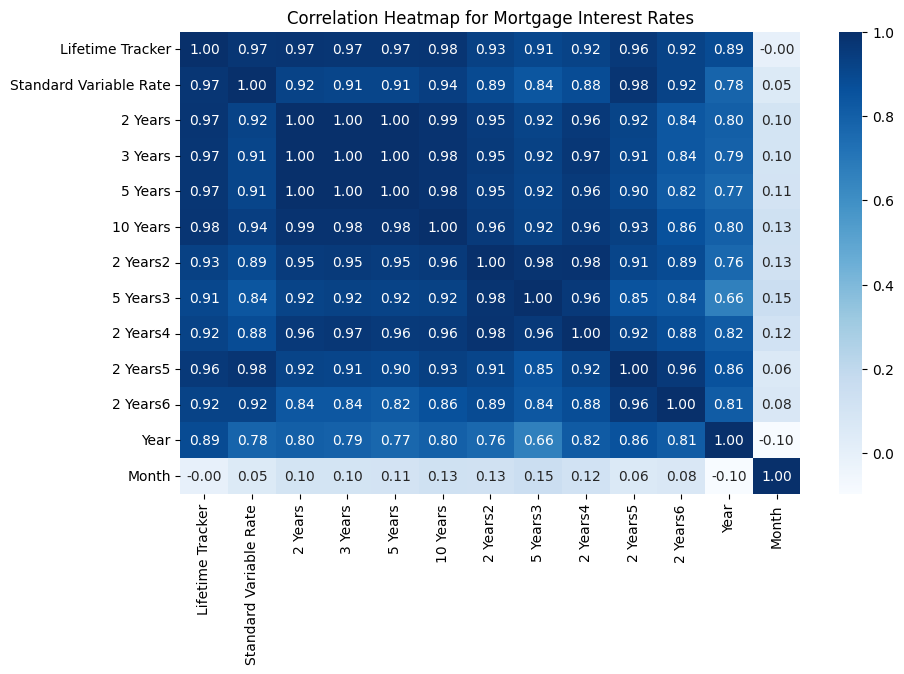

In [126]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_mortage_interest_rate.drop(columns=['Date']).corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap for Mortgage Interest Rates')
plt.xticks(rotation=90)
plt.show()

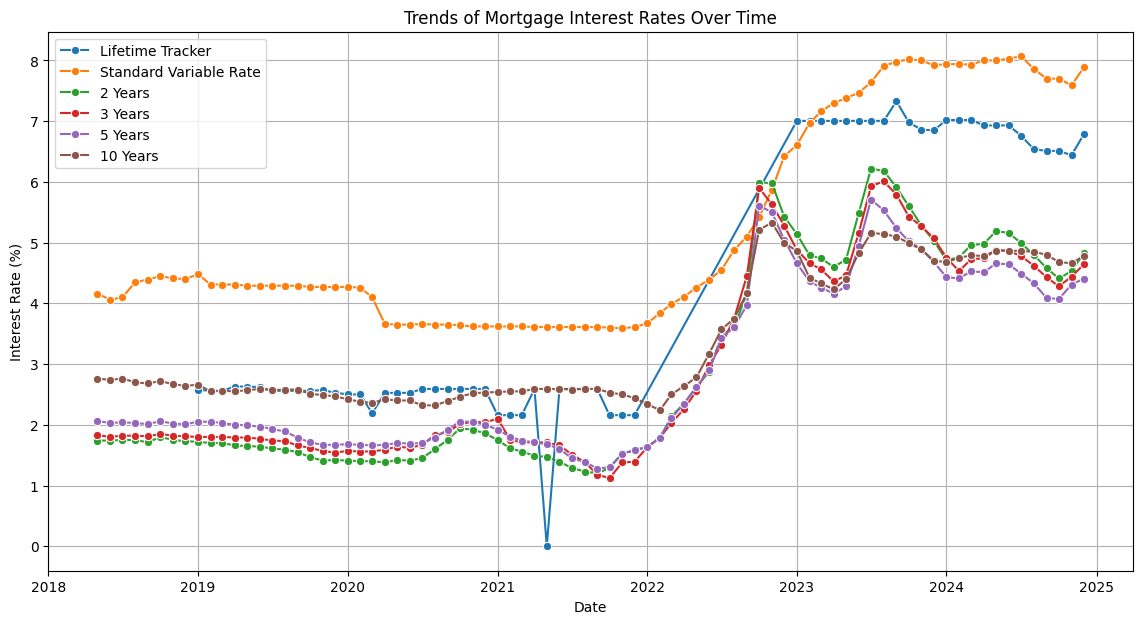

In [127]:
# Line Plot for Trends Over Time
plt.figure(figsize=(14, 7))
for col in ['Lifetime Tracker', 'Standard Variable Rate', '2 Years', '3 Years', '5 Years', '10 Years']:
    sns.lineplot(data=df_mortage_interest_rate, x='Date', y=col, label=col, marker='o')

plt.title('Trends of Mortgage Interest Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True)
plt.show()

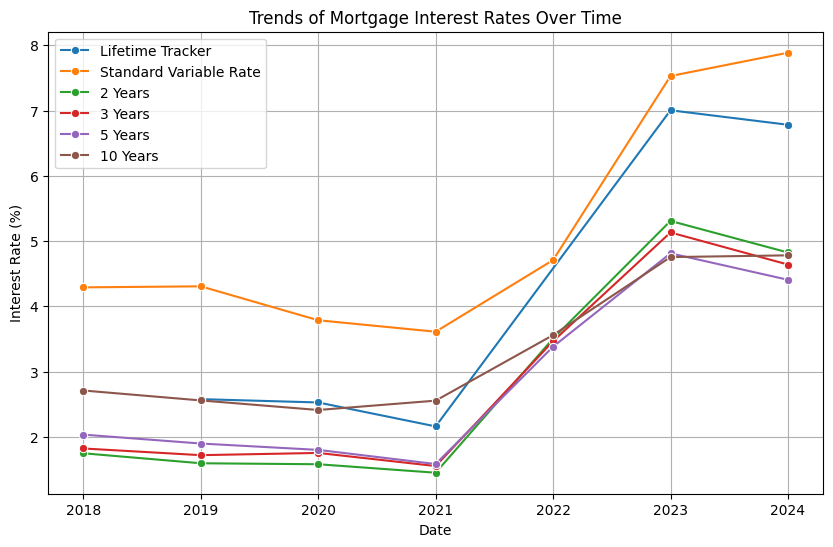

In [128]:
# Line Plot for Trends Over Time
plt.figure(figsize=(10, 6))
for col in ['Lifetime Tracker', 'Standard Variable Rate', '2 Years', '3 Years', '5 Years', '10 Years']:
    sns.lineplot(data=yearly_data_mir, x='Year', y=col, label=col, marker='o')

plt.title('Trends of Mortgage Interest Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True)
plt.show()

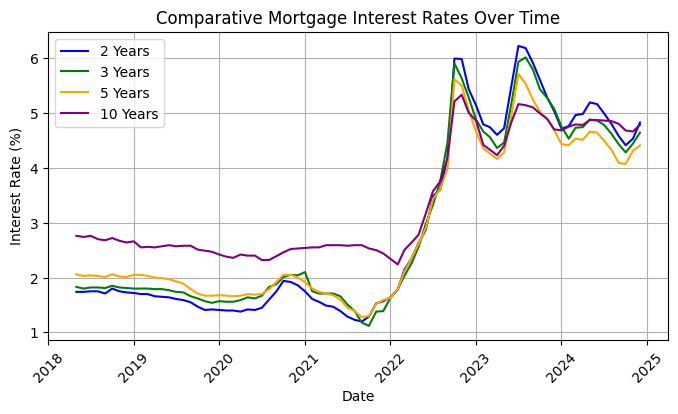

In [129]:
# Comparative Line Plots: 2-Year, 3-Year, 5-Year, and 10-Year Rates
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_mortage_interest_rate, x='Date', y='2 Years', label='2 Years', color='blue')
sns.lineplot(data=df_mortage_interest_rate, x='Date', y='3 Years', label='3 Years', color='green')
sns.lineplot(data=df_mortage_interest_rate, x='Date', y='5 Years', label='5 Years', color='orange')
sns.lineplot(data=df_mortage_interest_rate, x='Date', y='10 Years', label='10 Years', color='purple')
plt.title('Comparative Mortgage Interest Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Company Revenue

In [130]:
df_company_revenue = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="company_revenue")
df_company_revenue

Revenues  Ashtead Group PLC (AHT.L)  \
0  30-04-2024                   10858.70   
1  30-04-2023                    9667.30   
2  30-04-2022                    7962.30   
3  30-04-2021                    6638.60   
4  30-04-2020                    6395.35   
5  30-04-2019                    5868.58   
6  30-04-2018                    4952.56   
7  30-04-2017                    4112.05   
8  30-04-2016                    3820.33   
9  30-04-2015                    3251.43   

   Babcock International Group PLC (BAB.L)  Column1  Caterpillar Inc (CAT)  \
0                                   4390.1     7993                  67060   
1                                   4438.6     7629                  59427   
2                                   4101.8     7202                  50971   
3                                   3971.6     7318                  41748   
4                                   4428.5     7313                  53800   
5                                   4474.8     6634                  54722   
6                                   4659.6     6916                  45462   
7                                   4547.1     6923                  38537   
8                                   4158.4     6955                  47011   
9                                   3996.6     7264                  55184   

   Hitachi Construction Machinery Co Ltd (6305.T)  \
0                                         1405928   
1                                         1264927   
2                                         1024961   
3                                          813331   
4                                          931347   
5                                         1033703   
6                                          959153   
7                                          753947   
8                                          758331   
9                                          815792   

   J.C. Bamford Excavators Ltd (4296370337)  Komatsu Ltd (6301.T)  \
0                                    5331.2               3865122   
1                                    4395.7               3543475   
2                                    3438.3               2802323   
3                                    2437.0               2189512   
4                                    3243.1               2444870   
5                                    3308.1               2725243   
6                                    2591.9               2501107   
7                                     887.3               1802989   
8                                     856.1               1854964   
9                                    1009.7               1978676   

   Liebherr-International Ltd (4298321885)  Speedy Hire PLC (SDY.L)  \
0                                    14042                    421.5   
1                                    12589                    440.6   
2                                    11639                    386.8   
3                                    10341                    332.3   
4                                    11750                    371.5   
5                                    10551                    394.7   
6                                     9812                    376.3   
7                                     9009                    375.1   
8                                     9237                    333.4   
9                                     8823                    389.5   

   Terex Corp (TEX)  
0            5151.5  
1            4417.7  
2            3886.8  
3            3076.4  
4            4353.1  
5            4517.2  
6            4363.4  
7            4443.1  
8            5021.7  
9            7308.9

In [131]:
df_company_revenue.drop(columns = 'Column1', inplace=True)

df_company_revenue

Revenues  Ashtead Group PLC (AHT.L)  \
0  30-04-2024                   10858.70   
1  30-04-2023                    9667.30   
2  30-04-2022                    7962.30   
3  30-04-2021                    6638.60   
4  30-04-2020                    6395.35   
5  30-04-2019                    5868.58   
6  30-04-2018                    4952.56   
7  30-04-2017                    4112.05   
8  30-04-2016                    3820.33   
9  30-04-2015                    3251.43   

   Babcock International Group PLC (BAB.L)  Caterpillar Inc (CAT)  \
0                                   4390.1                  67060   
1                                   4438.6                  59427   
2                                   4101.8                  50971   
3                                   3971.6                  41748   
4                                   4428.5                  53800   
5                                   4474.8                  54722   
6                                   4659.6                  45462   
7                                   4547.1                  38537   
8                                   4158.4                  47011   
9                                   3996.6                  55184   

   Hitachi Construction Machinery Co Ltd (6305.T)  \
0                                         1405928   
1                                         1264927   
2                                         1024961   
3                                          813331   
4                                          931347   
5                                         1033703   
6                                          959153   
7                                          753947   
8                                          758331   
9                                          815792   

   J.C. Bamford Excavators Ltd (4296370337)  Komatsu Ltd (6301.T)  \
0                                    5331.2               3865122   
1                                    4395.7               3543475   
2                                    3438.3               2802323   
3                                    2437.0               2189512   
4                                    3243.1               2444870   
5                                    3308.1               2725243   
6                                    2591.9               2501107   
7                                     887.3               1802989   
8                                     856.1               1854964   
9                                    1009.7               1978676   

   Liebherr-International Ltd (4298321885)  Speedy Hire PLC (SDY.L)  \
0                                    14042                    421.5   
1                                    12589                    440.6   
2                                    11639                    386.8   
3                                    10341                    332.3   
4                                    11750                    371.5   
5                                    10551                    394.7   
6                                     9812                    376.3   
7                                     9009                    375.1   
8                                     9237                    333.4   
9                                     8823                    389.5   

   Terex Corp (TEX)  
0            5151.5  
1            4417.7  
2            3886.8  
3            3076.4  
4            4353.1  
5            4517.2  
6            4363.4  
7            4443.1  
8            5021.7  
9            7308.9

In [132]:
df_company_revenue.describe().round(2)

Ashtead Group PLC (AHT.L)  Babcock International Group PLC (BAB.L)  \
count                      10.00                                    10.00   
mean                     6352.72                                  4316.71   
std                      2521.27                                   240.65   
min                      3251.43                                  3971.60   
25%                      4322.18                                  4115.95   
50%                      6131.96                                  4409.30   
75%                      7631.38                                  4465.75   
max                     10858.70                                  4659.60   

       Caterpillar Inc (CAT)  Hitachi Construction Machinery Co Ltd (6305.T)  \
count                  10.00                                           10.00   
mean                51392.20                                       976142.00   
std                  8525.17                                       217341.60   
min                 38537.00                                       753947.00   
25%                 45849.25                                       813946.25   
50%                 52385.50                                       945250.00   
75%                 55068.50                                      1031517.50   
max                 67060.00                                      1405928.00   

       J.C. Bamford Excavators Ltd (4296370337)  Komatsu Ltd (6301.T)  \
count                                     10.00                 10.00   
mean                                    2749.84            2570828.10   
std                                     1513.18             692618.49   
min                                      856.10            1802989.00   
25%                                     1366.52            2031385.00   
50%                                     2917.50            2472988.50   
75%                                     3405.75            2783053.00   
max                                     5331.20            3865122.00   

       Liebherr-International Ltd (4298321885)  Speedy Hire PLC (SDY.L)  \
count                                    10.00                    10.00   
mean                                  10779.30                   382.17   
std                                    1703.63                    33.76   
min                                    8823.00                   332.30   
25%                                    9380.75                   372.40   
50%                                   10446.00                   381.55   
75%                                   11722.25                   393.40   
max                                   14042.00                   440.60   

       Terex Corp (TEX)  
count             10.00  
mean            4653.98  
std             1095.58  
min             3076.40  
25%             4355.68  
50%             4430.40  
75%             4895.58  
max             7308.90

In [133]:
df_company_revenue.isnull().sum()

Revenues                                          0
Ashtead Group PLC (AHT.L)                         0
Babcock International Group PLC (BAB.L)           0
Caterpillar Inc (CAT)                             0
Hitachi Construction Machinery Co Ltd (6305.T)    0
J.C. Bamford Excavators Ltd (4296370337)          0
Komatsu Ltd (6301.T)                              0
Liebherr-International Ltd (4298321885)           0
Speedy Hire PLC (SDY.L)                           0
Terex Corp (TEX)                                  0
dtype: int64

In [134]:
df_company_revenue.rename(columns={'Revenues': 'Date'}, inplace=True)

df_company_revenue['Date'] = pd.to_datetime(df_company_revenue['Date'], errors='coerce')
   
# Extracting time-based features
df_company_revenue['Year'] = df_company_revenue['Date'].dt.year
df_company_revenue['Month'] = df_company_revenue['Date'].dt.month
df_company_revenue['Day'] = df_company_revenue['Date'].dt.day
df_company_revenue

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\1954568347.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_company_revenue['Date'] = pd.to_datetime(df_company_revenue['Date'], errors='coerce')


Date  Ashtead Group PLC (AHT.L)  \
0 2024-04-30                   10858.70   
1 2023-04-30                    9667.30   
2 2022-04-30                    7962.30   
3 2021-04-30                    6638.60   
4 2020-04-30                    6395.35   
5 2019-04-30                    5868.58   
6 2018-04-30                    4952.56   
7 2017-04-30                    4112.05   
8 2016-04-30                    3820.33   
9 2015-04-30                    3251.43   

   Babcock International Group PLC (BAB.L)  Caterpillar Inc (CAT)  \
0                                   4390.1                  67060   
1                                   4438.6                  59427   
2                                   4101.8                  50971   
3                                   3971.6                  41748   
4                                   4428.5                  53800   
5                                   4474.8                  54722   
6                                   4659.6                  45462   
7                                   4547.1                  38537   
8                                   4158.4                  47011   
9                                   3996.6                  55184   

   Hitachi Construction Machinery Co Ltd (6305.T)  \
0                                         1405928   
1                                         1264927   
2                                         1024961   
3                                          813331   
4                                          931347   
5                                         1033703   
6                                          959153   
7                                          753947   
8                                          758331   
9                                          815792   

   J.C. Bamford Excavators Ltd (4296370337)  Komatsu Ltd (6301.T)  \
0                                    5331.2               3865122   
1                                    4395.7               3543475   
2                                    3438.3               2802323   
3                                    2437.0               2189512   
4                                    3243.1               2444870   
5                                    3308.1               2725243   
6                                    2591.9               2501107   
7                                     887.3               1802989   
8                                     856.1               1854964   
9                                    1009.7               1978676   

   Liebherr-International Ltd (4298321885)  Speedy Hire PLC (SDY.L)  \
0                                    14042                    421.5   
1                                    12589                    440.6   
2                                    11639                    386.8   
3                                    10341                    332.3   
4                                    11750                    371.5   
5                                    10551                    394.7   
6                                     9812                    376.3   
7                                     9009                    375.1   
8                                     9237                    333.4   
9                                     8823                    389.5   

   Terex Corp (TEX)  Year  Month  Day  
0            5151.5  2024      4   30  
1            4417.7  2023      4   30  
2            3886.8  2022      4   30  
3            3076.4  2021      4   30  
4            4353.1  2020      4   30  
5            4517.2  2019      4   30  
6            4363.4  2018      4   30  
7            4443.1  2017      4   30  
8            5021.7  2016      4   30  
9            7308.9  2015      4   30

In [135]:
df_company_revenue.columns.tolist()

['Date',
 'Ashtead Group PLC (AHT.L)',
 'Babcock International Group PLC (BAB.L)',
 'Caterpillar Inc (CAT)',
 'Hitachi Construction Machinery Co Ltd (6305.T)',
 'J.C. Bamford Excavators Ltd (4296370337)',
 'Komatsu Ltd (6301.T)',
 'Liebherr-International Ltd (4298321885)',
 'Speedy Hire PLC (SDY.L)',
 'Terex Corp (TEX)',
 'Year',
 'Month',
 'Day']

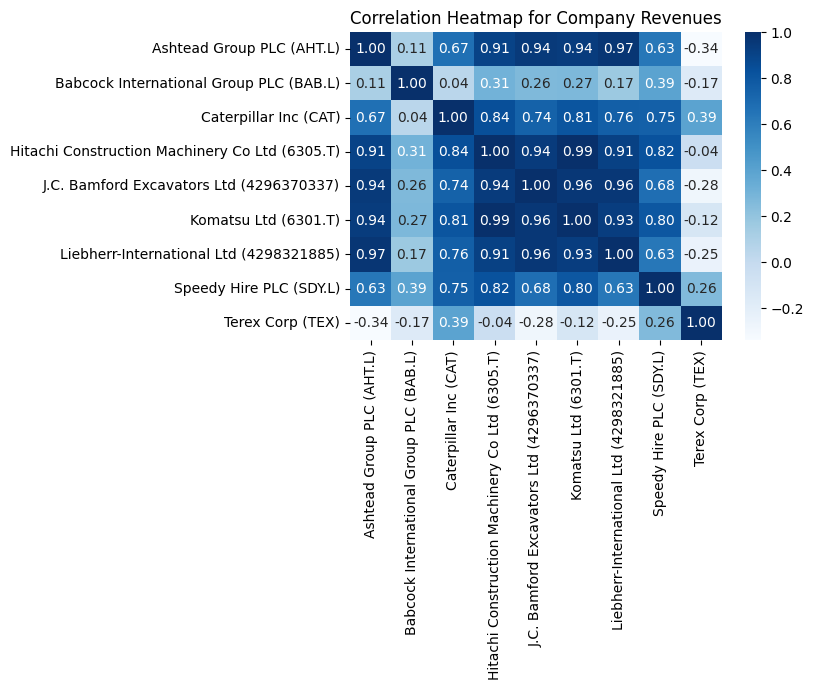

In [136]:
# Correlation Analysis
plt.figure(figsize=(6, 4))
sns.heatmap(df_company_revenue.drop(columns=['Date', 'Year', 'Month', 'Day']).corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap for Company Revenues')
plt.show()

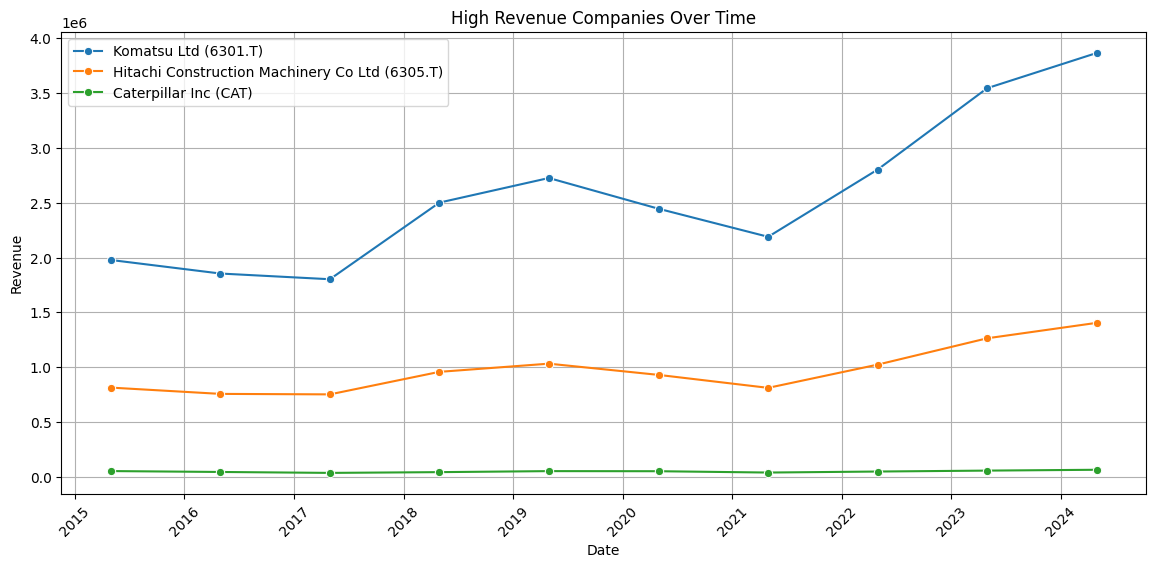

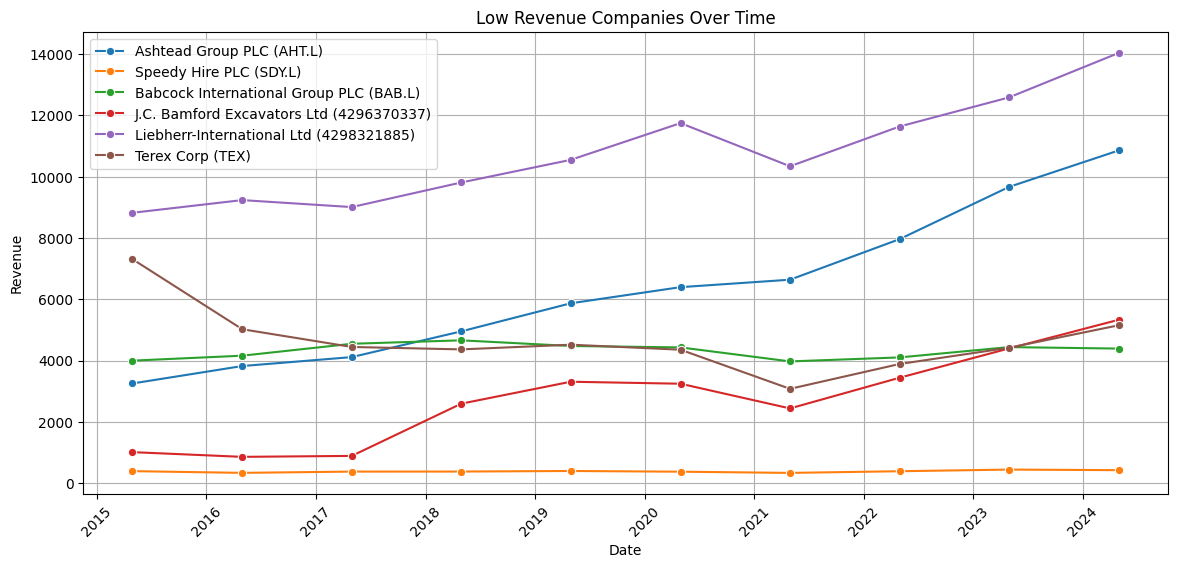

In [139]:
high_revenue_companies = ['Komatsu Ltd (6301.T)', 'Hitachi Construction Machinery Co Ltd (6305.T)', 'Caterpillar Inc (CAT)']
low_revenue_companies = ['Ashtead Group PLC (AHT.L)', 'Speedy Hire PLC (SDY.L)', 'Babcock International Group PLC (BAB.L)', 'J.C. Bamford Excavators Ltd (4296370337)', 'Liebherr-International Ltd (4298321885)',  'Terex Corp (TEX)']

# Plot for high-revenue companies
plt.figure(figsize=(14, 6))
for company in high_revenue_companies:
    sns.lineplot(data=df_company_revenue, x='Date', y=company, label=company, marker='o')
plt.title('High Revenue Companies Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Plot for low-revenue companies
plt.figure(figsize=(14, 6))
for company in low_revenue_companies:
    sns.lineplot(data=df_company_revenue, x='Date', y=company, label=company, marker='o')
plt.title('Low Revenue Companies Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


## Operating Expenses

In [140]:
df_operating_expenses = pd.read_excel(r"D:\CU_Coding_Files\BAM\Integrated_Data_BAM.xlsx", sheet_name="operating_expenses")
df_operating_expenses

Date  Ashtead Group PLC (AHT.L)  \
0  30-04-2024                     7499.9   
1  30-04-2023                     6644.0   
2  30-04-2022                     5744.0   
3  30-04-2021                     4776.2   
4  30-04-2020                     4544.6   
5  30-04-2019                     4078.4   
6  30-04-2018                     3452.9   
7  30-04-2017                     2827.1   
8  30-04-2016                     2545.3   
9  30-04-2015                     2250.9   

   Babcock International Group PLC (BAB.L)  Column1  Caterpillar Inc (CAT)  \
0                                   4182.4     7849                  52284   
1                                   4168.2     7465                  49734   
2                                   4045.3     7095                  43548   
3                                   4088.1     7311                  36252   
4                                   4143.9     7203                  44490   
5                                   4122.6     6542                  45321   
6                                   4397.0     6852                  39100   
7                                   4308.8     6844                  35165   
8                                   3927.5     7022                  41088   
9                                   3743.9     7167                  50816   

   Hitachi Construction Machinery Co Ltd (6305.T)  \
0                                         1237663   
1                                         1126844   
2                                          929751   
3                                          779733   
4                                          855162   
5                                          924557   
6                                          861995   
7                                          726520   
8                                          735836   
9                                          751716   

   J.C. Bamford Excavators Ltd (4296370337)  Komatsu Ltd (6301.T)  \
0                                    4803.9               3251394   
1                                    4017.4               3045400   
2                                    3121.8               2484238   
3                                    2323.5               2017735   
4                                    2977.2               2188004   
5                                    3042.9               2324497   
6                                    2468.9               2206707   
7                                     924.4               1625553   
8                                     880.2               1650431   
9                                     963.0               1737203   

   Liebherr-International Ltd (4298321885)  Speedy Hire PLC (SDY.L)  \
0                                    13423                    397.6   
1                                    12135                    436.8   
2                                    10927                    355.2   
3                                     9925                    311.4   
4                                    11147                    339.4   
5                                     9919                    358.7   
6                                     9208                    344.0   
7                                     8600                    351.9   
8                                     8704                    321.8   
9                                     8304                    368.5   

   Terex Corp (TEX)  
0            4514.7  
1            3996.6  
2            3552.5  
3            3002.5  
4            4008.3  
5            4097.3  
6            4190.6  
7            4350.5  
8            4694.3  
9            6874.5

In [141]:
df_operating_expenses.drop(columns = 'Column1', inplace=True)

df_operating_expenses

Date  Ashtead Group PLC (AHT.L)  \
0  30-04-2024                     7499.9   
1  30-04-2023                     6644.0   
2  30-04-2022                     5744.0   
3  30-04-2021                     4776.2   
4  30-04-2020                     4544.6   
5  30-04-2019                     4078.4   
6  30-04-2018                     3452.9   
7  30-04-2017                     2827.1   
8  30-04-2016                     2545.3   
9  30-04-2015                     2250.9   

   Babcock International Group PLC (BAB.L)  Caterpillar Inc (CAT)  \
0                                   4182.4                  52284   
1                                   4168.2                  49734   
2                                   4045.3                  43548   
3                                   4088.1                  36252   
4                                   4143.9                  44490   
5                                   4122.6                  45321   
6                                   4397.0                  39100   
7                                   4308.8                  35165   
8                                   3927.5                  41088   
9                                   3743.9                  50816   

   Hitachi Construction Machinery Co Ltd (6305.T)  \
0                                         1237663   
1                                         1126844   
2                                          929751   
3                                          779733   
4                                          855162   
5                                          924557   
6                                          861995   
7                                          726520   
8                                          735836   
9                                          751716   

   J.C. Bamford Excavators Ltd (4296370337)  Komatsu Ltd (6301.T)  \
0                                    4803.9               3251394   
1                                    4017.4               3045400   
2                                    3121.8               2484238   
3                                    2323.5               2017735   
4                                    2977.2               2188004   
5                                    3042.9               2324497   
6                                    2468.9               2206707   
7                                     924.4               1625553   
8                                     880.2               1650431   
9                                     963.0               1737203   

   Liebherr-International Ltd (4298321885)  Speedy Hire PLC (SDY.L)  \
0                                    13423                    397.6   
1                                    12135                    436.8   
2                                    10927                    355.2   
3                                     9925                    311.4   
4                                    11147                    339.4   
5                                     9919                    358.7   
6                                     9208                    344.0   
7                                     8600                    351.9   
8                                     8704                    321.8   
9                                     8304                    368.5   

   Terex Corp (TEX)  
0            4514.7  
1            3996.6  
2            3552.5  
3            3002.5  
4            4008.3  
5            4097.3  
6            4190.6  
7            4350.5  
8            4694.3  
9            6874.5

In [142]:
df_operating_expenses.describe().round(2)

Ashtead Group PLC (AHT.L)  Babcock International Group PLC (BAB.L)  \
count                      10.00                                    10.00   
mean                     4436.33                                  4112.77   
std                      1768.03                                   183.71   
min                      2250.90                                  3743.90   
25%                      2983.55                                  4056.00   
50%                      4311.50                                  4133.25   
75%                      5502.05                                  4178.85   
max                      7499.90                                  4397.00   

       Caterpillar Inc (CAT)  Hitachi Construction Machinery Co Ltd (6305.T)  \
count                  10.00                                           10.00   
mean                43779.80                                       892977.70   
std                  5965.12                                       171082.11   
min                 35165.00                                       726520.00   
25%                 39597.00                                       758720.25   
50%                 44019.00                                       858578.50   
75%                 48630.75                                       928452.50   
max                 52284.00                                      1237663.00   

       J.C. Bamford Excavators Ltd (4296370337)  Komatsu Ltd (6301.T)  \
count                                     10.00                 10.00   
mean                                    2552.32            2253116.20   
std                                     1333.04             554558.27   
min                                      880.20            1625553.00   
25%                                     1303.12            1807336.00   
50%                                     2723.05            2197355.50   
75%                                     3102.08            2444302.75   
max                                     4803.90            3251394.00   

       Liebherr-International Ltd (4298321885)  Speedy Hire PLC (SDY.L)  \
count                                    10.00                    10.00   
mean                                  10229.20                   358.53   
std                                    1669.34                    36.45   
min                                    8304.00                   311.40   
25%                                    8830.00                   340.55   
50%                                    9922.00                   353.55   
75%                                   11092.00                   366.05   
max                                   13423.00                   436.80   

       Terex Corp (TEX)  
count             10.00  
mean            4328.18  
std             1016.35  
min             3002.50  
25%             3999.52  
50%             4143.95  
75%             4473.65  
max             6874.50

In [143]:
df_operating_expenses.isnull().sum()    

Date                                              0
Ashtead Group PLC (AHT.L)                         0
Babcock International Group PLC (BAB.L)           0
Caterpillar Inc (CAT)                             0
Hitachi Construction Machinery Co Ltd (6305.T)    0
J.C. Bamford Excavators Ltd (4296370337)          0
Komatsu Ltd (6301.T)                              0
Liebherr-International Ltd (4298321885)           0
Speedy Hire PLC (SDY.L)                           0
Terex Corp (TEX)                                  0
dtype: int64

In [144]:
df_operating_expenses['Date'] = pd.to_datetime(df_operating_expenses['Date'], errors='coerce')
   
# Extracting time-based features
df_operating_expenses['Year'] = df_operating_expenses['Date'].dt.year
df_operating_expenses['Month'] = df_operating_expenses['Date'].dt.month
df_operating_expenses['Day'] = df_operating_expenses['Date'].dt.day
df_operating_expenses

C:\Users\neera\AppData\Local\Temp\ipykernel_15812\2852277786.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_operating_expenses['Date'] = pd.to_datetime(df_operating_expenses['Date'], errors='coerce')


Date  Ashtead Group PLC (AHT.L)  \
0 2024-04-30                     7499.9   
1 2023-04-30                     6644.0   
2 2022-04-30                     5744.0   
3 2021-04-30                     4776.2   
4 2020-04-30                     4544.6   
5 2019-04-30                     4078.4   
6 2018-04-30                     3452.9   
7 2017-04-30                     2827.1   
8 2016-04-30                     2545.3   
9 2015-04-30                     2250.9   

   Babcock International Group PLC (BAB.L)  Caterpillar Inc (CAT)  \
0                                   4182.4                  52284   
1                                   4168.2                  49734   
2                                   4045.3                  43548   
3                                   4088.1                  36252   
4                                   4143.9                  44490   
5                                   4122.6                  45321   
6                                   4397.0                  39100   
7                                   4308.8                  35165   
8                                   3927.5                  41088   
9                                   3743.9                  50816   

   Hitachi Construction Machinery Co Ltd (6305.T)  \
0                                         1237663   
1                                         1126844   
2                                          929751   
3                                          779733   
4                                          855162   
5                                          924557   
6                                          861995   
7                                          726520   
8                                          735836   
9                                          751716   

   J.C. Bamford Excavators Ltd (4296370337)  Komatsu Ltd (6301.T)  \
0                                    4803.9               3251394   
1                                    4017.4               3045400   
2                                    3121.8               2484238   
3                                    2323.5               2017735   
4                                    2977.2               2188004   
5                                    3042.9               2324497   
6                                    2468.9               2206707   
7                                     924.4               1625553   
8                                     880.2               1650431   
9                                     963.0               1737203   

   Liebherr-International Ltd (4298321885)  Speedy Hire PLC (SDY.L)  \
0                                    13423                    397.6   
1                                    12135                    436.8   
2                                    10927                    355.2   
3                                     9925                    311.4   
4                                    11147                    339.4   
5                                     9919                    358.7   
6                                     9208                    344.0   
7                                     8600                    351.9   
8                                     8704                    321.8   
9                                     8304                    368.5   

   Terex Corp (TEX)  Year  Month  Day  
0            4514.7  2024      4   30  
1            3996.6  2023      4   30  
2            3552.5  2022      4   30  
3            3002.5  2021      4   30  
4            4008.3  2020      4   30  
5            4097.3  2019      4   30  
6            4190.6  2018      4   30  
7            4350.5  2017      4   30  
8            4694.3  2016      4   30  
9            6874.5  2015      4   30

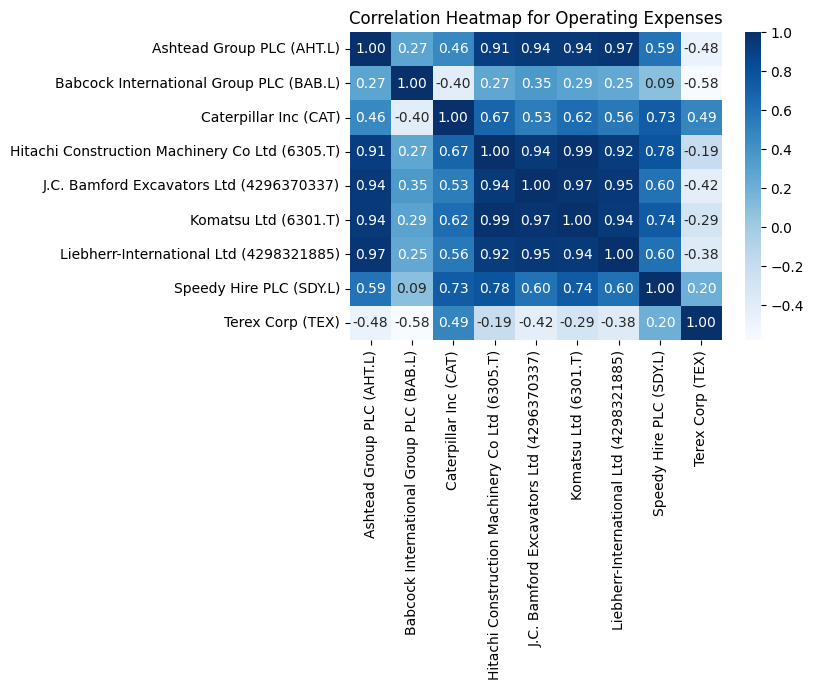

In [145]:
# Correlation Analysis
plt.figure(figsize=(6, 4))
sns.heatmap(df_operating_expenses.drop(columns=['Date', 'Year', 'Month', 'Day']).corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap for Operating Expenses')
plt.show()

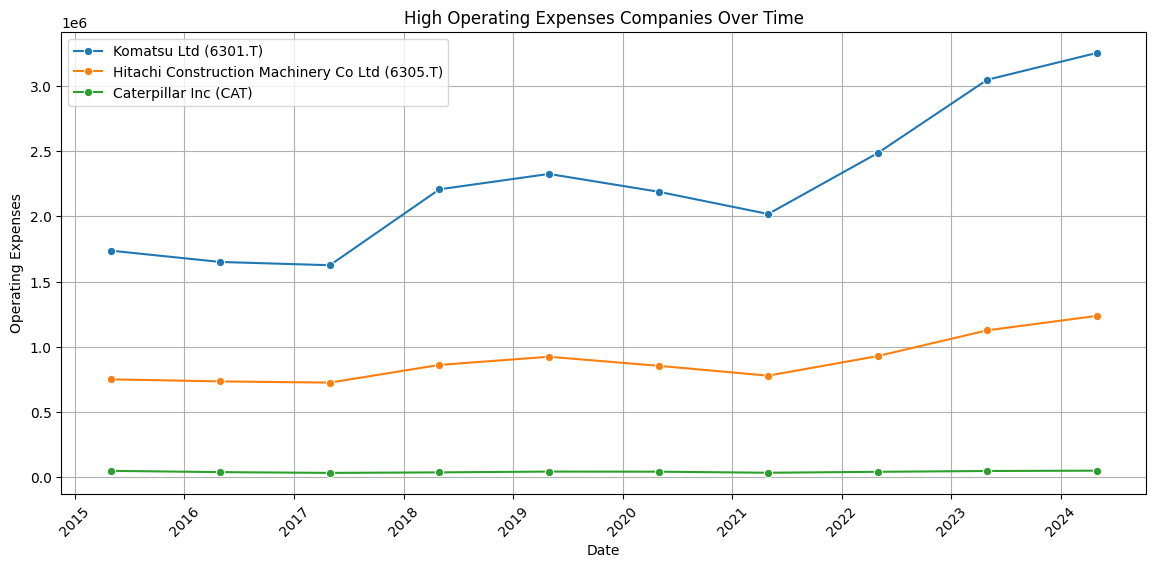

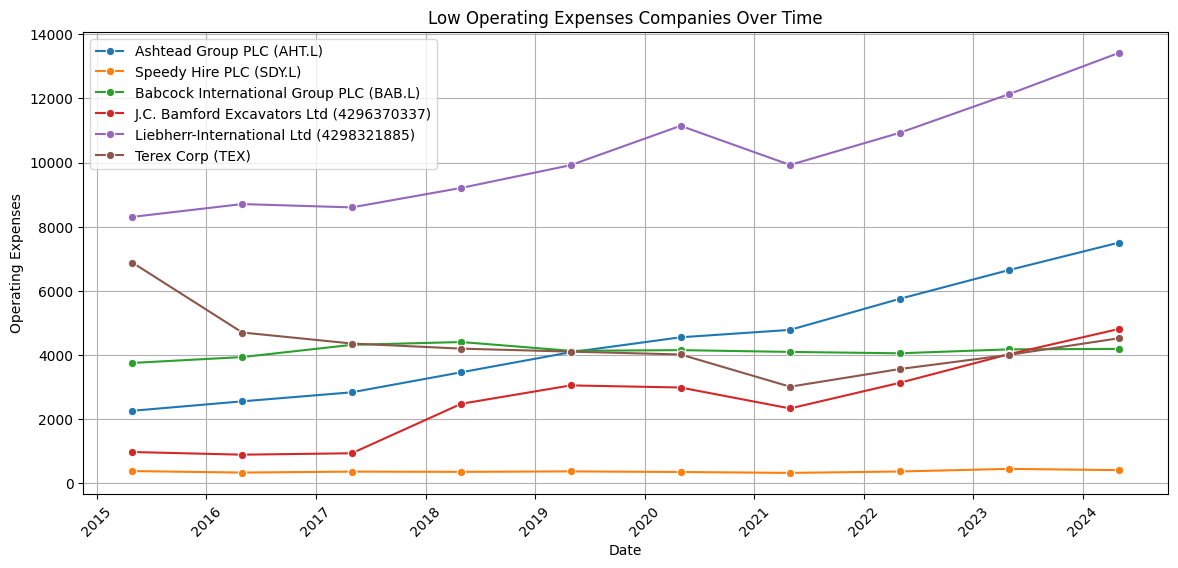

In [148]:
high_revenue_companies = ['Komatsu Ltd (6301.T)', 'Hitachi Construction Machinery Co Ltd (6305.T)', 'Caterpillar Inc (CAT)']
low_revenue_companies = ['Ashtead Group PLC (AHT.L)', 'Speedy Hire PLC (SDY.L)', 'Babcock International Group PLC (BAB.L)', 'J.C. Bamford Excavators Ltd (4296370337)', 'Liebherr-International Ltd (4298321885)',  'Terex Corp (TEX)']

# Plot for high-revenue companies
plt.figure(figsize=(14, 6))
for company in high_revenue_companies:
    sns.lineplot(data=df_operating_expenses, x='Date', y=company, label=company, marker='o')
plt.title('High Operating Expenses Companies Over Time')
plt.xlabel('Date')
plt.ylabel('Operating Expenses')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Plot for low-revenue companies
plt.figure(figsize=(14, 6))
for company in low_revenue_companies:
    sns.lineplot(data=df_operating_expenses, x='Date', y=company, label=company, marker='o')
plt.title('Low Operating Expenses Companies Over Time')
plt.xlabel('Date')
plt.ylabel('Operating Expenses')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


## Reading the data

In [ ]:
xlsx = pd.read_excel('Integrated_Data_BAM.xlsx', sheet_name=None, header=0)
for sheet in xlsx.keys(): xlsx[sheet].to_excel(sheet+'.xlsx', header=True, index=True)

## Data Preprocessing

In [ ]:
for key in xlsx.keys():
    print(key, ':\n', xlsx[key].isnull().sum())

unemployment_rate :
 YYMM                  0
Unenployment Rate     0
Population           10
dtype: int64
extra_unemployment_rate :
 Date                        0
Unemployment Rate           0
Unemployment (Thousands)    0
    Female                  0
    Male                    0
dtype: int64
gov_total_expense_revenue :
 YYMM                  0
Expense               0
Revenue               0
Surplus or Deficit    0
dtype: int64
money_supply :
 YYMM                  0
M1                    0
M2                    0
M2 YOY Growth Rate    0
M3                    0
M3 YOY Growth Rate    0
M4                    0
M4 YOY Growth Rate    0
dtype: int64
bonds :
 YYMM       0
5 Year     0
10 Year    0
20 Year    0
dtype: int64
cpi :
 YYMM                      0
CPI                       0
CPI Annual Growth Rate    0
dtype: int64
economic_growth :
 YYMM                        0
GBP to USD Exchange Rate    0
Economic Growth Rate        4
dtype: int64
import_export :
 YYMM      0
Import    0
Expo

In [ ]:
for key in xlsx.keys():
    xlsx[key].replace('--', np.nan, inplace=True)
    print(key, ':\n', xlsx[key])

unemployment_rate :
         YYMM  Unenployment Rate  Population
0    2024/10                4.3         NaN
1    2024/09                4.3         NaN
2    2024/08                4.1         NaN
3    2024/07                4.2         NaN
4    2024/06                4.2         NaN
..       ...                ...         ...
173  2010/05                7.9       62.76
174  2010/04                8.0       62.76
175  2010/03                8.0       62.76
176  2010/02                7.9       62.76
177  2010/01                7.7       62.76

[178 rows x 3 columns]
extra_unemployment_rate :
         Date  Unemployment Rate  Unemployment (Thousands)      Female  \
0   Dec 2024                NaN                       NaN         NaN   
1   Nov 2024                4.4                    1568.0         4.2   
2   Oct 2024                4.3                    1508.0         4.0   
3   Sep 2024                4.3                    1509.0         4.1   
4   Aug 2024                4.1    

In [ ]:
for key in xlsx.keys() - {'uk_home_retail'}:
    columns_to_fill = xlsx[key].columns[1:]
    
    # Calculate the median for the selected columns
    median_values = xlsx[key][columns_to_fill].median()
    
    # Fill NaN values with the median
    xlsx[key][columns_to_fill] = xlsx[key][columns_to_fill].fillna(median_values)

In [ ]:
xlsx['uk_home_retail'] = xlsx['uk_home_retail'].drop('UK Home Sales', axis=1)
xlsx['uk_home_retail'] = xlsx['uk_home_retail'].dropna(axis=1)
xlsx['construction_cost_prices_sales'] = xlsx['construction_cost_prices_sales'].dropna()

## Time features 

In [ ]:
import re

keys_q_only = [
    key for key in xlsx.keys()
    if not xlsx[key].empty  # Vérifie que le DataFrame n'est pas vide
    and xlsx[key].shape[1] > 0  # Vérifie qu'il a au moins une colonne
    and xlsx[key][xlsx[key].columns[0]].astype(str)  # Convertit en str
        .str.match(r'^Q', na=False)  # Vérifie que toutes les valeurs commencent par "Q"
        .all()  # S'assure que c'est vrai pour toute la colonne
]

In [ ]:
for key in xlsx.keys() - set(keys_q_only):
    xlsx[key][xlsx[key].columns[0]] = pd.to_datetime(xlsx[key][xlsx[key].columns[0]], errors='coerce')
    
for key in keys_q_only:
    # Extraction du Quarter et de l'Année
    xlsx[key][xlsx[key].columns[0]] = pd.to_datetime(xlsx[key][xlsx[key].columns[0]].str[-4:] + xlsx[key][xlsx[key].columns[0]].str[:2])

In [ ]:
def to_snake_case(col_name):
    col_name = re.sub(r'([a-z])([A-Z])', r'\1_\2', col_name)  # Convert camelCase/PascalCase to snake_case
    col_name = re.sub(r'\W+', '_', col_name)  # Replace non-word characters (spaces, special chars) with "_"
    col_name = re.sub(r'__+', '_', col_name)  # Replace multiple "_" with a single "_"
    return col_name.lower().strip('_')  # Convert to lowercase and remove leading/trailing "_"

In [ ]:
for key in xlsx.keys():
    xlsx[key].columns = [to_snake_case(xlsx[key].columns[0])] + [f"{key}.{to_snake_case(col)}" for col in xlsx[key].columns[1:]]
    xlsx[key] = xlsx[key].rename(columns={'yymm': 'date', 'revenues': 'date'})

In [ ]:
#drop duplicated time samples
xlsx['uk_home_retail'] = xlsx['uk_home_retail'].sort_values('date', ascending=False).drop_duplicates('date').sort_index()

In [ ]:
for key in xlsx.keys():
    xlsx[key] = xlsx[key].sort_values('date', ascending=False)

## Merging the data into one dataset

In [ ]:
def reformat_trimestrielle(df):
    df_expanded = pd.DataFrame()
    for _, row in df.iterrows():
        # Créer 3 mois à partir de la date du trimestre
        months = pd.date_range(start=row['date'], periods=3, freq='ME')
        expanded = pd.DataFrame([row.to_dict()] * 3)
        expanded['date'] = months
        df_expanded = pd.concat([df_expanded, expanded], ignore_index=True)
    return df_expanded

def reformat_annuelle(df):
    df_expanded = pd.DataFrame()
    for _, row in df.iterrows():
        # Créer 12 mois à partir de la date annuelle
        months = pd.date_range(start=row['date'], periods=12, freq='ME')
        expanded = pd.DataFrame([row.to_dict()] * 12)
        expanded['date'] = months
        df_expanded = pd.concat([df_expanded, expanded], ignore_index=True)
    return df_expanded

In [ ]:
def process_data(xlsx):
    result = pd.DataFrame()
    data_frames = []
    for sheet_name, df in xlsx.items():

        # Identifier la granularité des données
        freq = pd.infer_freq(df['date'].sort_values())

        if 'Y' in freq:  # Données annuelles
            df_processed = reformat_annuelle(df)
        elif 'Q' in freq:  # Données trimestrielles
            df_processed = reformat_trimestrielle(df)
        elif 'MS' in freq:  # Données mensuelles (aucune duplication)
            df_processed = df.copy()
        data_frames.append(df)

    result = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), data_frames).bfill()
    result = result.ffill()
    
    result['year'] = result['date'].dt.year
    result['month'] = result['date'].dt.month
    result['day'] = result['date'].dt.day
    
    return result

In [ ]:
# Traitement des données
df_final = process_data(xlsx)
df_final.head()

date  unemployment_rate.unenployment_rate  \
0 2010-01-01                                  7.7   
1 2010-02-01                                  7.9   
2 2010-03-01                                  8.0   
3 2010-04-01                                  8.0   
4 2010-05-01                                  7.9   

   unemployment_rate.population  extra_unemployment_rate.unemployment_rate  \
0                         62.76                                        4.2   
1                         62.76                                        4.2   
2                         62.76                                        4.2   
3                         62.76                                        4.2   
4                         62.76                                        4.2   

   extra_unemployment_rate.unemployment_thousands  \
0                                          1413.0   
1                                          1413.0   
2                                          1413.0   
3                                          1413.0   
4                                          1413.0   

   extra_unemployment_rate.female  extra_unemployment_rate.male  \
0                             4.1                           4.2   
1                             4.1                           4.2   
2                             4.1                           4.2   
3                             4.1                           4.2   
4                             4.1                           4.2   

   gov_total_expense_revenue.expense  gov_total_expense_revenue.revenue  \
0                             719.49                             570.64   
1                             719.49                             570.64   
2                             719.49                             570.64   
3                             719.49                             570.64   
4                             719.49                             570.64   

   gov_total_expense_revenue.surplus_or_deficit  ...  \
0                                       -148.85  ...   
1                                       -148.85  ...   
2                                       -148.85  ...   
3                                       -148.85  ...   
4                                       -148.85  ...   

   operating_expenses.caterpillar_inc_cat  \
0                                 50816.0   
1                                 50816.0   
2                                 50816.0   
3                                 50816.0   
4                                 50816.0   

   operating_expenses.hitachi_construction_machinery_co_ltd_6305_t  \
0                                           751716.0                 
1                                           751716.0                 
2                                           751716.0                 
3                                           751716.0                 
4                                           751716.0                 

   operating_expenses.j_c_bamford_excavators_ltd_4296370337  \
0                                              963.0          
1                                              963.0          
2                                              963.0          
3                                              963.0          
4                                              963.0          

   operating_expenses.komatsu_ltd_6301_t  \
0                              1737203.0   
1                              1737203.0   
2                              1737203.0   
3                              1737203.0   
4                              1737203.0   

   operating_expenses.liebherr_international_ltd_4298321885  \
0                                             8304.0          
1                                             8304.0          
2                                             8304.0          
3                                             8304.0          
4                                             8304.0       

## Regression

### unemployment rate 

In [ ]:
X = df_final[['year', 'month', 'unemployment_rate.population']]
y = df_final['unemployment_rate.unenployment_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

print("Intercept: ", model.intercept_)
print("Coefficients:")
list(zip(X.columns, model.coef_))

Intercept:  259.11665837050043
Coefficients:


[('year', -0.10444455403082605),
 ('month', -0.009424240917334403),
 ('unemployment_rate.population', -0.6541679824453834)]

In [ ]:
y_pred = model.predict(X_test)

mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
mlr_diff.head()

Actual value  Predicted value
152           3.9         3.564874
75            5.1         5.582037
158           3.6         3.517753
66            5.6         6.011459
60            5.6         6.058580

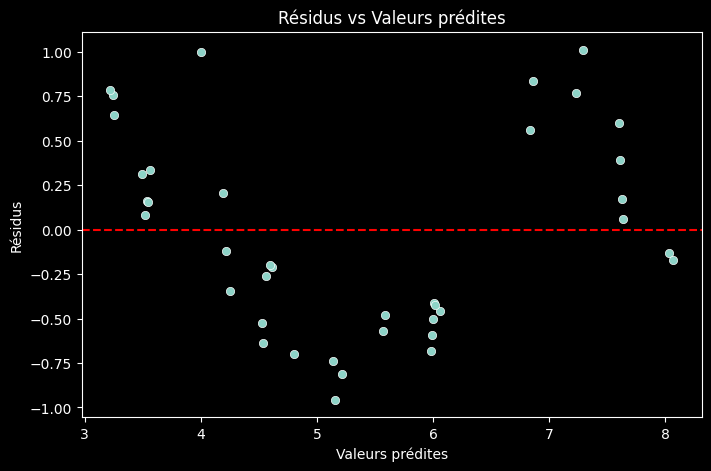

In [ ]:
# Résidus
residuals = y_test - y_pred

# Graphique des résidus
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Résidus vs Valeurs prédites")
plt.show()

In [ ]:
import statsmodels.api as sm
X_test_sm = sm.add_constant(X_test)
bp_test = het_breuschpagan(residuals, X_test_sm)

# Résultats
labels = ['Statistique LM', 'p-value', 'F-statistique', 'p-value F']
print(dict(zip(labels, bp_test)))

{'Statistique LM': 3.014557837290796, 'p-value': 0.3893860856182448, 'F-statistique': 0.9773352589649403, 'p-value F': 0.4145042612624642}


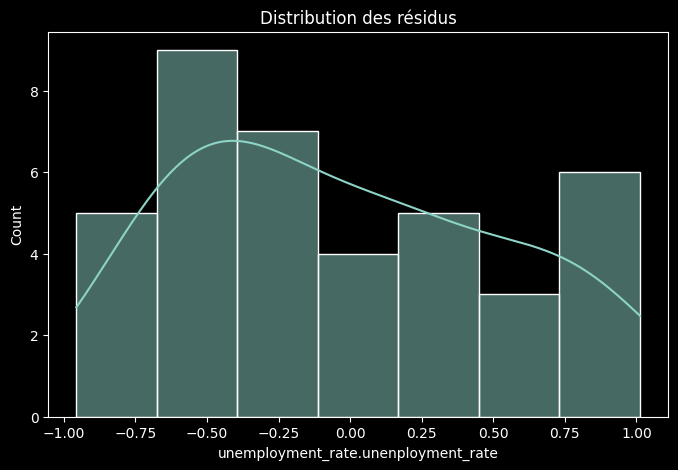

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Distribution des résidus")
plt.show()

In [ ]:
X_vif = sm.add_constant(X)  # Ajout de la constante
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i+1) for i in range(len(X.columns))]

print(vif_data)

                       Variable       VIF
0                          year  5.341388
1                         month  1.001763
2  unemployment_rate.population  5.337318


In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R²:", r2)

MSE: 0.304898695907041
R²: 0.8816690269514406


In [ ]:
def linear_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()

    model.fit(X_train, y_train)

    print("Intercept: ", model.intercept_)
    print("Coefficients:")
    print(list(zip(X.columns, model.coef_)))

    y_pred = model.predict(X_test)

    meanAbErr = metrics.mean_absolute_error(y_test, y_pred)
    meanSqErr = metrics.mean_squared_error(y_test, y_pred)
    rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    print('R^2: {:.2f}'.format(r2_score(y_test, y_pred)))

    #Mean Absolute Error is the absolute difference between the true values and the predicted values.
    #The lower the value, the better is the model’s performance.
    print('Mean Absolute Error:', meanAbErr)

    #Mean Square Error is calculated by taking the average of the square of the difference between the original and predicted values of the data.
    #The lower the value, the better is the model’s performance.
    print('Mean Square Error:', meanSqErr)

    #Root Mean Square Error is the standard deviation of the errors which occur when a prediction is made on a dataset. 
    #The root of the value is considered while determining the accuracy of the model.
    print('Root Mean Square Error:', rootMeanSqErr)
    
    return {'model': model, 'y_test': y_test, 'y_pred': y_pred}

In [ ]:
linear_regression(X, y)

Intercept:  259.11665837050043
Coefficients:
[('year', -0.10444455403082605), ('month', -0.009424240917334403), ('unemployment_rate.population', -0.6541679824453834)]
R^2: 0.88
Mean Absolute Error: 0.4813065295848051
Mean Square Error: 0.304898695907041
Root Mean Square Error: 0.5521763268259886


{'model': LinearRegression(),
 'y_test': 152    3.9
 75     5.1
 158    3.6
 66     5.6
 60     5.6
 15     7.7
 9      7.9
 16     7.8
 128    4.1
 125    3.9
 139    5.0
 156    3.7
 18     8.0
 161    3.8
 112    3.9
 181    4.4
 155    3.7
 65     5.6
 165    4.0
 42     7.7
 30     8.0
 24     8.3
 67     5.5
 98     4.4
 69     5.3
 113    4.0
 96     4.2
 19     8.2
 45     7.4
 76     5.0
 169    4.0
 68     5.4
 5      7.9
 132    4.4
 90     4.4
 164    3.9
 108    4.1
 182    4.4
 186    4.3
 Name: unemployment_rate.unenployment_rate, dtype: float64,
 'y_pred': array([3.56487411, 5.58203667, 3.5177529 , 6.01145922, 6.05858042,
        7.63867164, 8.03327978, 7.6292474 , 4.219374  , 4.24764672,
        4.00294433, 3.53660139, 7.61039892, 3.48948018, 4.53525831,
        4.60949324, 3.54602563, 6.02088346, 3.24455412, 6.86509207,
        7.23120381, 7.28774926, 6.00203497, 5.13764844, 5.98318649,
        4.52583407, 5.15649692, 7.60097468, 6.83681934, 5.57261243,
        3.2162

Intercept:  246472.08079173107
Coefficients:
[('gov_total_expense_revenue.expense', 8.45500722639139), ('gov_total_expense_revenue.revenue', 11.736450969087896), ('year', -127.78173894638795), ('month', 49.972036400222606), ('day', -12.291747305326428)]
R^2: 0.97
Mean Absolute Error: 353.75056184157705
Mean Square Error: 206025.30007410867
Root Mean Square Error: 453.90009922240455


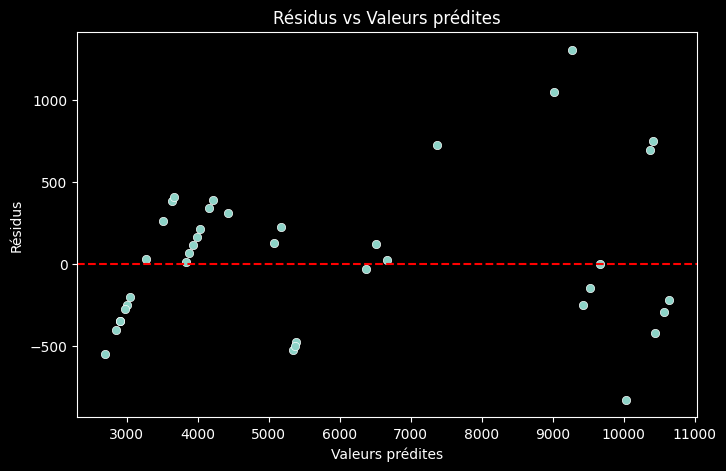

Intercept:  -99942.3828387725
Coefficients:
[('gov_total_expense_revenue.expense', -2.603385103405562), ('gov_total_expense_revenue.revenue', 2.207250375092841), ('year', 51.94440220519304), ('month', 2.374918360436111), ('day', 0.5649976560417413)]
R^2: 0.42
Mean Absolute Error: 115.11440046609746
Mean Square Error: 27363.69342442448
Root Mean Square Error: 165.4197491970789


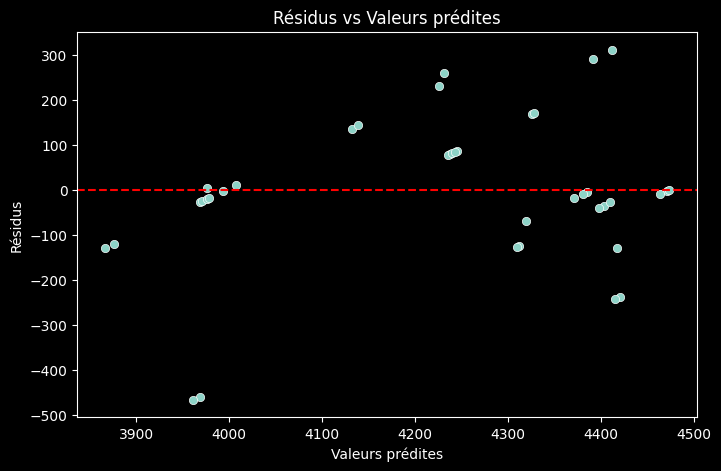

Intercept:  307123.2639582515
Coefficients:
[('gov_total_expense_revenue.expense', 3.30954152793788), ('gov_total_expense_revenue.revenue', 1.9424269064138728), ('year', -150.87434147060713), ('month', 2.0529653004043293), ('day', -2.4601862427025605)]
R^2: 0.76
Mean Absolute Error: 126.20548500992113
Mean Square Error: 31302.272919381074
Root Mean Square Error: 176.92448366289238


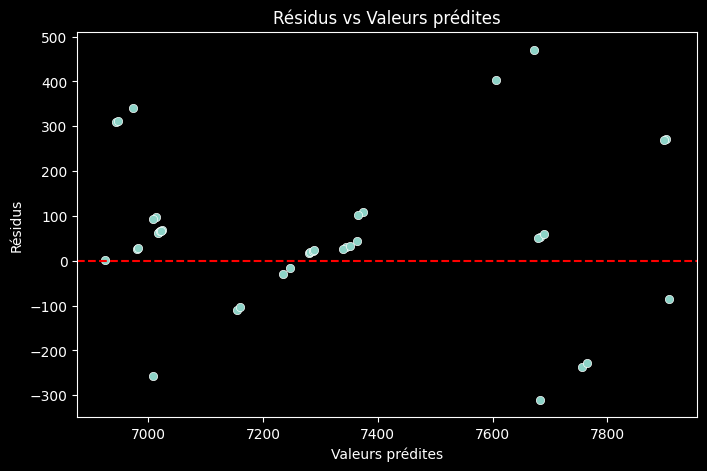

Intercept:  8422272.539836498
Coefficients:
[('gov_total_expense_revenue.expense', 33.07946389035623), ('gov_total_expense_revenue.revenue', 101.70993581305598), ('year', -4203.146852683545), ('month', 95.0142406300449), ('day', 8.833227505905352)]
R^2: 0.43
Mean Absolute Error: 4180.987174285719
Mean Square Error: 27422091.047209647
Root Mean Square Error: 5236.610644988765


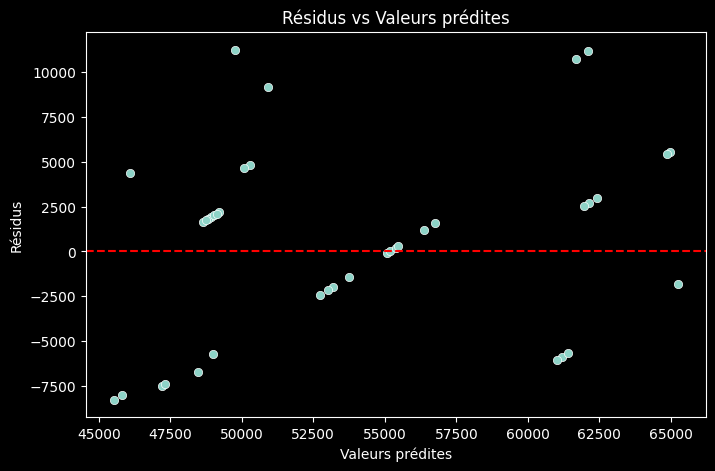

Intercept:  108259314.185132
Coefficients:
[('gov_total_expense_revenue.expense', 310.1646207407178), ('gov_total_expense_revenue.revenue', 2430.4576516130173), ('year', -54281.186090869574), ('month', 3452.658394649346), ('day', -458.01365026589855)]
R^2: 0.83
Mean Absolute Error: 69412.26737217185
Mean Square Error: 8227046881.615481
Root Mean Square Error: 90703.06985772577


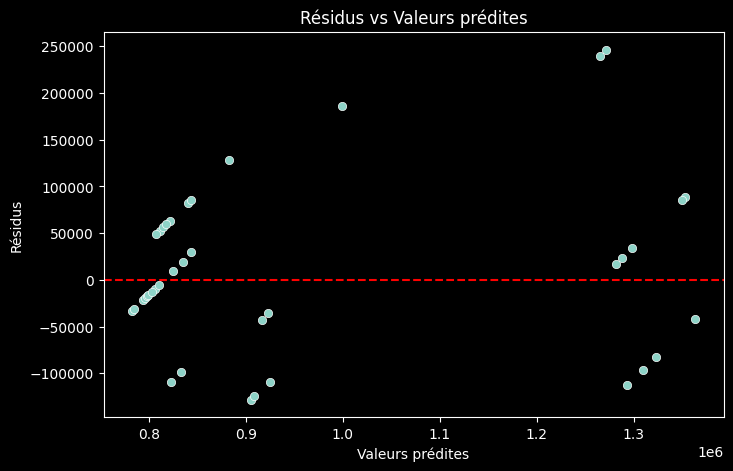

Intercept:  66000.75472898797
Coefficients:
[('gov_total_expense_revenue.expense', 2.060245026224499), ('gov_total_expense_revenue.revenue', 8.538454044154118), ('year', -35.82011901757203), ('month', 28.76976165641155), ('day', -4.093942180113926)]
R^2: 0.87
Mean Absolute Error: 495.98548016511575
Mean Square Error: 323943.1862174975
Root Mean Square Error: 569.1600708214671


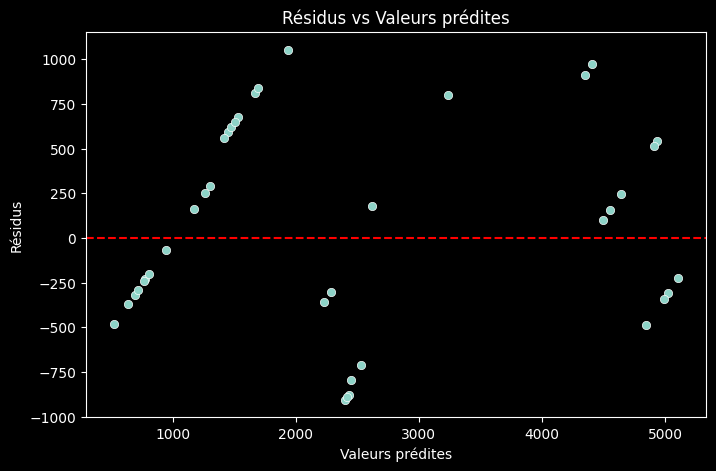

Intercept:  278457580.5937613
Coefficients:
[('gov_total_expense_revenue.expense', 1223.3012094990943), ('gov_total_expense_revenue.revenue', 6738.70711800834), ('year', -139994.75701252316), ('month', 11501.78052244842), ('day', -1180.9050365703795)]
R^2: 0.88
Mean Absolute Error: 190973.83360165052
Mean Square Error: 63009209429.95023
Root Mean Square Error: 251016.35291341128


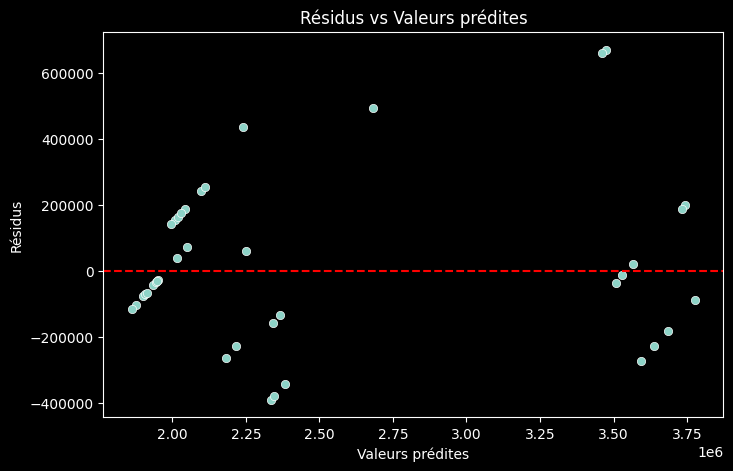

Intercept:  197879.98072925498
Coefficients:
[('gov_total_expense_revenue.expense', 4.3484971866690705), ('gov_total_expense_revenue.revenue', 9.420941195430547), ('year', -98.61354123851471), ('month', 36.25706061906085), ('day', -7.6744021386791585)]
R^2: 0.91
Mean Absolute Error: 419.38531532964913
Mean Square Error: 281819.0655809077
Root Mean Square Error: 530.866334947798


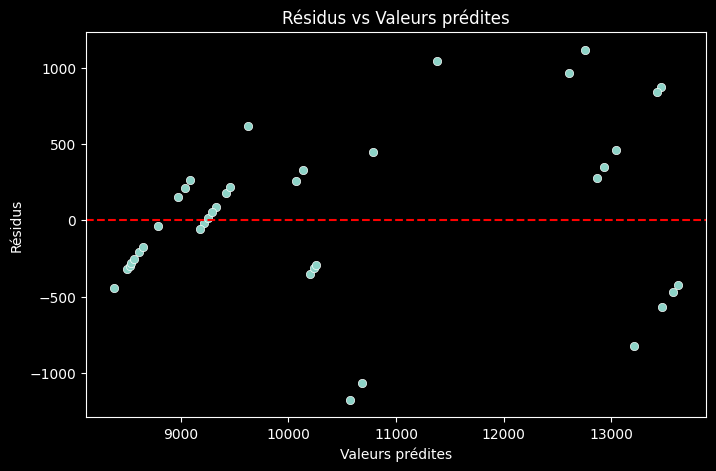

Intercept:  30894.49233800927
Coefficients:
[('gov_total_expense_revenue.expense', 0.0070038050250136406), ('gov_total_expense_revenue.revenue', 0.4995208373258148), ('year', -15.320294179068867), ('month', 0.25128226959563255), ('day', -0.05409019979496211)]
R^2: 0.55
Mean Absolute Error: 17.822190665751098
Mean Square Error: 534.2945835941331
Root Mean Square Error: 23.114813077205124


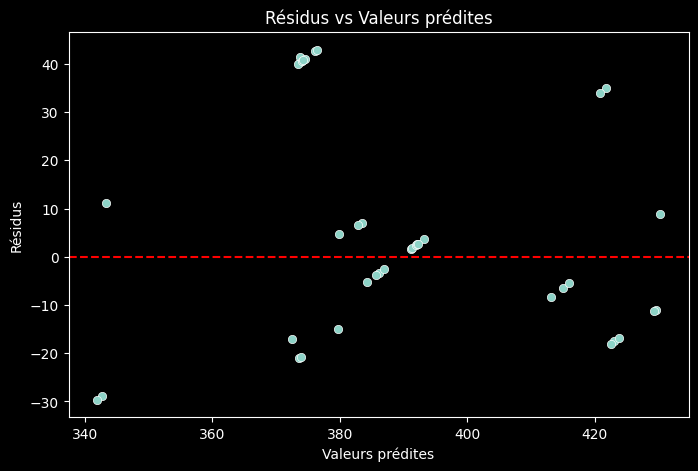

Intercept:  1632687.9144932108
Coefficients:
[('gov_total_expense_revenue.expense', 3.78055458647351), ('gov_total_expense_revenue.revenue', 12.300538449709046), ('year', -813.0668915183112), ('month', -18.92630413600008), ('day', 1.1263015604820092)]
R^2: 0.75
Mean Absolute Error: 588.3723094643154
Mean Square Error: 447380.7963638198
Root Mean Square Error: 668.8653050979844


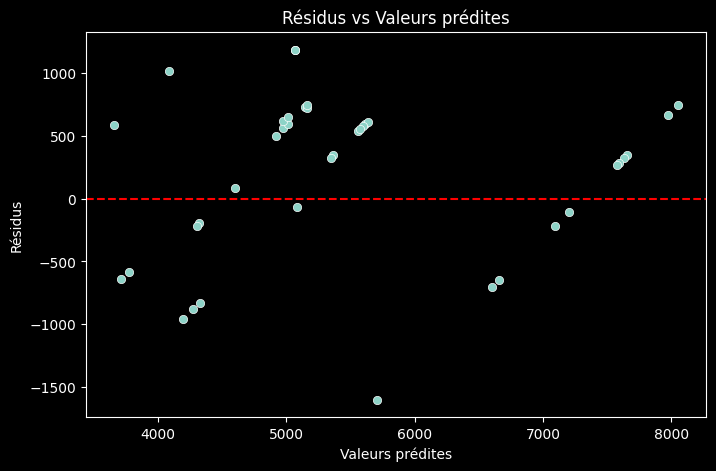

In [ ]:
for name in xlsx['company_revenue'].columns[1:]:
    y = df_final[name]

    L = list(xlsx['gov_total_expense_revenue'].columns)
    L.append('year')
    L.append('month')
    L.append('day')


    X = df_final[L]
    X = X.drop('date', axis=1)
    X = X.drop('gov_total_expense_revenue.surplus_or_deficit', axis=1)

    test = linear_regression(X, y)

    # Résidus
    residuals = test['y_pred'] - test['y_test']


    # Graphique des résidus

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=test['y_pred'], y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Résidus")
    plt.title("Résidus vs Valeurs prédites")
    plt.show()

In [ ]:
import statsmodels.formula.api as smf
def run_regression(df, dependent_var, independent_vars, independent_file):
    # Suppression du préfixe pour la variable dépendante
    dep_var_clean = dependent_var.split('.')[-1]


    X = df[[f"{independent_file}.{var}" for var in independent_vars[1:]]]

    # Ajout de la colonne 'year' qui n'a pas de préfixe
    X.loc[:, 'year'] = df[independent_vars[0]]

    new_col_names = [col.split('.')[-1] for col in independent_vars]
    X.columns = new_col_names

    # Extraction de la variable dépendante
    y = df[dependent_var]

    # Fusion des données
    df_model = X.join(y)
    df_model.columns = new_col_names + [dep_var_clean]

    # Construction de la formule de régression
    formula = f"{dep_var_clean} ~ {' + '.join(new_col_names)}"

    # Modélisation
    model = smf.ols(formula=formula, data=df_model).fit()

    return model.summary()

In [ ]:
result = run_regression(
    df=df_final,
    dependent_var='company_revenue.speedy_hire_plc_sdy_l',
    independent_vars=['year', 'gbp_to_usd_exchange_rate', 'economic_growth_rate'],
    independent_file='economic_growth'
)

result

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     speedy_hire_plc_sdy_l   R-squared:                       0.106
Model:                               OLS   Adj. R-squared:                  0.091
Method:                    Least Squares   F-statistic:                     7.356
Date:                   Sun, 09 Feb 2025   Prob (F-statistic):           0.000110
Time:                           20:47:17   Log-Likelihood:                -895.20
No. Observations:                    191   AIC:                             1798.
Df Residuals:                        187   BIC:                             1811.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -2963.5306   1676.134     -1.768      0.079   -6270.093     343.032
year                        -5.9561     23.756     -0.251      0.802     -52.821      40.909
gbp_to_usd_exchange_rate     0.7896      0.346      2.281      0.024       0.107       1.472
economic_growth_rate         1.6640      0.817      2.037      0.043       0.052       3.276
==============================================================================
Omnibus:                       14.868   Durbin-Watson:                   0.112
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.276
Skew:                          -0.709   Prob(JB):                     0.000292
Kurtosis:                       3.189   Cond. No.                     1.76e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
X = list(xlsx['unemployment_rate'].columns[1:]) 
X += list(xlsx['extra_unemployment_rate'].columns[3:5])
X.append(xlsx['gov_total_expense_revenue'].columns[3])
X += list(xlsx['money_supply'].columns[1:])
X += list(xlsx['bonds'].columns[1:])
X += list(xlsx['cpi'].columns[1:])
X += list(xlsx['economic_growth'].columns[1:])
X += list(xlsx['import_export'].columns[1:])
X += list(xlsx['seasonal_retail_sales'].columns[1:])
#X += list(xlsx['uk_home_retail'].columns[1:]) too many columns
X += list(xlsx['uk_building'].columns[1:])
#X += list(xlsx['uk_affordability_index'].columns[1:]) too many columns
X += list(xlsx['uk_retail_price'].columns[1:])
X += list(xlsx['mortage'].columns[1:])
X += list(xlsx['mortage_interest_rate'].columns[1:])
X.append(xlsx['construction_cost_prices_sales'].columns[1])
X += list(xlsx['construction_cost_prices_sales'].columns[3:5])
X += list(xlsx['construction_cost_prices_sales'].columns[6:])
X.append('year')

In [ ]:
def regression_analysis(df, dependent_var, independent_vars, show_feature_importance=False, n_splits=5, save_results=True, results_path='results.pkl'):
    results = []
    feature_importance_results = {}
    best_models = {}

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    X = df[independent_vars].copy()
    y = df[dependent_var].copy()

    # Test de normalité
    p_values = [shapiro(X[col])[1] for col in X.columns]
    normality_verified = all(p > 0.05 for p in p_values)

    scaler = StandardScaler() if normality_verified else MinMaxScaler()
    print(f"Data for {dependent_var} is standardized" if normality_verified else f"Data for {dependent_var} is normalized")

    model_results = []
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'Support Vector Regressor': SVR(),
        'MLP Regressor': MLPRegressor(random_state=42, max_iter=1000)
    }

    for k in range(3, 11):
        models[f'KNN (k={k})'] = KNeighborsRegressor(n_neighbors=k)

    for model_name, model in models.items():
        mae_train_scores, mae_test_scores, r2_scores = [], [], []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model.fit(X_train_scaled, y_train)
            y_pred_train = model.predict(X_train_scaled)
            y_pred_test = model.predict(X_test_scaled)

            mae_train_scores.append(mean_absolute_error(y_train, y_pred_train))
            mae_test_scores.append(mean_absolute_error(y_test, y_pred_test))
            r2_scores.append(r2_score(y_test, y_pred_test))

        avg_mae_train = np.mean(mae_train_scores)
        avg_mae_test = np.mean(mae_test_scores)
        avg_r2 = np.mean(r2_scores)

        if hasattr(model, "coef_"):
            importance = model.coef_.flatten()
            feature_names = independent_vars
        elif hasattr(model, "feature_importances_"):
            importance = model.feature_importances_
            feature_names = independent_vars
        else:
            perm_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
            importance = perm_importance.importances_mean
            feature_names = X.columns

        if len(importance) == len(feature_names):
            feature_importance_results[model_name] = pd.Series(importance, index=feature_names).sort_values(ascending=False)
        else:
            print(f"⚠️ Dimension mismatch for {model_name}: {len(importance)} importances vs {len(feature_names)} features")
            feature_importance_results[model_name] = pd.Series(importance[:len(feature_names)], index=feature_names).sort_values(ascending=False)

        model_results.append({
            "Model": model_name,
            'MAE Train': avg_mae_train,
            'MAE Test': avg_mae_test,
            'R² Test': avg_r2
        })

    best_model = min(model_results, key=lambda x: (x['MAE Test'], -x['R² Test']))
    best_models[dependent_var] = {
        'Model': best_model['Model'],
        'Performance': best_model,
        'Top Features': feature_importance_results[best_model['Model']].head(10)
    }

    results.extend(model_results)

    if save_results:
        with open(results_path, 'wb') as f:
            pickle.dump({'results': results, 'best_models': best_models}, f)

    if show_feature_importance:
        for model, importance in feature_importance_results.items():
            print(f"\nFeature Importance for {model}:")
            print(importance.head(10))

    results_df = pd.DataFrame(results)
    return results_df, best_models


In [ ]:
def plot_metrics(results, best_models, dependent_var):
    d = {i: list(best_models.keys())[i] for i in range(len(results))}
    d = {value: key for key, value in d.items()}

    # Filtrer les résultats pour la variable dépendante spécifique
    subset = results[d[dependent_var]]

    # MAE Plot
    plt.figure(figsize=(12, 6))
    bar_width = 0.35  # Largeur des barres
    models = subset['Model'].unique()

    mae_train = subset['MAE Train']
    mae_test = subset['MAE Test']
    indices = range(len(models))
    
    plt.bar(indices, mae_train, bar_width, label='MAE Train', color='skyblue')
    plt.bar([i + bar_width for i in indices], mae_test, bar_width, label='MAE Test', color='orange')

    plt.xlabel('Models')
    plt.ylabel('MAE')
    plt.title(f'MAE Train vs Test for {dependent_var}')
    plt.xticks([i + bar_width / 2 for i in indices], models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # R² Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='R² Test', data=subset, palette='viridis')
    plt.title(f'R² Test for {dependent_var}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_models(best_models):
    # Transformation des données en DataFrame
    data = []
    for dependent_var, models in best_models.items():
        d = models['Performance']
        data.append({
                'Variable Dépendante': dependent_var,
                'Modèle': d['Model'],
                'MAE Train': d['MAE Train'],
                'MAE Test': d['MAE Test'],
                'R² Test': d['R² Test']
            })

    df = pd.DataFrame(data)

    # Reshape des données pour le MAE (Train & Test) côte à côte
    df_melted = pd.melt(df, 
                        id_vars=['Variable Dépendante', 'Modèle'], 
                        value_vars=['MAE Train', 'MAE Test'], 
                        var_name='Type de MAE', 
                        value_name='Valeur MAE')

    # --- Plot MAE Train & Test côte à côte ---
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Variable Dépendante', y='Valeur MAE', hue='Type de MAE', data=df_melted, palette='Set2')

    plt.title('MAE Train vs MAE Test by Dependent Variable')
    plt.xlabel('Dependent Variable')
    plt.ylabel('MAE')
    plt.legend(title='MAE Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Plot R² Test ---
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Variable Dépendante', y='R² Test', hue='Modèle', data=df, palette='Set1')

    plt.title('R² Test by Dependent Variable')
    plt.xlabel('Dependent Variable')
    plt.ylabel('R² Test')
    plt.legend(title='ML Method')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_feature_importance(best_models):
    feature_importances = pd.Series(dtype='float64')

    for models in best_models.values():
        top_features = models['Top Features']  
        feature_importances = feature_importances.add(top_features, fill_value=0)

    # Étape 3 : Sélection des 10 features les plus importantes
    top_10_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:10]
    df_top_features = pd.DataFrame(top_10_features, columns=['Feature', 'Importance'])

    # Étape 4 : Diagramme en barres
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=df_top_features, palette='coolwarm')

    plt.title('Top 10 Most Important Features')
    plt.xlabel('Summed importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

## Revenues prediction

In [ ]:
dependent_vars_revenue = list(df_final[xlsx['company_revenue'].columns[1:]])
df = df_final[dependent_vars_revenue + X].copy()

In [ ]:
revenue_results = []
for i in dependent_vars_revenue:
    revenue_results.append(regression_analysis(df, i, X))

Data for company_revenue.ashtead_group_plc_aht_l is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ Dimension mismatch for Random Forest: 83 importances vs 77 features
⚠️ Dimension mismatch for Gradient Boosting: 83 importances vs 77 features
Data for company_revenue.babcock_international_group_plc_bab_l is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ Dimension mismatch for Random Forest: 83 importances vs 77 features
⚠️ Dimension mismatch for Gradient Boosting: 83 importances vs 77 features
Data for company_revenue.column1 is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ Dimension mismatch for Random Forest: 83 importances vs 77 features
⚠️ Dimension mismatch for Gradient Boosting: 83 importances vs 77 features
Data for company_revenue.caterpillar_inc_cat is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ Dimension mis

In [ ]:
revenue_results_dict = []
for i in range(len(revenue_results)):
    revenue_results_dict.append(revenue_results[i][0])

best_models_revenue = []
for i in range(len(revenue_results)):
    best_models_revenue.append(revenue_results[i][1])

best_models_revenue = {list(item.keys())[0]: item[list(item.keys())[0]] for item in best_models_revenue}

dict_keys(['company_revenue.ashtead_group_plc_aht_l', 'company_revenue.babcock_international_group_plc_bab_l', 'company_revenue.column1', 'company_revenue.caterpillar_inc_cat', 'company_revenue.hitachi_construction_machinery_co_ltd_6305_t', 'company_revenue.j_c_bamford_excavators_ltd_4296370337', 'company_revenue.komatsu_ltd_6301_t', 'company_revenue.liebherr_international_ltd_4298321885', 'company_revenue.speedy_hire_plc_sdy_l', 'company_revenue.terex_corp_tex'])


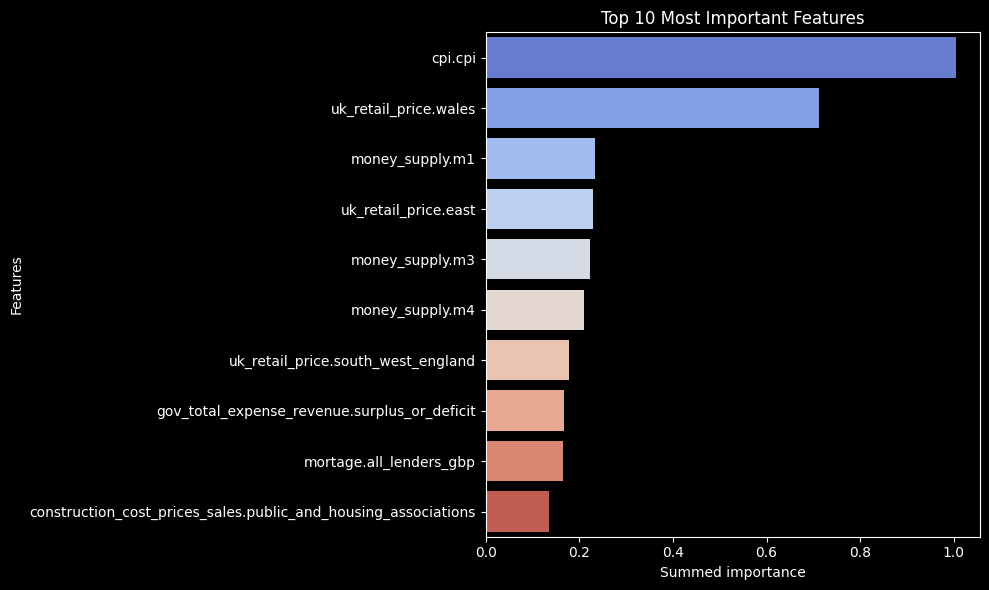

In [ ]:
plot_feature_importance(best_models_revenue)

In [ ]:
for i in dependent_vars_revenue:
    plot_metrics(revenue_results_dict, best_models_revenue, i)

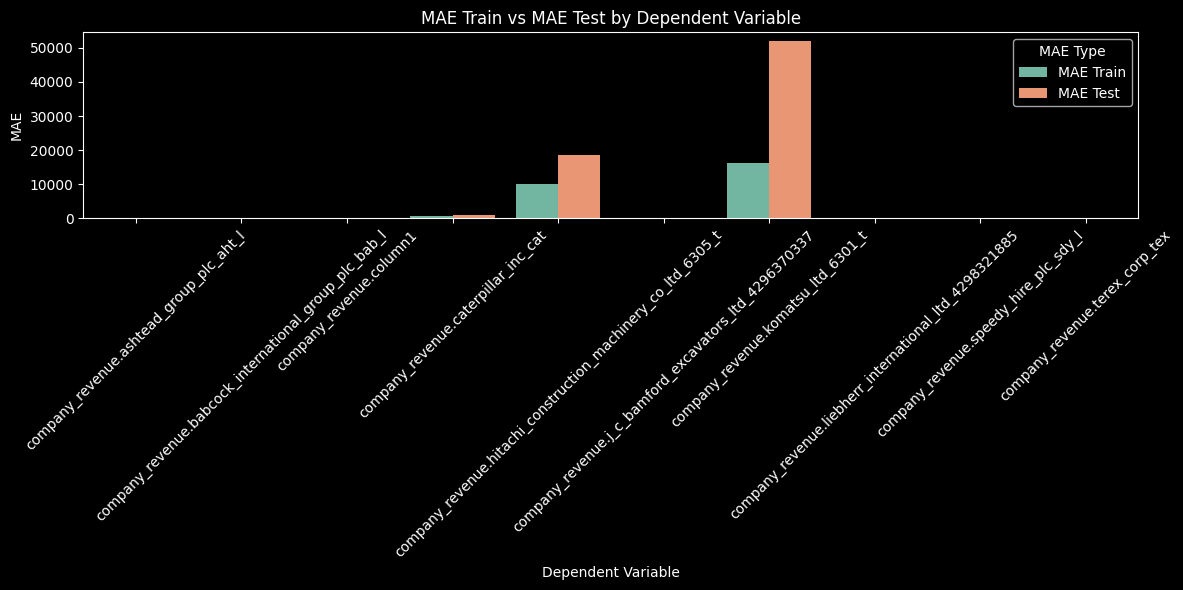

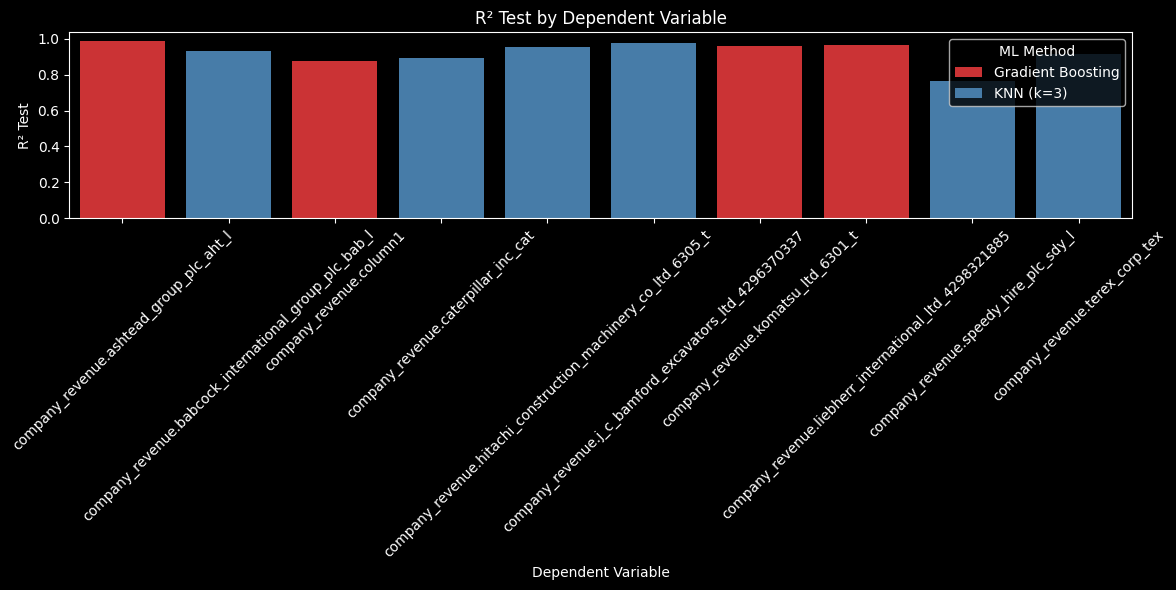

In [ ]:
plot_models(best_models_revenue)

## Cost prediction

In [ ]:
dependent_vars_cost = list(df_final[xlsx['operating_expenses'].columns[1:]])
df = df_final[dependent_vars_cost + X].copy()

In [ ]:
cost_results = []
for i in dependent_vars_cost:
    cost_results.append(regression_analysis(df, i, X))

Data for operating_expenses.ashtead_group_plc_aht_l is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ Dimension mismatch for Random Forest: 83 importances vs 77 features
⚠️ Dimension mismatch for Gradient Boosting: 83 importances vs 77 features
Data for operating_expenses.babcock_international_group_plc_bab_l is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ Dimension mismatch for Random Forest: 83 importances vs 77 features
⚠️ Dimension mismatch for Gradient Boosting: 83 importances vs 77 features
Data for operating_expenses.column1 is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ Dimension mismatch for Random Forest: 83 importances vs 77 features
⚠️ Dimension mismatch for Gradient Boosting: 83 importances vs 77 features
Data for operating_expenses.caterpillar_inc_cat is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ D

In [ ]:
cost_results_dict = []
for i in range(len(cost_results)):
    cost_results_dict.append(cost_results[i][0])

best_models_cost = []
for i in range(len(cost_results)):
    best_models_cost.append(cost_results[i][1])

best_models_cost = {list(item.keys())[0]: item[list(item.keys())[0]] for item in best_models_cost}

In [ ]:
for i in dependent_vars_cost:
    plot_metrics(cost_results_dict, best_models_cost, i)

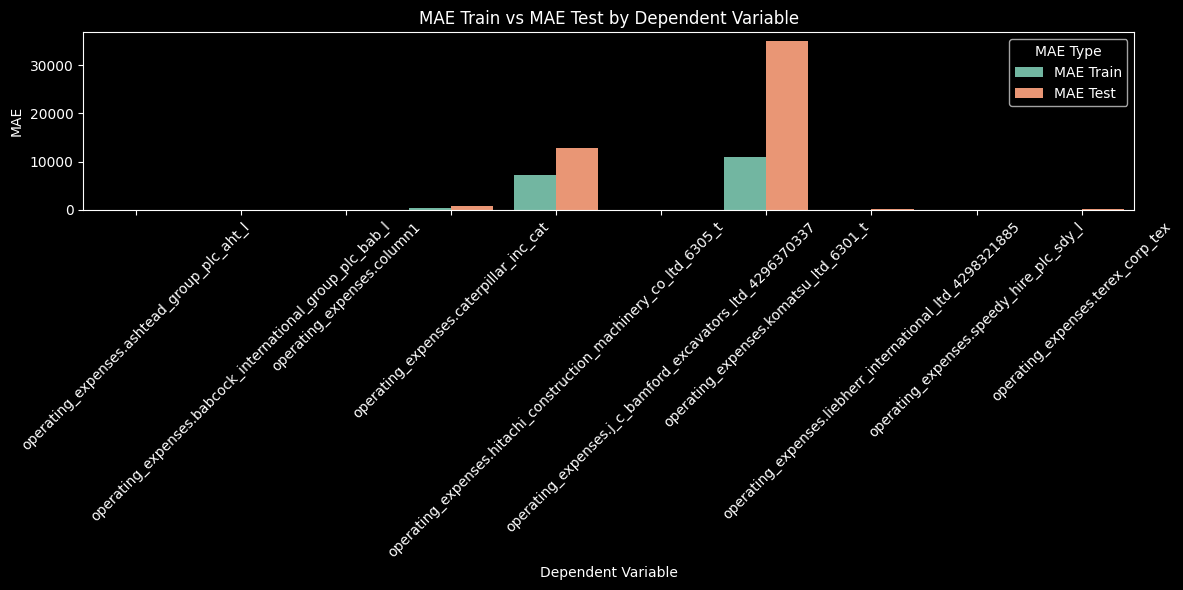

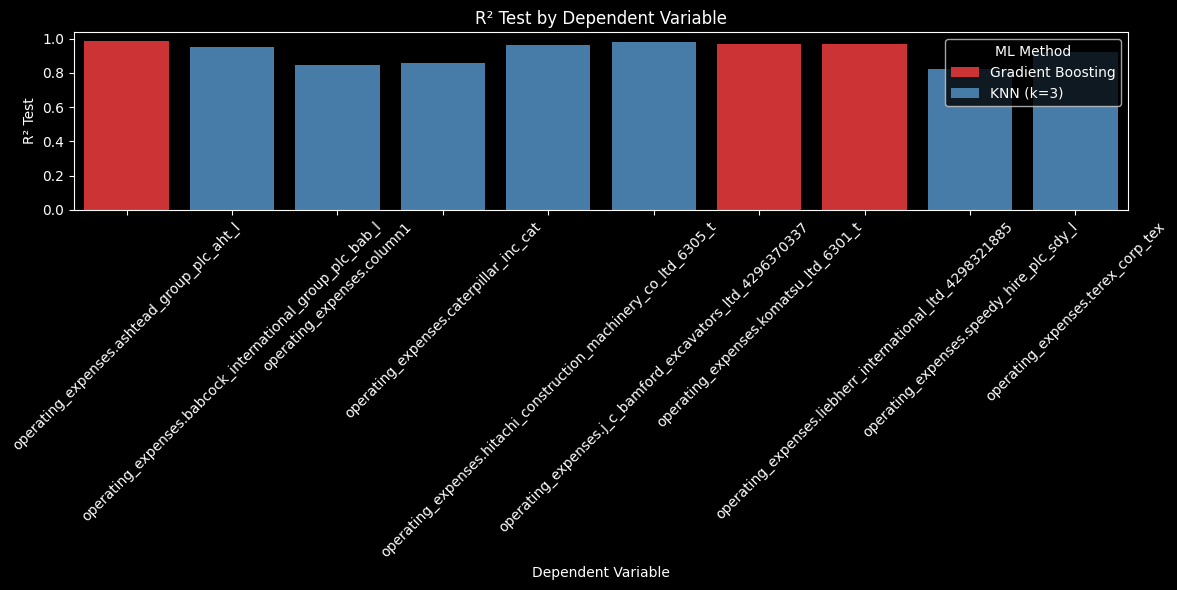

In [ ]:
plot_models(best_models_cost)

dict_keys(['operating_expenses.ashtead_group_plc_aht_l', 'operating_expenses.babcock_international_group_plc_bab_l', 'operating_expenses.column1', 'operating_expenses.caterpillar_inc_cat', 'operating_expenses.hitachi_construction_machinery_co_ltd_6305_t', 'operating_expenses.j_c_bamford_excavators_ltd_4296370337', 'operating_expenses.komatsu_ltd_6301_t', 'operating_expenses.liebherr_international_ltd_4298321885', 'operating_expenses.speedy_hire_plc_sdy_l', 'operating_expenses.terex_corp_tex'])


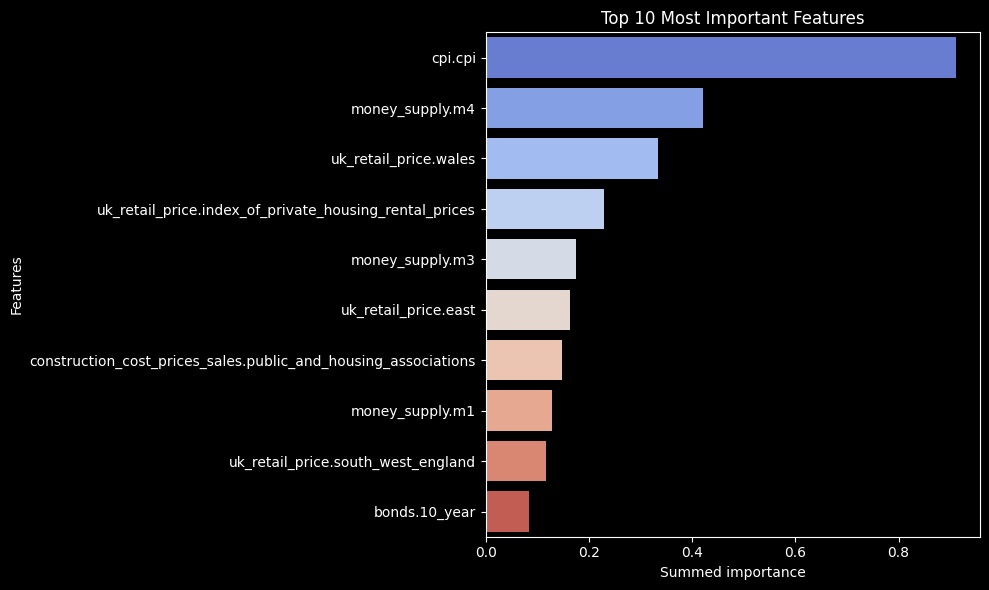

In [ ]:
plot_feature_importance(best_models_cost)